# Data Science Workshop

# Data Loading

## Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import sklearn.linear_model as lm
import sklearn.svm as svm_lib
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.decomposition import PCA

from outliers import smirnov_grubbs as grubbs

import random
import json
import time

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## Reading the Income Classification Dataset

In [2]:
# read the entire file into a python array
with open('new_raw_data.json', 'rb') as f:
    data = f.readlines()
with open('photos.json', 'rb') as f:
    photos_data = f.readlines()
with open('not_self_feeds.json', 'rb') as f:
    feeds_data = f.readlines()
with open('self_feeds.json', 'rb') as f:
    posts_data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
photos_data = map(lambda x: x.rstrip(), photos_data)
feeds_data = map(lambda x: x.rstrip(), feeds_data)
posts_data = map(lambda x: x.rstrip(), posts_data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"
photos_data_json_str = "[" + ','.join(photos_data) + "]"
feeds_data_json_str = "[" + ','.join(feeds_data) + "]"
posts_data_json_str = "[" + ','.join(posts_data) + "]"

# now, load it into pandas
raw_data = pd.read_json(data_json_str)
photos_raw_data = pd.read_json(photos_data_json_str)
feeds_raw_data = pd.read_json(feeds_data_json_str)
posts_raw_data = pd.read_json(posts_data_json_str)

# join all data frames - used inner join to get rid of outdated pages (pages that got deleted between our queries)
raw_data = pd.merge(left=raw_data, right=photos_raw_data, how='inner', left_on='id', right_on='page_id')
raw_data = pd.merge(left=raw_data, right=posts_raw_data, how='inner', left_on='id', right_on='page_id')
# most pages didnt have any posts from other users/pages on their feed, so left join is used here
raw_data = pd.merge(left=raw_data, right=feeds_raw_data, how='left', left_on='id', right_on='page_id')

raw_data.drop(['page_id_x', 'page_id_y', 'page_id'], axis=1, inplace=True)

# Data preparation

In [3]:
ready_feats = [ 'has_cover_photo', 'has_profile_photo', 'id', 'likes', 'has_bio', 'has_birthday', 'has_company_overview',
                'has_about', 'has_hours', 'checkins', 'has_payment_options', 'search_category', 'has_mission', 'category',
#                 'category_list_len'
               
                # photo fields
                'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 'photo_avg_likes_per_photo',
                'photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero', 
                'photo_count_has_name', 'photo_count_has_place', 'photo_distinct_uploaders', 
                'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 'photo_number_of_albums', 
                'photo_number_of_cover_albums', 'photo_number_of_different_months_for_photos', 'photo_number_of_null_albums', 
                'photo_number_of_other_albums', 'photo_number_of_photos_in_cover_albums', 'photo_number_of_photos_in_null_albums', 
                'photo_number_of_photos_in_other_albums', 'photo_number_of_photos_in_profile_albums', 
                'photo_number_of_profile_albums', 'total_photos', 'photo_number_of_days_between_first_and_last_photos',
               
                # feed fields
                'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_number_of_days_between_first_and_last_posts',
                'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
                'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_sum_people_tagged_count', 
                'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares', 'feed_std_shares',
                'feed_distinct_post_writers', 'feed_post_count',

                # posts fields
                'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_likes_per_comment',                           
                'self_feed_avg_people_tagged_per_post', 'self_feed_avg_people_tagged_per_post_with_more_than_zero',  
                'self_feed_number_of_days_between_first_and_last_posts', 'self_feed_avg_with_tagged_per_post',                        
                'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'self_feed_count_has_place',                                 
                'self_feed_count_post_updated', 'self_feed_is_published_count', 'self_feed_max_comments',
                'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_number_of_added_photos_category',                 
                'self_feed_number_of_different_months_for_post', 'self_feed_number_of_null_category', 'self_feed_number_of_other_categories',                      
                'self_feed_number_of_shared_story_category', 'self_feed_post_max_people_tagged', 'self_feed_post_max_with_tagged',                            
                'self_feed_post_updated_prc', 'self_feed_std_comments', 'self_feed_std_likes', 'self_feed_sum_people_tagged_count',                         
                'self_feed_sum_with_tagged_count', 'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares',                                      
                'self_feed_std_shares', 'self_post_count'
              ]

all_data = raw_data[ready_feats].copy()

# merge identical columns
all_data['general_info'] = pd.concat([raw_data['generalInfo'].dropna(), raw_data['general_info'].dropna()]).reindex_like(raw_data)
all_data['is_permanently_closed'] = pd.concat([raw_data['isPermanentlyClosed'].dropna(), raw_data['is_permanently_closed'].dropna()]).reindex_like(raw_data)
all_data['is_unclaimed'] = pd.concat([raw_data['isUnclaimed'].dropna(), raw_data['is_unclaimed'].dropna()]).reindex_like(raw_data)
all_data['is_verified'] = pd.concat([raw_data['isVerified'].dropna(), raw_data['is_verified'].dropna()]).reindex_like(raw_data)
all_data['price_range'] = pd.concat([raw_data['priceRange'].dropna(), raw_data['price_range'].dropna()]).reindex_like(raw_data)
all_data['start_info'] = pd.concat([raw_data['startInfo'].dropna(), raw_data['start_info'].dropna()]).reindex_like(raw_data)
all_data['talking_about_count'] = pd.concat([raw_data['talkingAboutCount'].dropna(), raw_data['talking_about_count'].dropna()]).reindex_like(raw_data)
all_data['were_here_count'] = pd.concat([raw_data['wereHereCount'].dropna(), raw_data['were_here_count'].dropna()]).reindex_like(raw_data)

# create 'has' columns
all_data['has_email'] = raw_data['emails'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_phone'] = raw_data['phone'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_website'] = raw_data['website'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_location'] = raw_data['location'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_description'] = raw_data['description'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_general_info'] = all_data['general_info'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_products'] = raw_data['products'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['self_feed_has_unpublished'] = all_data[['self_post_count','self_feed_is_published_count']].apply(lambda x: x['self_post_count'] == x['self_feed_is_published_count'], 1)

# create 'num of words' columns
all_data['name_num_of_words'] = raw_data['name'].apply(lambda x: len(x.split()) if type(x) != np.float else np.nan)

# parse complex vars
all_data['location_city'] = raw_data['location'].apply(lambda x: x['city'] if (type(x) != np.float and 'city' in x) else np.nan)
all_data['location_city'].fillna(raw_data['hometown'], inplace=True)
all_data['location_country'] = raw_data['location'].apply(lambda x: x['country'] if (type(x) != np.float and 'country' in x) else np.nan)
all_data['start_info'] = all_data['start_info'].apply(lambda x: x['date']['year'] if (type(x) != np.float and 'date' in x and 'year' in x['date']) else np.nan)
all_data['price_range'] = all_data['price_range'].apply(lambda x: len(x) if type(x) != np.float else np.nan)

category_mapping = {'Bank': 'business', 'Bar': 'life_style', 'Beauty': 'life_style', 'Beverages': 'food', 'Book': 'entertainment', 'Business': 'business', 'Character': 'entertainment', 'Church': 'organization', 'Coffee': 'life_style', 'Company': 'business', 'Equipment': 'industrial', 'Event': 'organization', 'Financial': 'business', 'Foo': 'food', 'Food': 'food', 'Goods': 'life_style', 'Government': 'organization', 'Health': 'life_style', 'Materials': 'industrial', 'Movie': 'entertainment', 'Music': 'entertainment', 'Organization': 'organization', 'Pet': 'life_style', 'Political': 'organization', 'Public': 'organization', 'School': 'organization', 'Services': 'business', 'Sports': 'entertainment', 'Supplies': 'industrial', 'TV': 'entertainment', 'Team': 'entertainment', 'Venue': 'organization', 'Video': 'entertainment'}        
all_data['main_category'] = all_data['search_category'].map(category_mapping)

# frequency related features - move to feature eng
all_data['photo_upload_freq'] = all_data.apply(lambda x: x['photo_number_of_days_between_first_and_last_photos']/x['total_photos'] if x['photo_number_of_days_between_first_and_last_photos'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
all_data['feed_update_freq'] = all_data.apply(lambda x: x['feed_number_of_days_between_first_and_last_posts']/x['feed_post_count'] if x['feed_number_of_days_between_first_and_last_posts'] != np.nan and x['feed_post_count'] != np.nan else 0, axis=1)
all_data['posting_freq'] = all_data.apply(lambda x: x['self_feed_number_of_days_between_first_and_last_posts']/x['self_post_count'] if x['self_feed_number_of_days_between_first_and_last_posts'] != np.nan and x['self_post_count'] != np.nan else 0, axis=1)

# convert types
all_data['founded'] = raw_data['founded'].apply(lambda x: np.int64(x) if (type(x) == unicode and x.strip().isdigit()) else np.nan)

# drop duplicate pages (we got some pages twice because we queried by page category and some pages were in several categrories)
all_data.drop_duplicates(subset='id', keep='last', inplace=True)

## Missing Data Imputation

In [4]:
print "Missing data by column (total rows %s):" % all_data.id.count()
missing_count = all_data.isnull().sum().sort_values(ascending=False)
print missing_count[missing_count.nonzero()[0]]

Missing data by column (total rows 12773):
feed_avg_with_tagged_per_post_with_more_than_zero           12505
feed_avg_people_tagged_per_post_with_more_than_zero         12031
feed_std_shares                                             11708
general_info                                                11504
self_feed_avg_with_tagged_per_post_with_more_than_zero      10936
founded                                                     10892
feed_avg_shares                                             10603
feed_max_shares                                             10603
feed_min_shares                                             10603
price_range                                                  9660
feed_avg_people_tagged_per_post                              8470
feed_number_of_days_between_first_and_last_posts             8470
feed_avg_with_tagged_per_post                                8470
feed_post_max_people_tagged                                  8470
feed_post_max_with_tagged        

In [5]:
# drop features too sparse or that have no meaningful way to fill
feats_to_drop = ['founded', 'start_info', 'general_info', 'feed_avg_with_tagged_per_post_with_more_than_zero', 
                 'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_std_shares', 
                 'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_post_updated_prc']
all_data.drop(feats_to_drop, axis = 1, inplace=True)

# NaN to 0
numeric_impute = [  'photo_avg_people_tagged_per_photo_with_more_than_zero', 'price_range',
                  
                    'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                    'feed_number_of_days_between_first_and_last_posts',
                    'feed_avg_with_tagged_per_post', 'feed_count_has_place', 
                    'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                    'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                    'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                    'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                    'feed_std_comments', 'feed_std_likes', 
                    'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares',
                    'feed_distinct_post_writers', 'feed_post_count', 'feed_update_freq', 'feed_sum_people_tagged_count',
                    
                    'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_people_tagged_per_post', 
                    'self_feed_avg_people_tagged_per_post_with_more_than_zero', 'self_feed_number_of_days_between_first_and_last_posts', 
                    'self_feed_avg_with_tagged_per_post', 'self_feed_max_comments', 
                    'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_post_max_people_tagged', 
                    'self_feed_post_max_with_tagged', 'self_feed_std_comments', 'self_feed_std_likes',  
                    'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares', 
                    'self_feed_std_shares', 'posting_freq', 'self_feed_sum_people_tagged_count', 'self_feed_sum_with_tagged_count'
                 ]
all_data[numeric_impute] = all_data[numeric_impute].fillna(0) 

# fill missing countries by city
all_data['location_country'].fillna('empty', inplace=True)
all_data['location_city'].fillna('empty', inplace=True)
temp = {k: g["location_country"].tolist() for k,g in all_data.groupby("location_city")}
city_to_country = {}
for city, countries in temp.items():
    if city == 'empty':
        city_to_country[city] = 'empty'
        continue
    for country in countries:
        if country != 'empty':
            city_to_country[city] = country
            break
    if city_to_country.get(city) is None:
        city_to_country[city] = 'empty'
all_data['location_country'] = all_data.apply(lambda x: x['location_country'] if x['location_country'] != 'empty' else city_to_country[x['location_city']], axis=1)
all_data['location_country'].fillna('empty', inplace=True)
val_count = all_data['location_country'].value_counts()
all_data['country'] = all_data.location_country.apply(lambda x: x if val_count[x] > 150 else 'other')
all_data.drop(['location_city', 'location_country'], axis = 1, inplace=True)

continent_mapping = {'United States': 'America', 'Thailand': 'Asia', 'Australia': 'Australia', 'Bangladesh': 'Asia', 'Brazil': 'America', 'Cambodia': 'Asia', 'Egypt': 'Africa', 'India': 'Asia', 'Israel': 'Asia', 'Mexico': 'America', 'Myanmar': 'Africa', 'Pakistan': 'Asia', 'Philippines': 'Asia', 'South Africa': 'Africa', 'United Kingdom': 'Europe', 'Vietnam': 'Asia', 'empty': 'Global', 'other': 'Europe'}
all_data['continent'] = all_data.country.map(continent_mapping)

print "Columns with missing data: ", all_data.isnull().sum().nonzero()[0]

Columns with missing data:  []


## Types Conversion

In [6]:
binary_variables = ['has_email', 'has_phone', 'has_website', 'has_location', 
                    'is_permanently_closed', 'is_unclaimed', 'is_verified', 'has_description', 
                    'has_general_info', 'has_products', 'self_feed_has_unpublished']

for variable in binary_variables:
    all_data[variable] = all_data[variable].astype(int)
    
for feat in all_data.columns.get_values():
    print "%s\t%s\t%s" % (all_data.columns.get_loc(feat), all_data.dtypes[all_data.columns.get_loc(feat)], feat)

0	int64	has_cover_photo
1	int64	has_profile_photo
2	int64	id
3	int64	likes
4	int64	has_bio
5	int64	has_birthday
6	int64	has_company_overview
7	int64	has_about
8	int64	has_hours
9	int64	checkins
10	int64	has_payment_options
11	object	search_category
12	int64	has_mission
13	object	category
14	float64	photo_avg_comments_per_photo
15	float64	photo_avg_likes_per_comments
16	float64	photo_avg_likes_per_photo
17	float64	photo_avg_people_tagged_per_photo
18	float64	photo_avg_people_tagged_per_photo_with_more_than_zero
19	int64	photo_count_has_name
20	int64	photo_count_has_place
21	int64	photo_distinct_uploaders
22	int64	photo_max_like
23	int64	photo_max_people_tagged
24	int64	photo_min_like
25	int64	photo_number_of_albums
26	int64	photo_number_of_cover_albums
27	int64	photo_number_of_different_months_for_photos
28	int64	photo_number_of_null_albums
29	int64	photo_number_of_other_albums
30	int64	photo_number_of_photos_in_cover_albums
31	int64	photo_number_of_photos_in_null_albums
32	int64	photo_

# Data Cleaning

In [7]:
def get_features_to_analyze():
    features = all_data.columns.get_values().tolist()
    features_to_remove = ['likes', 'country', 'search_category', 'category', 'main_category', 'continent']
    return [a for a in features if a not in features_to_remove]

### Remove features with low std

In [8]:
features = get_features_to_analyze()
stds = {}

for feat in features:
    curr_std = all_data[feat].std()
    stds[feat] = curr_std
    
sorted_by_std = sorted(stds.items(), key=lambda x: x[1])
low_std = [a for a in sorted_by_std if a[1] < 0.3]
for a in low_std:
    print a[0] + " -- with std of: " + str(a[1])

photo_number_of_photos_in_null_albums -- with std of: 0.0
has_profile_photo -- with std of: 0.0
photo_number_of_null_albums -- with std of: 0.0
photo_distinct_uploaders -- with std of: 0.0
is_permanently_closed -- with std of: 0.0176942650361
is_unclaimed -- with std of: 0.0197820150598
feed_number_of_null_category -- with std of: 0.0586643438236
has_bio -- with std of: 0.137166483067
feed_avg_people_tagged_per_post -- with std of: 0.150598145682
self_feed_post_updated_prc -- with std of: 0.161076721316
self_feed_has_unpublished -- with std of: 0.16550599025
has_payment_options -- with std of: 0.207863823005
has_about -- with std of: 0.236568340661
has_website -- with std of: 0.279276120539
has_general_info -- with std of: 0.299143338765


In [9]:
zero_std_features = [a[0] for a in sorted_by_std if a[1] == 0]

# remove permanently_closed and is_unclaimed pages
all_data = all_data[all_data['is_permanently_closed'] != 1].reset_index(drop=True)
all_data = all_data[all_data['is_unclaimed'] != 1].reset_index(drop=True)
low_std_features = zero_std_features + ['is_permanently_closed', 'is_unclaimed', 'feed_number_of_null_category']

# drop features with low std
all_data.drop(low_std_features, axis=1, inplace=True)

### Remove too correlated features

In [10]:
features = get_features_to_analyze()

corrs = {}
threshold = 0.9

for i in range(len(features)):
    for j in range(i+1,len(features)):
        curr_corr = np.corrcoef(all_data[features[i]], all_data[features[j]])
        c = curr_corr[0][1]
        if c > threshold or c < -(threshold):
            corrs[(features[i],features[j])] = c
            
sorted_by_corr = sorted(corrs.items(), key=lambda x: x[1], reverse=True)
for a in sorted_by_corr:
        print a[0][0] + " and " + a[0][1] + " -- with correlation of: " + str(a[1])

        

feed_is_published_count and feed_post_count -- with correlation of: 1.0
self_feed_is_published_count and self_post_count -- with correlation of: 0.999902425984
feed_distinct_post_writers and feed_post_count -- with correlation of: 0.982135591891
feed_is_published_count and feed_distinct_post_writers -- with correlation of: 0.982135591891
self_feed_avg_people_tagged_per_post and self_feed_sum_people_tagged_count -- with correlation of: 0.979943565264
feed_max_likes and feed_std_likes -- with correlation of: 0.974911796455
photo_number_of_photos_in_other_albums and total_photos -- with correlation of: 0.97016025273
self_feed_avg_with_tagged_per_post and self_feed_sum_with_tagged_count -- with correlation of: 0.967020046602
photo_number_of_albums and photo_number_of_other_albums -- with correlation of: 0.953475312032
self_feed_max_likes and self_feed_std_likes -- with correlation of: 0.93922959203
feed_post_max_with_tagged and feed_sum_with_tagged_count -- with correlation of: 0.930935953

In [11]:
all_data['self_feed_has_unpublished'] = all_data.apply(lambda x: x['self_post_count'] != x['self_feed_is_published_count'], 1)


# drop features too correlated
too_coor_feats = ['feed_is_published_count', 'self_feed_is_published_count', 'feed_distinct_post_writers',
                  'photo_number_of_photos_in_other_albums', 
                  'self_feed_sum_with_tagged_count', 'self_feed_sum_people_tagged_count',
                  'feed_sum_people_tagged_count', 'feed_sum_with_tagged_count']
all_data.drop(too_coor_feats, axis=1, inplace=True)

# Data Exploration

### Data Exploration utils

In [12]:
def show_numric_features(features):
    for key in features.keys():
        key_dict = features.get(key)
        col = key_dict.get('column')
        data_to_show = all_data[(all_data[col] >= key_dict.get('lower_bound')) & 
                              (all_data[col] <= key_dict.get('upper_bound'))][col]

        sns.distplot(data_to_show, 
                     bins = key_dict.get('bins'), kde = key_dict.get('kde'), label = key)
        plt.title('Histogram of ' + key)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(loc="upper right")
        plt.show()

def show_log_numric_features(features):
    for col in features:
        data_to_show = all_data[(all_data[col] > 0)][col]
        log_data_to_show = data_to_show.apply(lambda x: np.log(x)).to_frame('log_' + col)
        sns.distplot(log_data_to_show, label = col)
        plt.title('Histogram of log ' + col)
        plt.xlabel('log_' + col)
        plt.ylabel('Count')
        plt.legend(loc="upper right")
        plt.show()

def show_categorical_features(features):
    for feat in features:
        data_to_show = all_data[[feat]]
        unique_values = data_to_show[feat].unique().tolist()
        unique_values.sort()
        if (unique_values == [0,1]):
            data_to_show = data_to_show.astype(bool)
        sns.plt.title(feat + ' count')
        ax = sns.countplot(feat, data=data_to_show) #,color='purple')
        sns.plt.show()

def show_categorical_data(data):
    for df in data:
        feat = df.columns.tolist()[0]
        ax = sns.countplot(feat, data=df)
        sns.plt.show()

def show_correlation(columns):
    data = all_data[columns]
    pd.tools.plotting.scatter_matrix(data, alpha = 0.6, figsize = (10,10), diagonal = 'kde')
    plt.show()


def show_scatter(data,op=0):
    keys = data.keys()
    if op == 0:
        col1 = keys[0]
        col2 = keys[1]
    else:
        col1 = keys[1]
        col2 = keys[0]
    sns.set(color_codes=True)
    scatter = pd.DataFrame()
    data_to_show = all_data[(all_data[col1] >= data[col1][0]) & (all_data[col1] < data[col1][1]) & 
                             (all_data[col2] >= data[col2][0]) & (all_data[col2] < data[col2][1])]
    scatter[col1] = data_to_show[col1]
    scatter[col2] = data_to_show[col2]
    rows = random.sample(scatter.index, 1000)
    scatter_10 = scatter.ix[rows]
    sns.regplot(col1, col2, scatter_10, 
                scatter_kws={"marker": ".", "color": "green"},
                line_kws = {"linewidth": "1", "color": "green"},
                order = 2, label = 'points')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend(loc="lower right")
    plt.title("Scatter plot of " + col1 + " and " + col2)
    plt.show()

In [13]:
for feat in all_data.columns.get_values():
    if feat != 'id':
        print "==============================================="
        print all_data[feat].describe()

count   12,764.00
mean         0.19
std          0.39
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_cover_photo, dtype: float64
count        12,764.00
mean        429,905.08
std       2,216,464.40
min               0.00
25%           9,192.25
50%          38,107.50
75%         172,433.25
max     102,762,547.00
Name: likes, dtype: float64
count   12,764.00
mean         0.02
std          0.14
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_bio, dtype: float64
count   12,764.00
mean         0.19
std          0.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_birthday, dtype: float64
count   12,764.00
mean         0.12
std          0.33
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_company_overview, dtype: float64
count   12,764.00
mean         0.94
std          0.24
min         

### Likes

count        12,764.00
mean        429,905.08
std       2,216,464.40
min               0.00
25%           9,192.25
50%          38,107.50
75%         172,433.25
max     102,762,547.00
Name: likes, dtype: float64


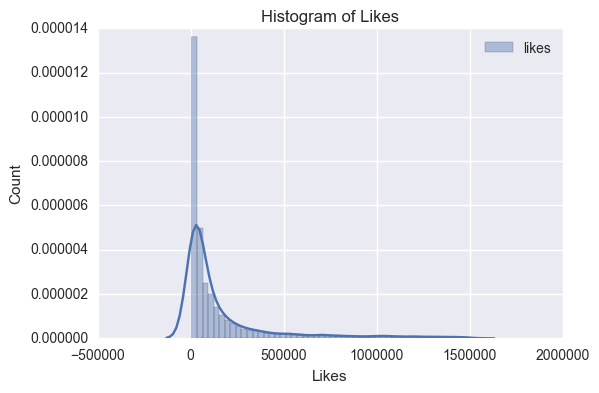

count   12,756.00
mean        10.60
std          2.26
min          0.00
25%          9.13
50%         10.55
75%         12.06
max         18.45
Name: likes, dtype: float64


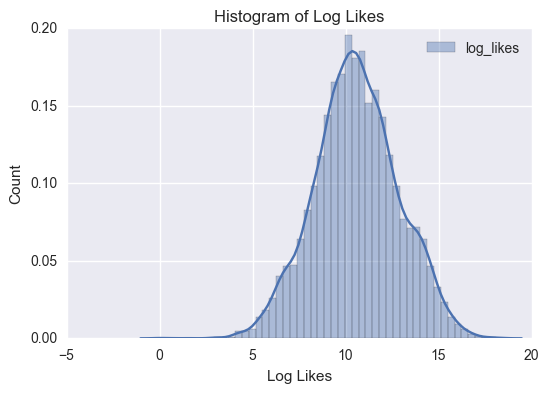

skewness: -0.00136172485706
kurtosis: -0.0225753909844 



In [14]:
print all_data.likes.describe()
sns.distplot(all_data[(all_data['likes'] > 5000) & (all_data['likes'] < 1500000)].likes, 
             bins = 50, kde = True, label = "likes")
plt.title('Histogram of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

log_likes = all_data[all_data['likes'] > 0]['likes'].apply(lambda x: np.log(x))
print log_likes.describe()

sns.distplot(log_likes, bins = 50, kde = True, label = "log_likes")
plt.title('Histogram of Log Likes')
plt.xlabel('Log Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

print "skewness:", log_likes.skew()
print "kurtosis:", log_likes.kurtosis(), '\n'


       self_feed_avg_likes
count            12,498.00
mean                  0.00
std                   1.00
min                  -4.22
25%                  -0.72
50%                  -0.01
75%                   0.71
max                   3.43


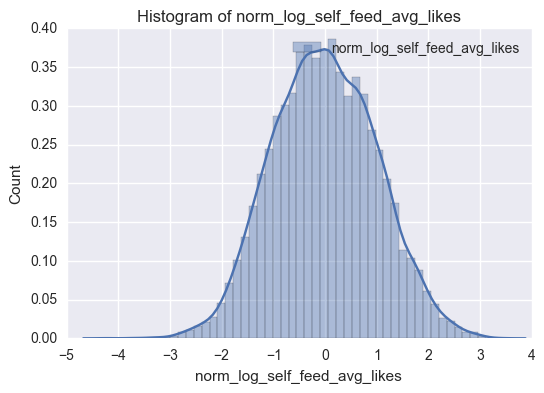

skewness: self_feed_avg_likes   0.05
dtype: float64
kurtosis: self_feed_avg_likes   -0.23
dtype: float64 



In [15]:
data_to_show = all_data[all_data['self_feed_avg_likes'] > 0]['self_feed_avg_likes'] 
log_self_feed_avg_likes = data_to_show.apply(lambda x: np.log(x)).to_frame('self_feed_avg_likes')
# print log_self_feed_avg_likes.describe()
log_self_feed_avg_likes_mean = log_self_feed_avg_likes.mean()
log_self_feed_avg_likes_std = log_self_feed_avg_likes.std()



norm_log_self_feed_avg_likes = log_self_feed_avg_likes['self_feed_avg_likes'].apply(lambda x: (x - log_self_feed_avg_likes_mean) / (log_self_feed_avg_likes_std))
print norm_log_self_feed_avg_likes.describe()
sns.distplot(norm_log_self_feed_avg_likes, bins = 50, kde = True, label = "norm_log_self_feed_avg_likes")
plt.title('Histogram of norm_log_self_feed_avg_likes')
plt.xlabel('norm_log_self_feed_avg_likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

print "skewness:", norm_log_self_feed_avg_likes.skew()
print "kurtosis:", norm_log_self_feed_avg_likes.kurtosis(), '\n'

### Genral Info features

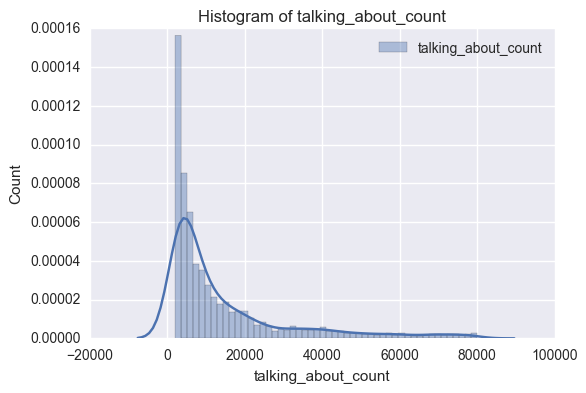

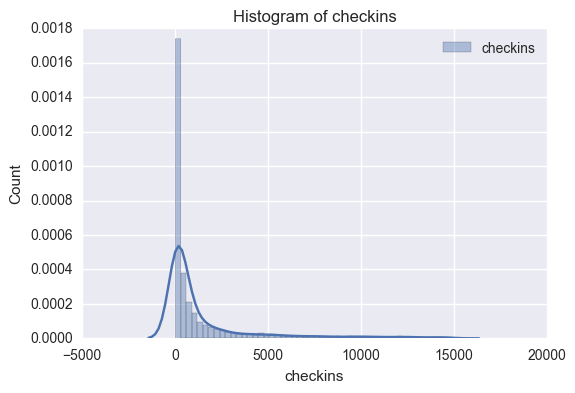

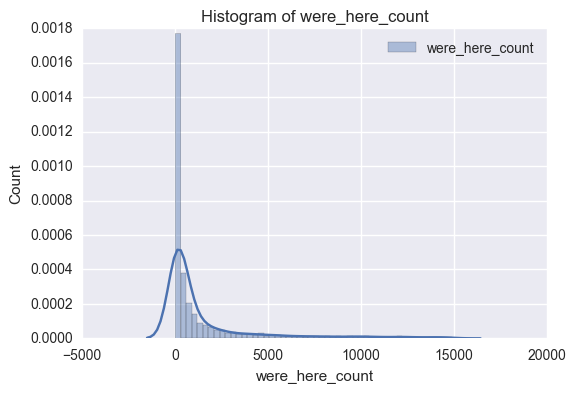

In [16]:
page_numric_features = {'talking_about_count':{'column': 'talking_about_count','lower_bound': 2000, 'upper_bound': 80000, 'bins': 50, 'kde': True},
        'were_here_count':{'column': 'were_here_count','lower_bound': 10, 'upper_bound': 15000, 'bins': 50, 'kde': True},
        'checkins': {'column': 'checkins','lower_bound': 10, 'upper_bound': 15000, 'bins': 50, 'kde': True}}
show_numric_features(page_numric_features)


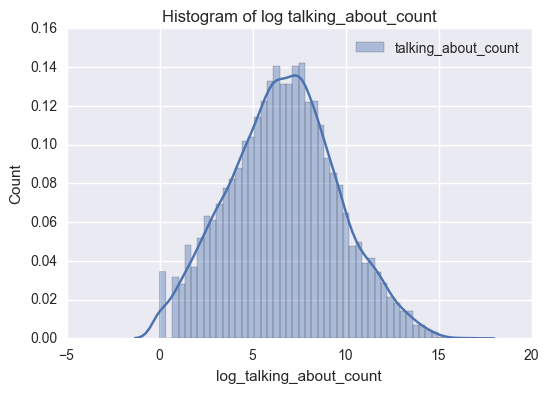

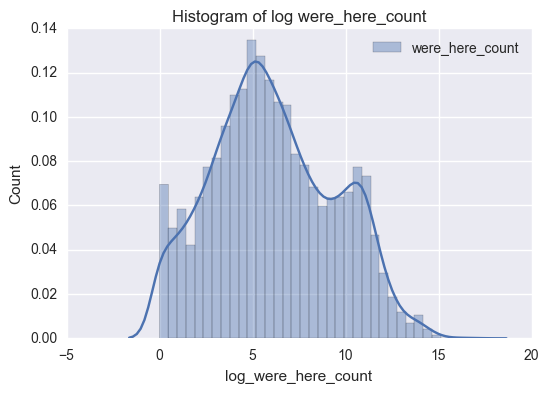

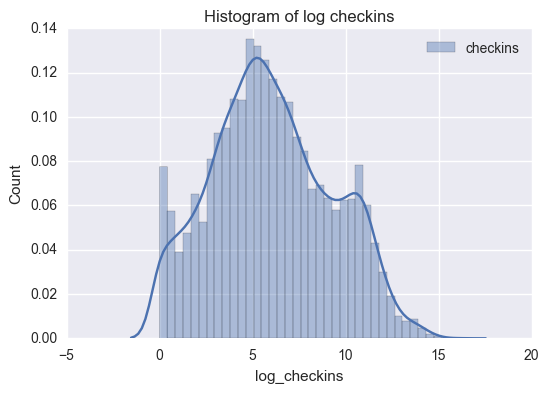

In [17]:
page_exp_features = ['talking_about_count', 'were_here_count', 'checkins']
show_log_numric_features(page_exp_features)

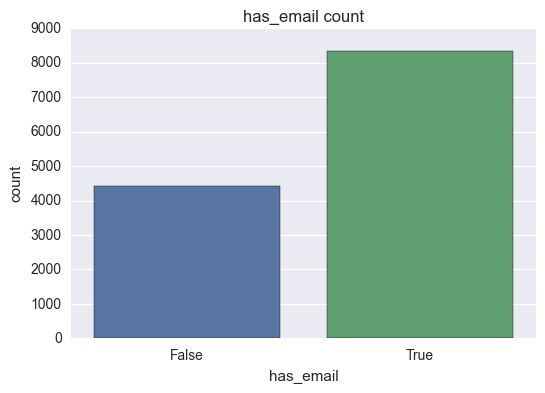

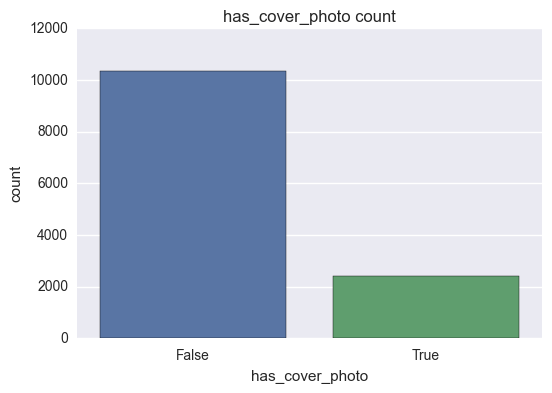

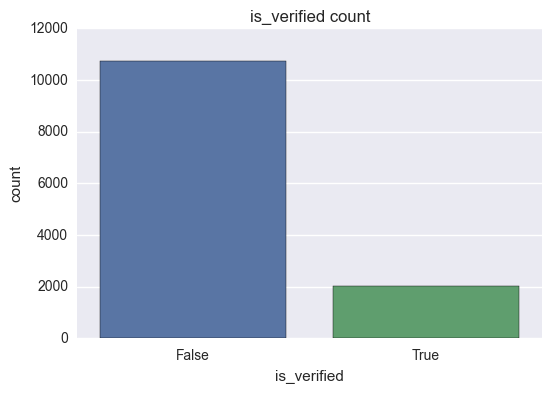

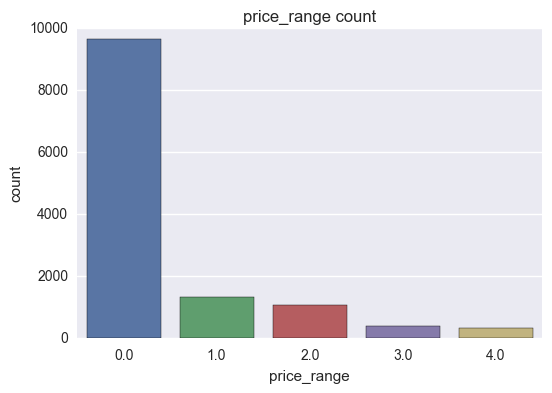

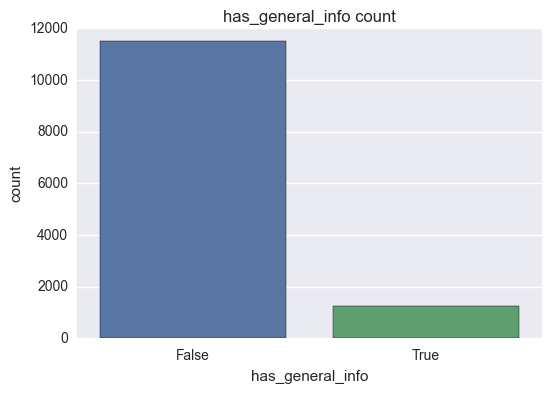

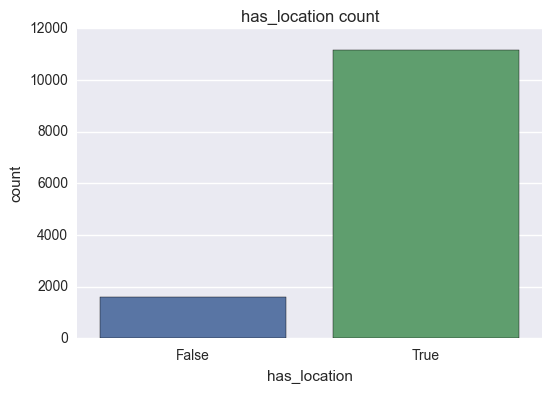

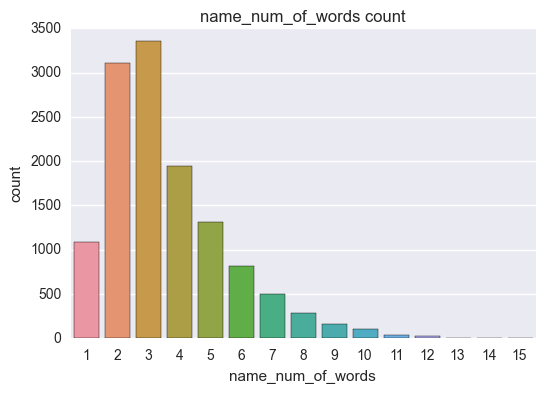

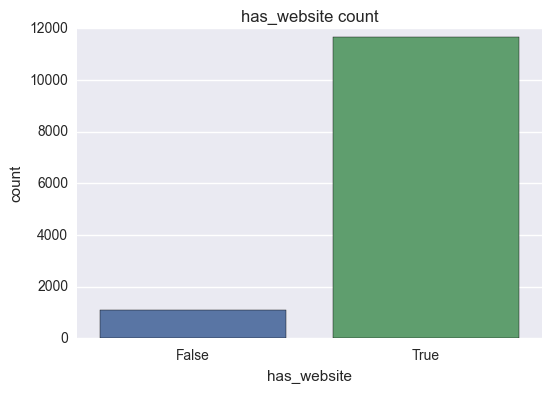

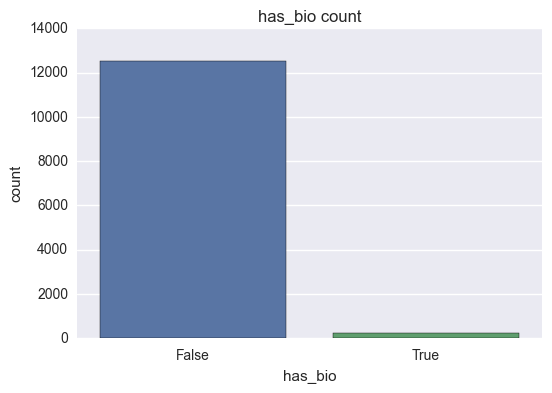

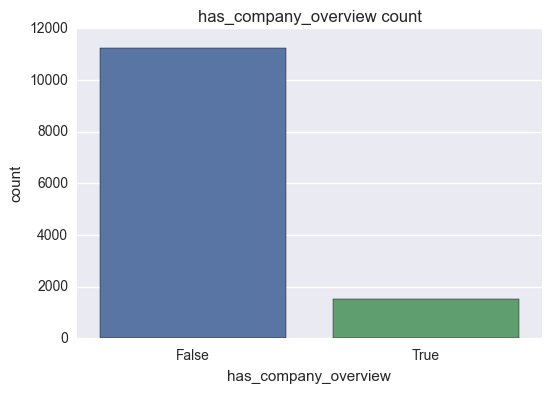

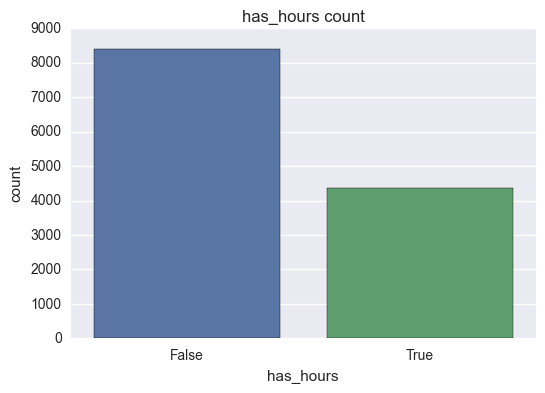

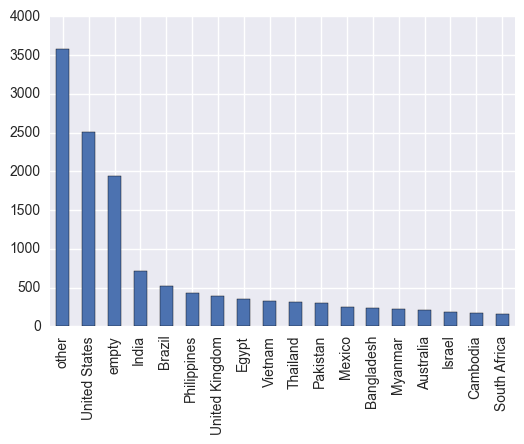

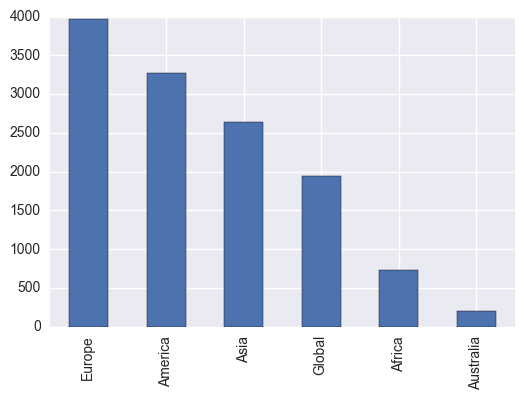

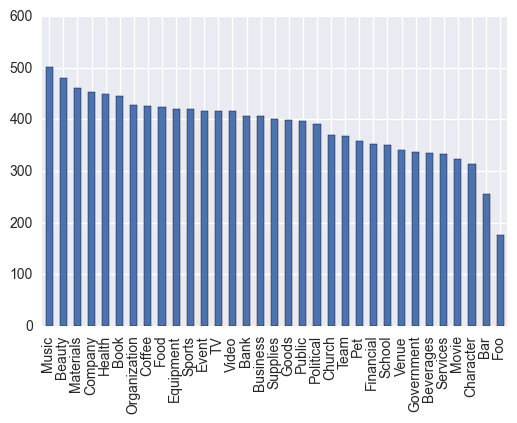

In [18]:
page_categorical_features = ['has_email', 'has_cover_photo', 'is_verified', 'price_range', 
                             'has_general_info', 'has_location', 'name_num_of_words', 'has_website',
                            'has_bio', 'has_company_overview', 'has_hours']

show_categorical_features(page_categorical_features)

# countries count plot
countries = all_data['country'].value_counts().plot(kind='bar')
plt.show()

# continent count plot
continents = all_data['continent'].value_counts().plot(kind='bar')
plt.show()

search_categories = all_data['search_category'].value_counts().plot(kind='bar')
plt.show()


### Self Feed Features

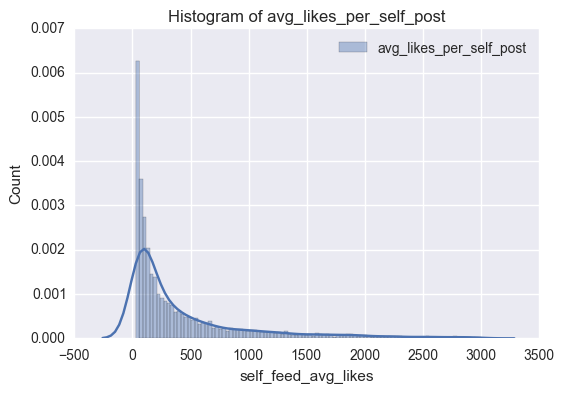

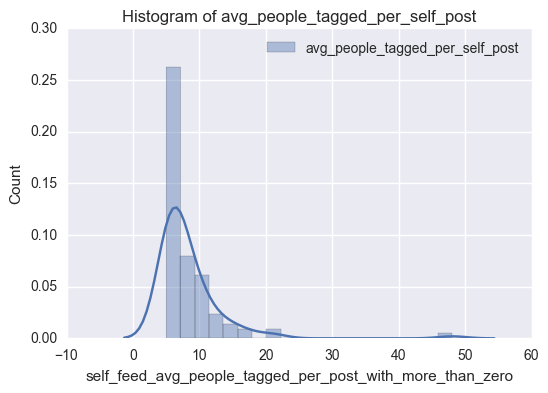

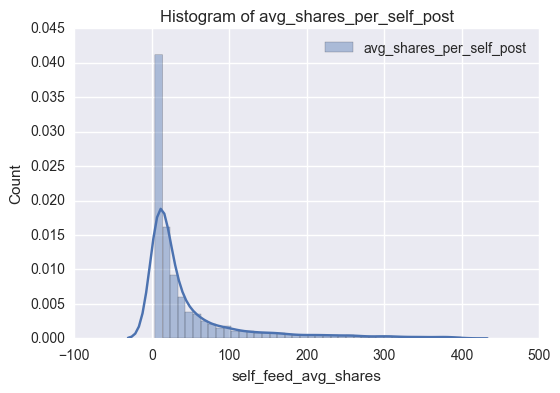

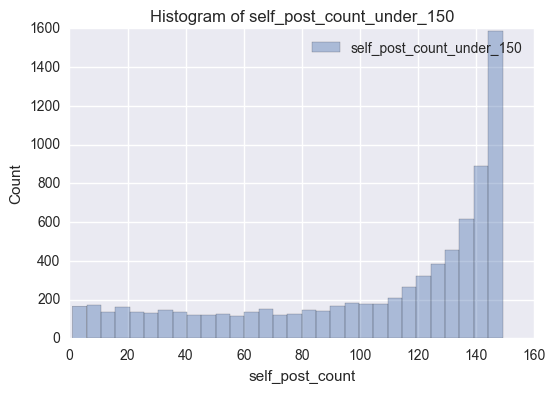

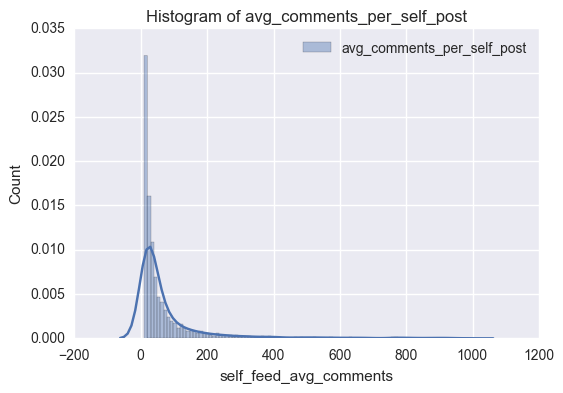

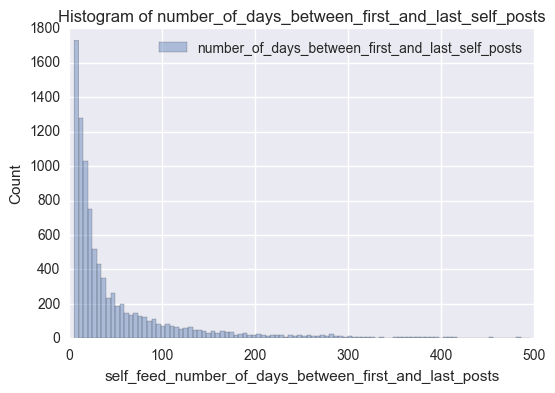

In [19]:
self_feed_numric_features = {'self_post_count_under_150':{'column': 'self_post_count','lower_bound': 0, 'upper_bound': 149, 'bins': 30, 'kde': False},
                        'avg_likes_per_self_post':{'column': 'self_feed_avg_likes','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_comments_per_self_post': {'column': 'self_feed_avg_comments','lower_bound': 10, 'upper_bound': 1000, 'bins': 100, 'kde': True},
                        'avg_shares_per_self_post': {'column': 'self_feed_avg_shares','lower_bound': 4, 'upper_bound': 400, 'bins': 40, 'kde': True},

                        #'max_comments_per_post': {'column': 'feed_max_comments','lower_bound': 50, 'upper_bound': 5000, 'bins': 100, 'kde': True},
                        'avg_people_tagged_per_self_post':{'column': 'self_feed_avg_people_tagged_per_post_with_more_than_zero','lower_bound': 5, 'upper_bound': 100, 'bins': 20, 'kde': True},
                        'number_of_days_between_first_and_last_self_posts': {'column': 'self_feed_number_of_days_between_first_and_last_posts','lower_bound': 5, 'upper_bound': 500, 'bins': 100, 'kde': False}}

show_numric_features(self_feed_numric_features)


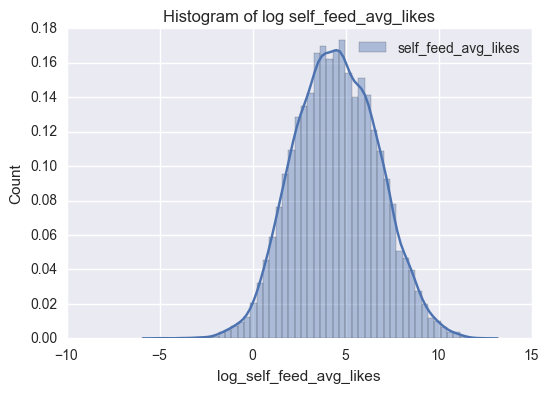

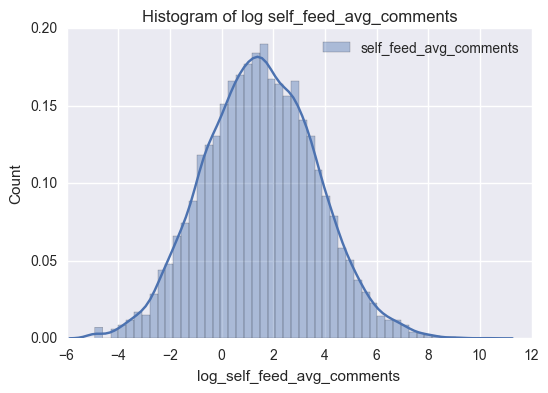

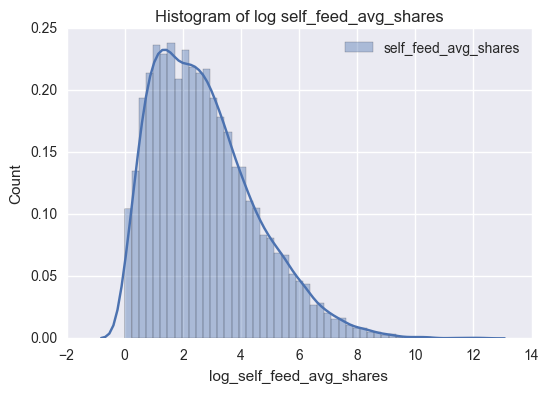

In [20]:
self_feed_exp_features = ['self_feed_avg_likes','self_feed_avg_comments', 'self_feed_avg_shares']   
show_log_numric_features(self_feed_exp_features) 

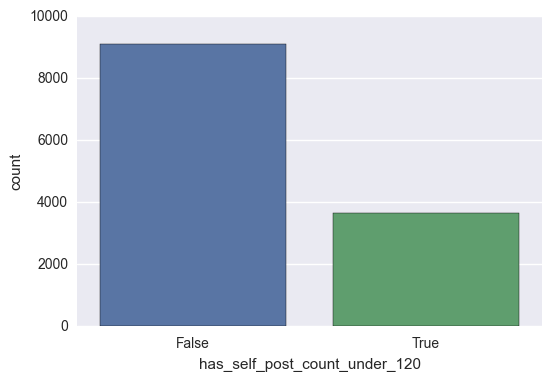

In [21]:
data = [all_data['self_post_count'].apply(lambda x: True if x < 120 else False).to_frame('has_self_post_count_under_120')]
show_categorical_data(data)

### Feed features

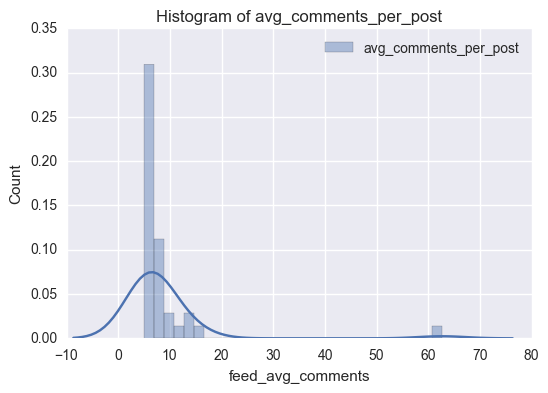

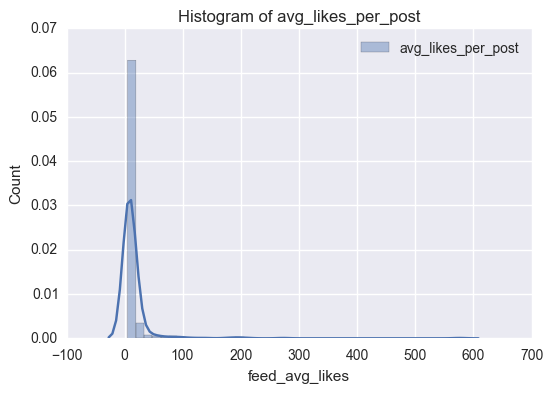

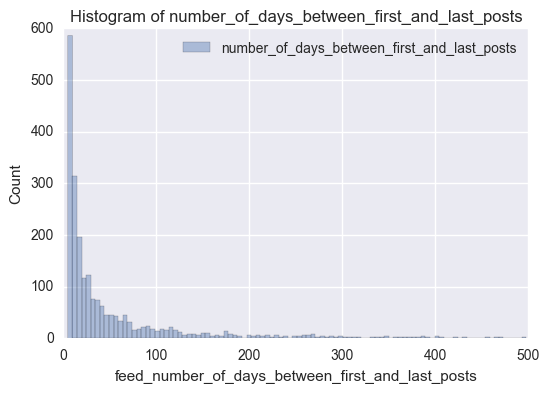

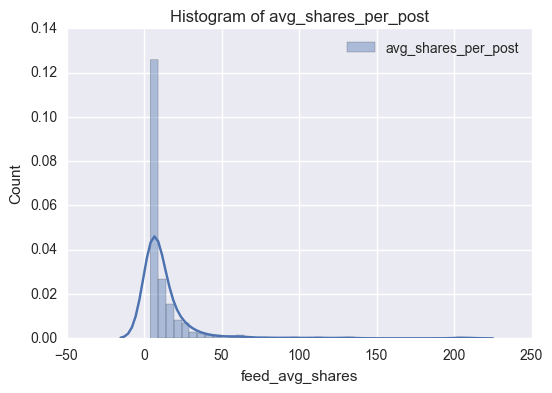

In [22]:
feed_numric_features = {'avg_likes_per_post':{'column': 'feed_avg_likes','lower_bound': 5, 'upper_bound': 800, 'bins': 40, 'kde': True},
                        'avg_comments_per_post': {'column': 'feed_avg_comments','lower_bound': 5, 'upper_bound': 100, 'bins': 30, 'kde': True},
                        'avg_shares_per_post': {'column': 'feed_avg_shares','lower_bound': 4, 'upper_bound': 400, 'bins': 40, 'kde': True},
                        'number_of_days_between_first_and_last_posts': {'column': 'feed_number_of_days_between_first_and_last_posts','lower_bound': 5, 'upper_bound': 500, 'bins': 100, 'kde': False}}

show_numric_features(feed_numric_features)


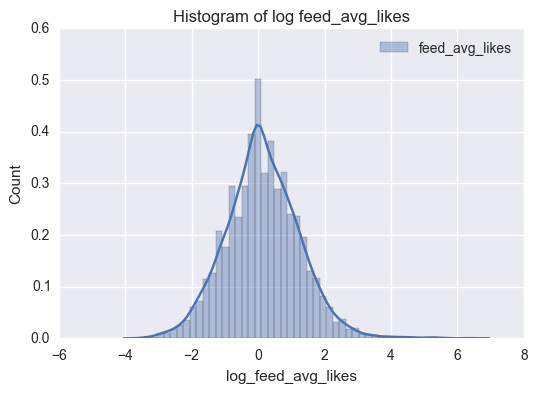

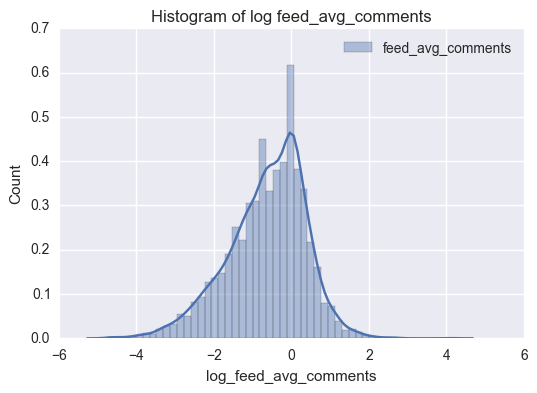

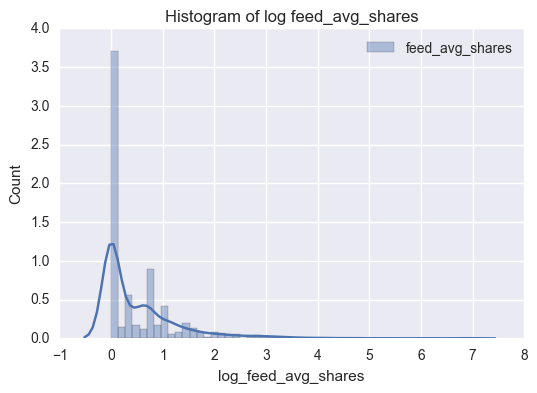

In [23]:
feed_exp_features = ['feed_avg_likes','feed_avg_comments','feed_avg_shares']
show_log_numric_features(feed_exp_features)

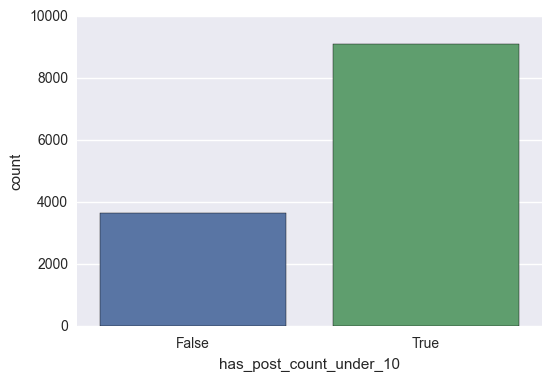

In [24]:
data = [all_data['feed_post_count'].apply(lambda x: True if x < 10 else False).to_frame('has_post_count_under_10')]
show_categorical_data(data)

### Photos features

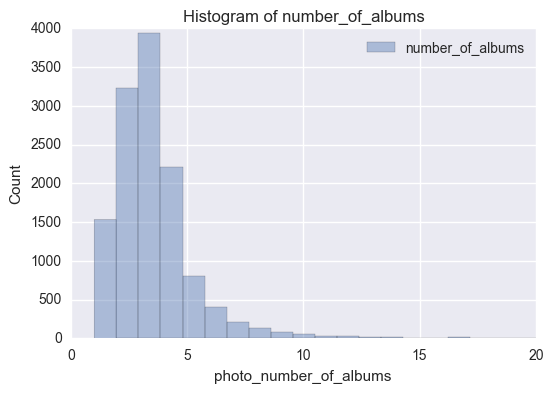

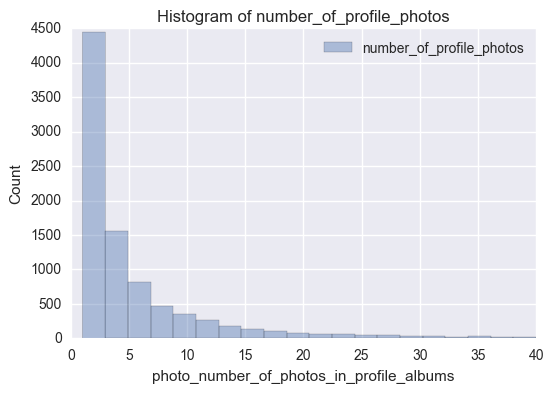

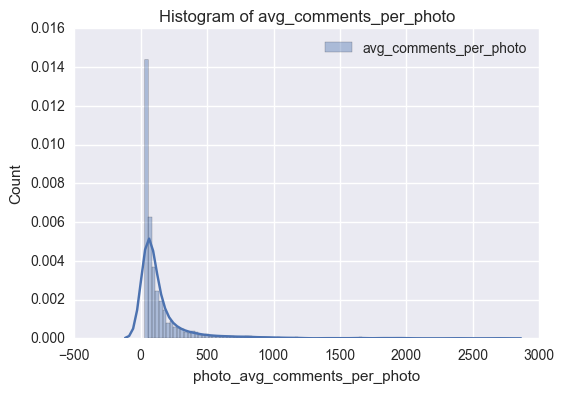

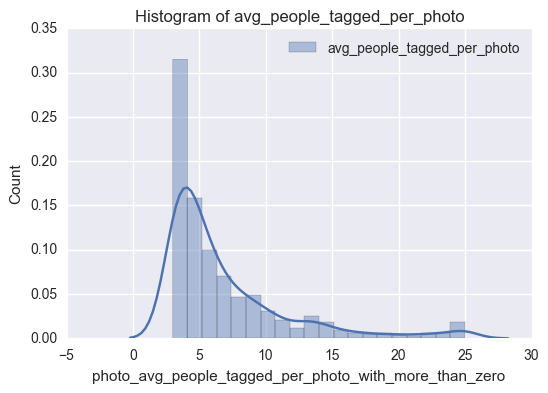

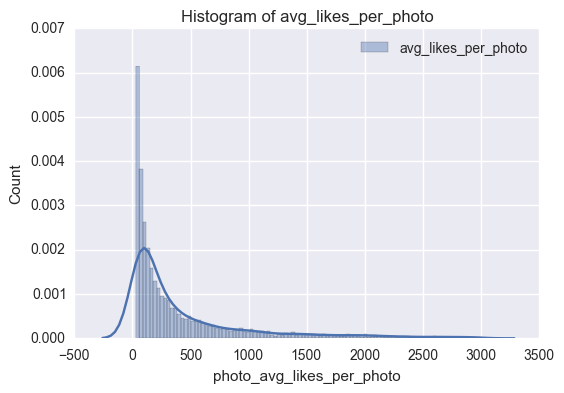

In [25]:
photo_numric_features = {'avg_likes_per_photo':{'column': 'photo_avg_likes_per_photo','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_comments_per_photo':{'column': 'photo_avg_comments_per_photo','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_people_tagged_per_photo':{'column': 'photo_avg_people_tagged_per_photo_with_more_than_zero','lower_bound': 3, 'upper_bound': 100, 'bins': 20, 'kde': True},
                        'number_of_albums': {'column': 'photo_number_of_albums','lower_bound': 0, 'upper_bound': 20, 'bins': 20, 'kde': False},
                        'number_of_profile_photos': {'column':'photo_number_of_photos_in_profile_albums', 'lower_bound': 1, 'upper_bound': 40, 'bins': 20, 'kde': False}}

show_numric_features(photo_numric_features)

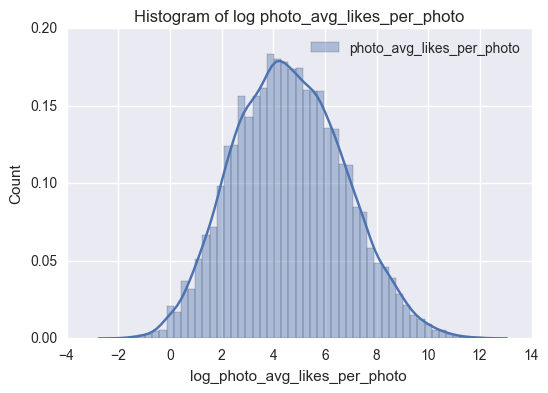

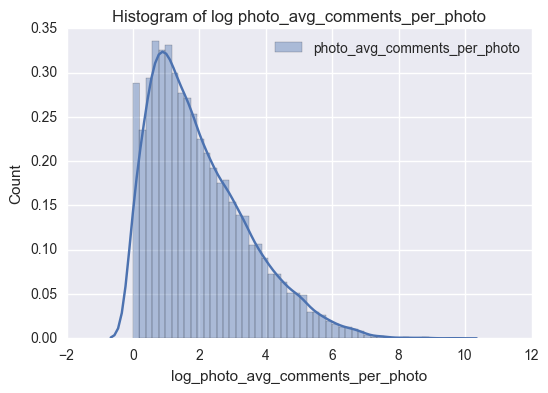

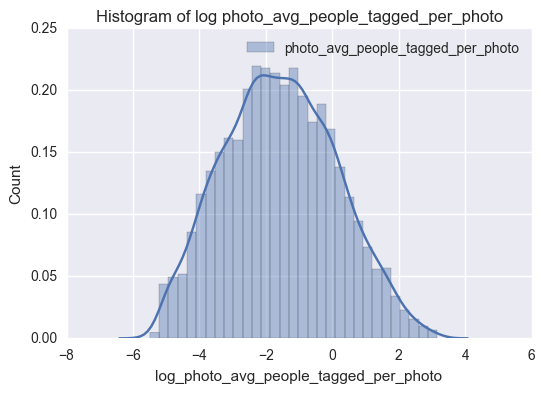

In [26]:
photo_exp_features = ['photo_avg_likes_per_photo', 'photo_avg_comments_per_photo',  'photo_avg_people_tagged_per_photo']
show_log_numric_features(photo_exp_features)

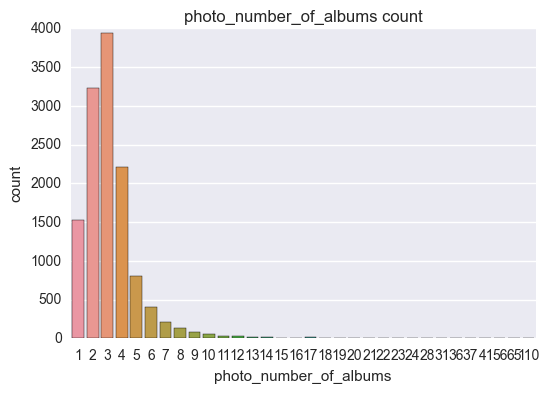

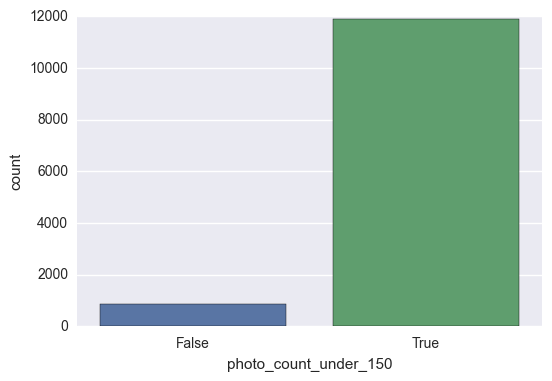

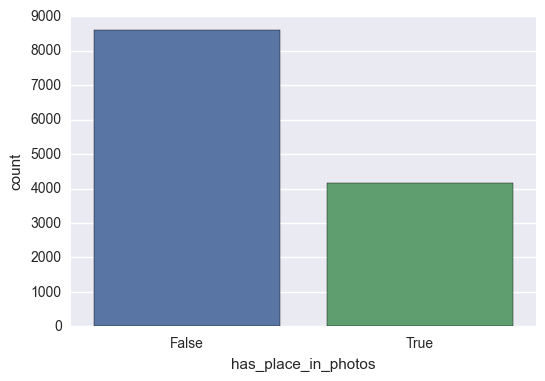

In [27]:
page_categorical_features = ['photo_number_of_albums'] #TODO: add upper bound / move to numrical

show_categorical_features(page_categorical_features)

feat = 'photo_count_under_150'
data = [all_data['total_photos'].apply(lambda x: True if x < 150 else False).to_frame('photo_count_under_150'),
       all_data['photo_count_has_place'].apply(lambda x: True if x > 0 else False).to_frame('has_place_in_photos')]

show_categorical_data(data)
# show_categorical_data(feat, data_to_show)

## Correlations

c:\python27\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


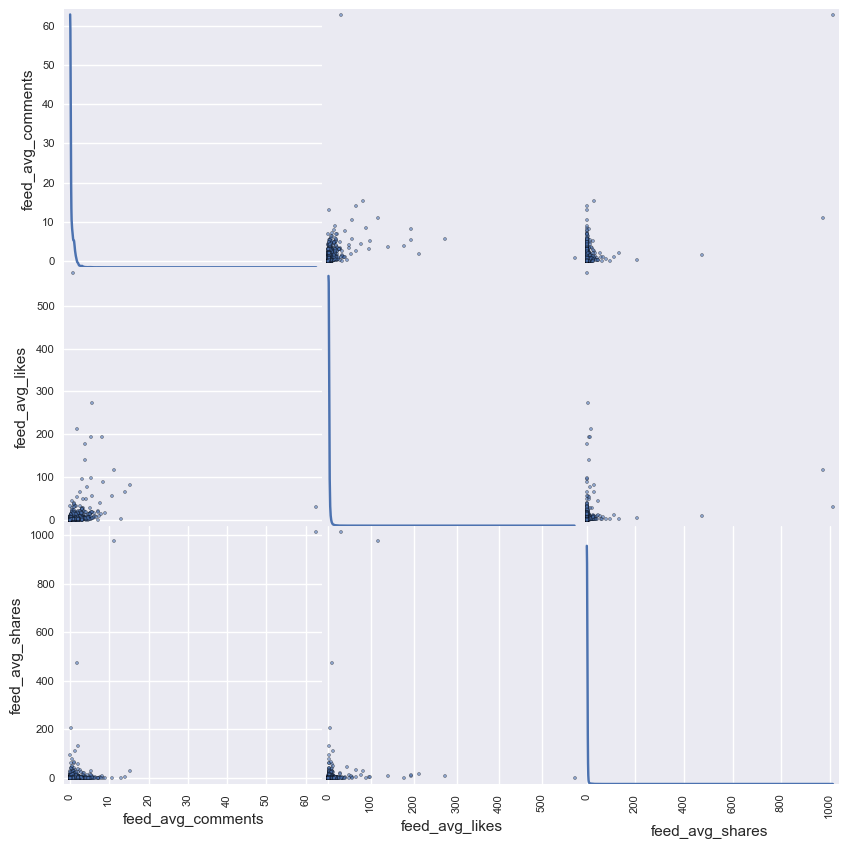

feed_avg_comments  feed_avg_likes  feed_avg_shares
feed_avg_comments               1.00            0.27             0.51
feed_avg_likes                  0.27            1.00             0.14
feed_avg_shares                 0.51            0.14             1.00

In [28]:
interaction_variables = ['likes', 'talking_about_count', 'were_here_count'] #'fanCount', 
photo_tags =['photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero']
feed_tags = ['feed_avg_with_tagged_per_post', 'feed_avg_people_tagged_per_post']
photo_likes = ['photo_max_like', 'photo_min_like', 'photo_avg_likes_per_photo']
feed_interactions = ['feed_avg_comments', 'feed_avg_likes', 'feed_avg_shares']
feed_categories = ['feed_number_of_added_photos_category','feed_number_of_different_months_for_post',
                   'feed_number_of_null_category', 'feed_number_of_other_categories','feed_number_of_shared_story_category']

show_correlation(feed_interactions)
all_data[feed_interactions].corr()
# show_correlation(photo_likes)
# all_data[feed_tags].corr()

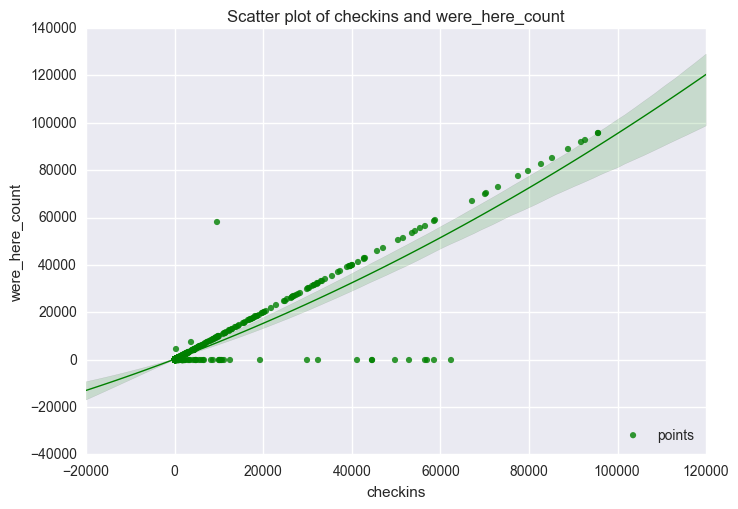

checkins  were_here_count
checkins             1.00             0.48
were_here_count      0.48             1.00

In [29]:
data_to_show = {'checkins':(0,100000), 'were_here_count':(0,100000)} 
show_scatter(data_to_show)

all_data[data_to_show.keys()].corr()

## Likes analysis

count        12,764.00
mean        429,905.08
std       2,216,464.40
min               0.00
25%           9,192.25
50%          38,107.50
75%         172,433.25
max     102,762,547.00
Name: likes, dtype: float64


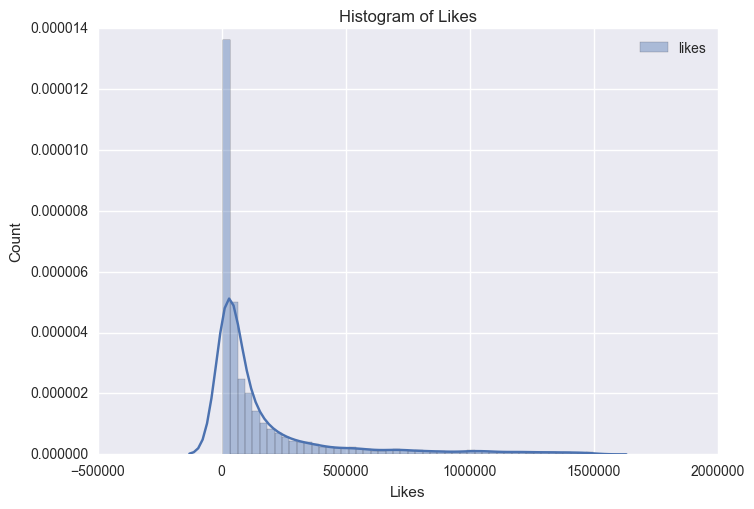

count   12,756.00
mean        10.60
std          2.26
min          0.00
25%          9.13
50%         10.55
75%         12.06
max         18.45
Name: likes, dtype: float64


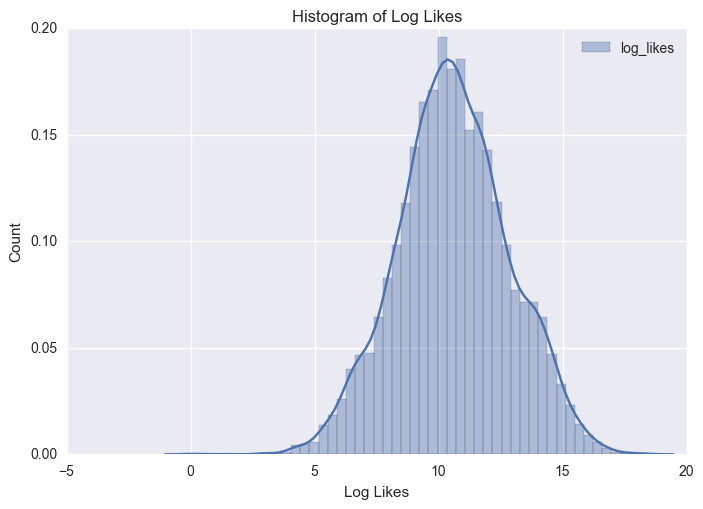

skewness: -0.00136172485706
kurtosis: -0.0225753909844 



In [30]:
print all_data.likes.describe()
sns.distplot(all_data[(all_data['likes'] > 5000) & (all_data['likes'] < 1500000)].likes, 
             bins = 50, kde = True, label = "likes")
plt.title('Histogram of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

log_likes = all_data[all_data['likes'] > 0]['likes'].apply(lambda x: np.log(x))
print log_likes.describe()

sns.distplot(log_likes, bins = 50, kde = True, label = "log_likes")
plt.title('Histogram of Log Likes')
plt.xlabel('Log Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

print "skewness:", log_likes.skew()
print "kurtosis:", log_likes.kurtosis(), '\n'


In [31]:
features = get_features_to_analyze()
corr_features = ['likes'] + get_features_to_analyze()

pearson_corrs = all_data[corr_features].corr(method="pearson")['likes'].sort_values(ascending=False)
spearman_corrs = all_data[corr_features].corr(method="spearman")['likes'].sort_values(ascending=False)

print "top correlation to likes using pearson estimator:"
print "================================================="
print pearson_corrs[1:11]

print "\ntop correlation to likes using spearman estimator:"
print "=================================================="
print spearman_corrs[1:11]

top correlation to likes using pearson estimator:
self_feed_avg_likes            0.52
photo_max_like                 0.51
photo_avg_likes_per_photo      0.50
self_feed_std_likes            0.46
self_feed_max_likes            0.42
photo_avg_comments_per_photo   0.36
talking_about_count            0.29
is_verified                    0.29
were_here_count                0.28
self_feed_max_comments         0.27
Name: likes, dtype: float64

top correlation to likes using spearman estimator:
talking_about_count         0.76
self_feed_avg_likes         0.71
photo_max_like              0.69
self_feed_max_likes         0.68
self_feed_std_likes         0.68
photo_avg_likes_per_photo   0.67
self_feed_avg_comments      0.66
total_photos                0.65
self_feed_max_comments      0.64
self_feed_std_comments      0.64
Name: likes, dtype: float64


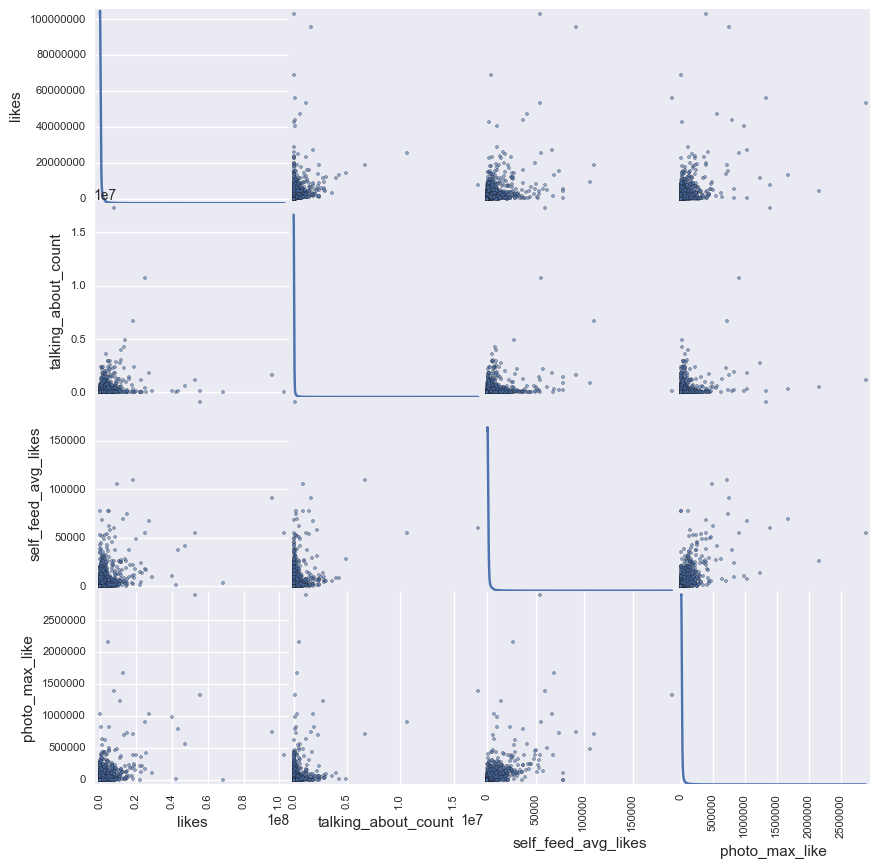

likes  talking_about_count  self_feed_avg_likes  \
likes                 1.00                 0.29                 0.52   
talking_about_count   0.29                 1.00                 0.35   
self_feed_avg_likes   0.52                 0.35                 1.00   
photo_max_like        0.51                 0.37                 0.63   

                     photo_max_like  
likes                          0.51  
talking_about_count            0.37  
self_feed_avg_likes            0.63  
photo_max_like                 1.00

In [32]:
corr_features = ['likes'] + [a for a in spearman_corrs.index.values[1:4]]
show_correlation(corr_features)
all_data[corr_features].corr()

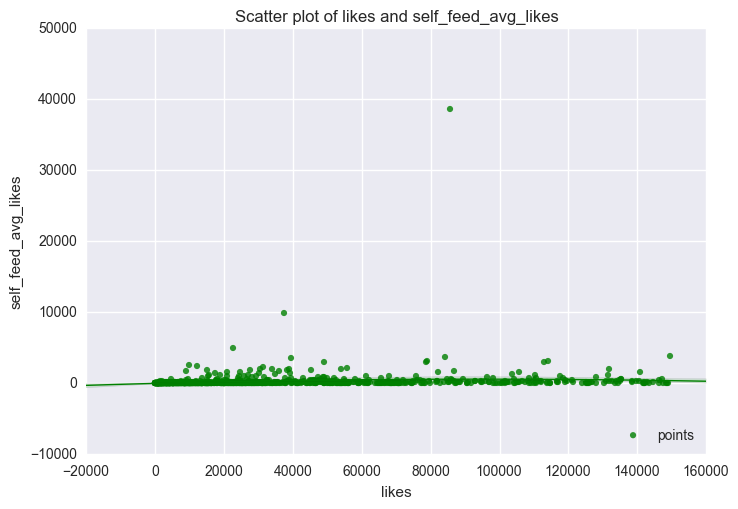

self_feed_avg_likes  likes
self_feed_avg_likes                 1.00   0.52
likes                               0.52   1.00

In [33]:
data_to_show = {'self_feed_avg_likes':(0,np.inf), 'likes':(0,150000)} 
show_scatter(data_to_show,op=1)
all_data[data_to_show.keys()].corr()

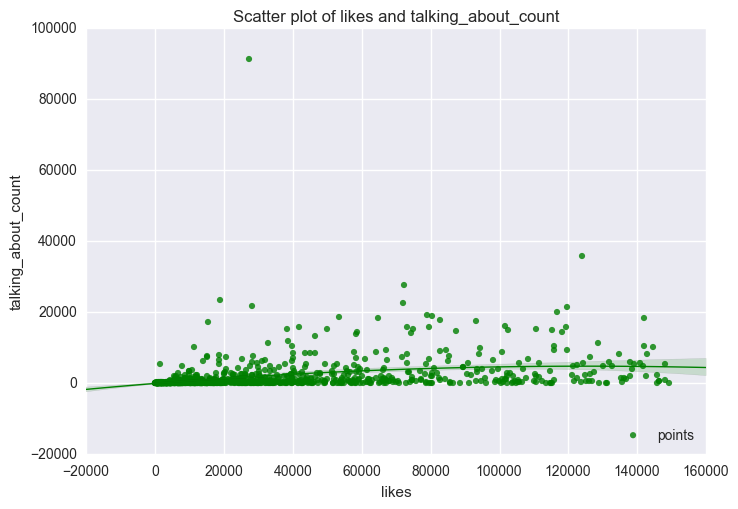

talking_about_count  likes
talking_about_count                 1.00   0.29
likes                               0.29   1.00

In [34]:
data_to_show = {'talking_about_count':(1,100000), 'likes':(0,150000)} 
show_scatter(data_to_show,op=1)
all_data[data_to_show.keys()].corr()

In [35]:
avg_likes_per_category = all_data.groupby(['search_category'], as_index=False).mean()[['search_category','likes']].sort_values('likes', ascending=False)
avg_likes_per_category.rename(columns={'likes':'avg_likes'}, inplace=True)
avg_likes_per_category.head(5)

search_category    avg_likes
19           Movie 1,618,208.58
13             Foo 1,575,577.71
29              TV 1,290,613.54
1              Bar 1,284,507.66
3        Beverages 1,274,734.64

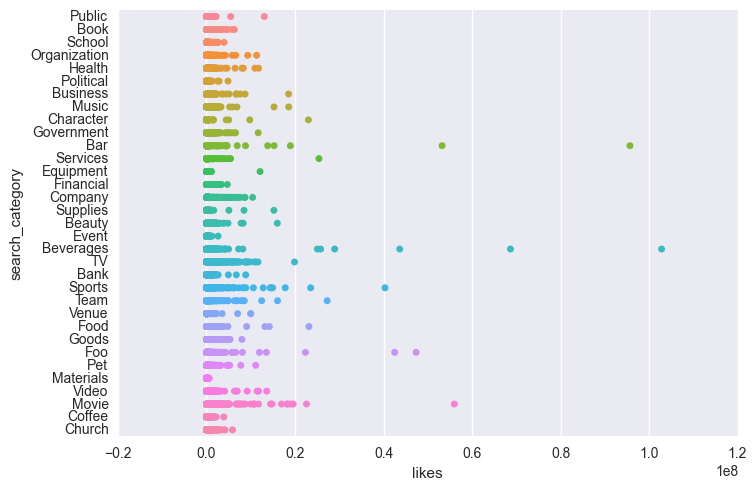

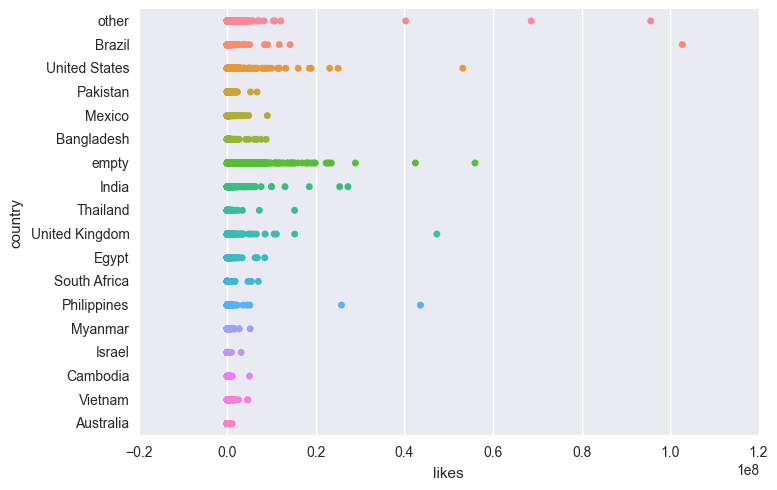

In [36]:
sns.stripplot(x="likes", y="search_category", data=all_data)
plt.show()
sns.stripplot(x="likes", y="country", data=all_data)
plt.show()

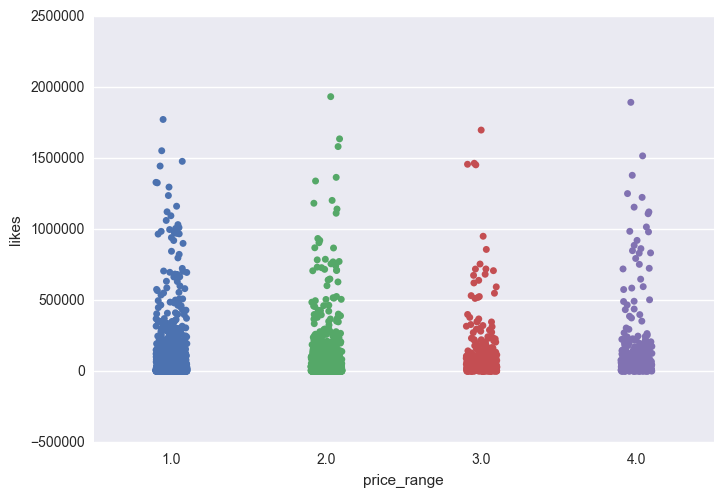

In [37]:
data_to_show = all_data[(all_data['likes'] > 0) & (all_data['likes'] < 2000000)]
price_data = data_to_show[(data_to_show['price_range'] > 0)]
sns.stripplot(x="price_range", y="likes", data=price_data, jitter=True)
plt.show()

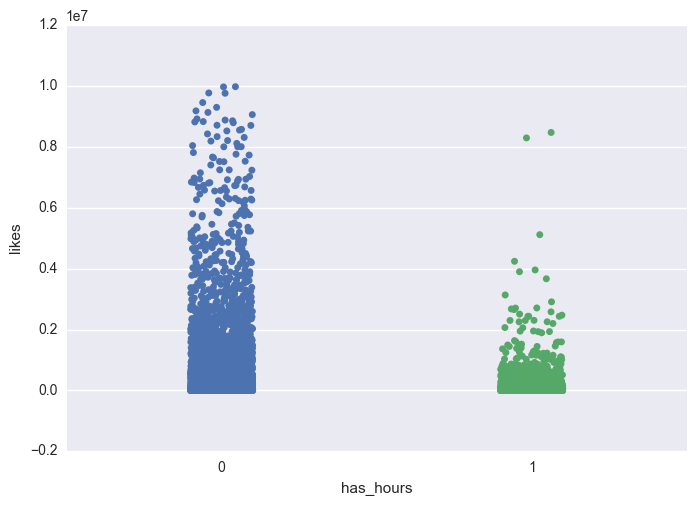

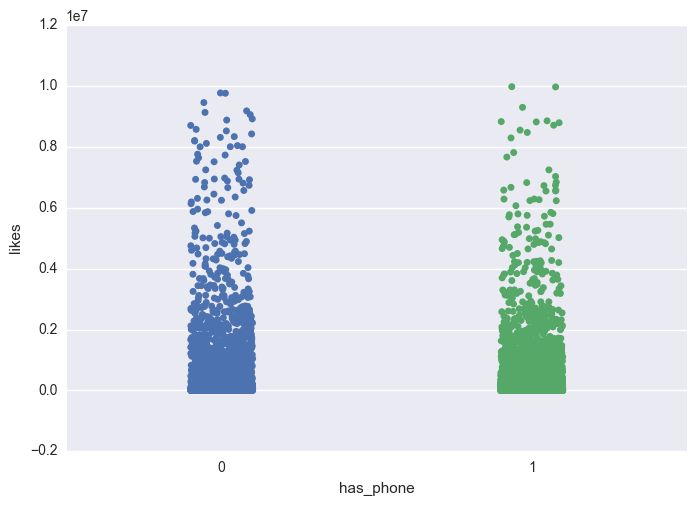

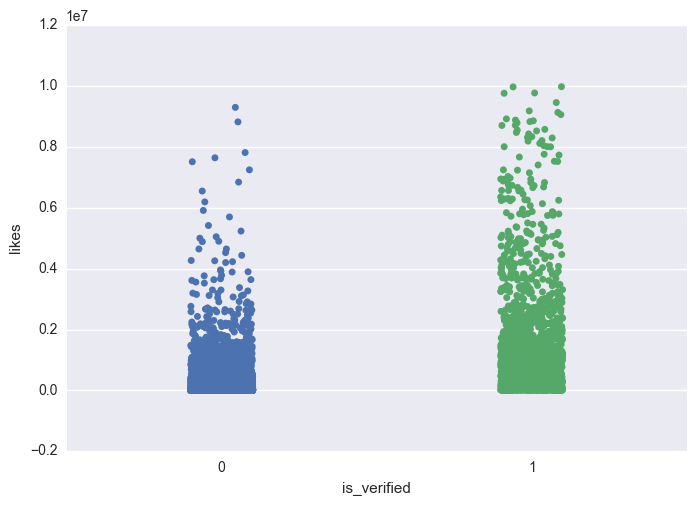

In [38]:
data_to_show = all_data[(all_data['likes'] > 0) & (all_data['likes'] < 10000000)]

sns.stripplot(x="has_hours", y="likes", data=data_to_show, jitter=True)
plt.show()
sns.stripplot(x="has_phone", y="likes", data=data_to_show, jitter=True)
plt.show()
sns.stripplot(x="is_verified", y="likes", data=data_to_show, jitter=True)
plt.show()

# sns.stripplot(x="has_hours", y="likes", data=data_to_show, hue="has_phone", jitter=True)
# plt.show()

## Manual data normalization

In [39]:
normal_by_total_count_vars = [  ['photo_number_of_cover_albums', 'photo_number_of_albums'],
                                ['photo_number_of_other_albums', 'photo_number_of_albums'],
                                ['photo_number_of_profile_albums', 'photo_number_of_albums'],
                                ['photo_number_of_photos_in_cover_albums', 'total_photos'],
                                ['photo_number_of_photos_in_profile_albums', 'total_photos'],
                                ['photo_count_has_name', 'total_photos'],
                                ['photo_count_has_place', 'total_photos'],
                                ['feed_count_has_place', 'feed_post_count'],
                                ['feed_count_post_updated', 'feed_post_count'],
                                ['feed_number_of_added_photos_category', 'feed_post_count'],
                                ['feed_number_of_different_months_for_post', 'feed_post_count'],
                                ['feed_number_of_other_categories', 'feed_post_count'],
                                ['feed_number_of_shared_story_category', 'feed_post_count'],
                                ['self_feed_count_has_place', 'self_post_count'],
                                ['self_feed_count_post_updated', 'self_post_count'],
                                ['self_feed_number_of_added_photos_category', 'self_post_count'],
                                ['self_feed_number_of_different_months_for_post', 'self_post_count'],
                                ['self_feed_number_of_null_category', 'self_post_count'],
                                ['self_feed_number_of_other_categories', 'self_post_count'],
                                ['self_feed_number_of_shared_story_category', 'self_post_count']
                             ]

for feat in normal_by_total_count_vars: 
    all_data[feat[0]] = all_data.apply(lambda x: (x[feat[0]] / x[feat[1]]) if (x[feat[1]] != 0) else 0, axis=1)
    
# originally the api calls to facebook were supposed to get the first 150 photos/feed posts of a page.
# along the way we got a little more in some cases, so after normalization of the relevant features by this count, 
# we lower them to 150 to prevent bias..
all_data['total_photos'] = all_data['total_photos'].apply(lambda x: x if x <= 150 else 150)
all_data['feed_post_count'] = all_data['feed_post_count'].apply(lambda x: x if x <= 150 else 150)
all_data['self_post_count'] = all_data['self_post_count'].apply(lambda x: x if x <= 150 else 150)

# Models

## Utils

In [40]:
def binning(col,bin_num, labels=None):
    if labels is None:
        labels = ['BIN_'+str(i) for i in range(bin_num)]

    colBin = pd.qcut(col,bin_num,labels=labels)
    return colBin

def plot_results(x, y, tag, arg):
    plt.plot(x, y)
    plt.title(tag + " as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel(tag)
    plt.show()

def plot_cross_val(cs, cv_scores, arg):
    plt.plot(cs, cv_scores)
    plt.title("Average Precision as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel("Precision")
    ax = plt.axes()
    ax.set_xscale('log')
    plt.show()

def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def plotMetrics(expected,predicted):
    y_true = expected
    y_score = predicted
    #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
    auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    plotRoc(fpr, tpr, auc)
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
    plotPR(precision, recall)

def plotConfusion(matrix, n, model_name=''):
    plt.title(model_name + ' Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.imshow(np.reshape(matrix, (n, n)), interpolation='nearest', cmap="hot")
    plt.colorbar()
    plt.show()
        
def _log(x):
    if x > 0:
        return np.log(x)
    return x  

def remove_outliers(ds, feat, stdv_cut):
    if feat == 'likes':
        ds['log_' + feat] = ds[feat].apply(_log)
        ds = ds[abs(ds['log_' + feat] - ds['log_' + feat].mean()) <= stdv_cut*ds['log_' + feat].std()]
        ds.drop('log_' + feat, 1, inplace=True)
    else:
        ds = ds[abs(ds[feat] - ds[feat].mean()) <= stdv_cut*ds[feat].std()]
    return ds

def get_feat_sel(train_set, test_set, train_labels, test_labels, model, min_feats=30, verbose=False):
    all_feats = train_set.columns.values.tolist()
    numerical_feats = [feat for feat in all_feats if set(train_set[feat].unique()) != {-1,1} and feat not in ['id']]

    # feature selection
    results = []
    feats_num = train_set.shape[1]
    threshold = 0.0000001
    while feats_num > min_feats:
        model.fit(train_set, train_labels)
        sfm = SelectFromModel(model, prefit=True, threshold=threshold)
        if len(sfm.get_support(indices=True)) == feats_num:
            threshold = threshold*10
        else:
            feats_num = len(sfm.get_support(indices=True))
            threshold = threshold*1.5

        if feats_num <= train_set.shape[1] * 0.8:
            if verbose: print "get_data_sets: found threshold %s that selected %s feats" % (threshold, feats_num)

            feats_idx_list = list(sfm.get_support(indices=True))
            # re-fit model to score new data set
            new_train_set = sfm.transform(train_set)
            new_test_set = sfm.transform(test_set)
            model.fit(new_train_set, train_labels)

            result = {
                'feats_num': feats_num,
                'threshold': threshold,
                'selected_idx': feats_idx_list,
                'selected_feats': [all_feats[i] for i in feats_idx_list],
                'test_score': model.score(new_test_set, test_labels),
                'train_score': model.score(new_train_set, train_labels),
            }
            results.append(result)
    
    return sorted(results, key=lambda x: x['test_score'], reverse=True)

def bins_to_binary(labels, sel_bin, is_1_vs_all=False):
    if is_1_vs_all:
        result = labels.apply(lambda x: x == sel_bin)
    else:
        result = labels.apply(lambda x: int(x[-1]) <= int(sel_bin[-1]))
    return result

def calculate_confusion_matrix_score(matrix, num_bins_away):
    d=len(matrix)
    precisions = []
    recalls = []
    f1_scores = []
    for i in range(d):
        row_precision = 0
        for j in range(i-num_bins_away,i+num_bins_away+1):
            if j>=0 and j<d:
                row_precision+=matrix[i][j]
        precision_float = float(row_precision)/sum(matrix[i])
        recall_float = float(row_precision)/sum([row[i] for row in matrix])
        
        precisions.append(precision_float) 
        recalls.append(recall_float) 
        f1_scores.append(2 * (precision_float * recall_float) / (precision_float + recall_float))
    
    avg_precisions = np.mean(precisions)
    avg_recalls = np.mean(recalls)
    avg_f1_score = np.mean(f1_scores)

    return avg_precisions, avg_recalls, avg_f1_score

def eval_model(model_name, labels, predictions, predicted_probs, is_val=False, bin_num=8, is_test=False):
    data_type = "validation" if is_val else "train"
    if is_test:
        data_type = "test"
    print str.upper("%s %s results" % (model_name, data_type))
    print "=========" + "=" * len(model_name + data_type)
    
    print "\nClassification report:"
    print metrics.classification_report(labels, predictions)
    
    if (bin_num == 2):
        plotMetrics(labels,predicted_probs)
        fpr, tpr, thresholds = metrics.roc_curve(labels, predicted_probs)
        auc = metrics.auc(fpr, tpr)
        print "%s %s set auc: %s" % (model_name, data_type, auc)
        plotRoc(fpr, tpr, auc)
    
    print "\nConfusion matrix with %s bins: " % bin_num
    cm = confusion_matrix(labels.values, predictions)
    print cm
    plotConfusion(cm, bin_num, model_name)

    final_score = metrics.f1_score(labels, predictions, average='micro')
    print "\n%s %s f1-score:%s" % (model_name, data_type, final_score)
    if bin_num == 8:
        precision, recall, f1_score = calculate_confusion_matrix_score(cm, 1)
        print '\n=================='
        print '1-Bin-Away scores:'
        print '=================='
        print 'Avg Precision: %s\nAvg Recall: %s\nAvg f1-score: %s' % (precision, recall, f1_score)
    
    return final_score

    
def grubbs_outlier_removal(data_set, feats, verbose=False):
    ds = data_set.copy()
    total_diff = 0
    
    if verbose: print "\ngrubbs_outlier_removal: Got %s feats to remove outliers by. STARTING...\n" % len(feats)
    for feat in feats:
        temp = ds.shape[0]
        alpha = 0.05
        idxs = grubbs.two_sided_test_indices(ds[feat], alpha=alpha)
        while len(idxs) > 100:
            if alpha < 0.02:
                # feature distribution is probably not normal, skip
                idxs = []
                break
            alpha = alpha / 2
            idxs = grubbs.two_sided_test_indices(ds[feat], alpha=alpha)
        ds.drop(ds.index[idxs], inplace=True)
        if len(idxs) > 0 and verbose: print "grubbs_outlier_removal: feat %s - %s samples removed, %s samples left" % (feat, len(idxs), ds.shape[0])
        total_diff += temp - ds.shape[0]

    if verbose: print "grubbs_outlier_removal: Total of %s samples removed, %s samples left" % (total_diff, ds.shape[0])
    return ds


## General Preprocessing

### dummies variables 

In [41]:
# change back empty and 0 to NaN before converting to dummy variables
categorical_variables = ['country', 'price_range', 'main_category', 'search_category', 'category', 'continent']
filtered_all_data = all_data.copy()
# country_dv = pd.get_dummies(filtered_all_data['country'].apply(lambda x: x if x != 'empty' else np.nan), prefix='country')
price_dv = pd.get_dummies(filtered_all_data['price_range'].apply(lambda x: x if x > 0 else np.nan), prefix='price_range')
category_dv = pd.get_dummies(filtered_all_data['main_category'], prefix='main_category')
continent_dv = pd.get_dummies(filtered_all_data['continent'], prefix='continent')

print "shape before dummy vars: ", filtered_all_data.shape
pp_data = pd.concat([filtered_all_data, price_dv, category_dv, continent_dv], axis=1)
pp_data.drop(categorical_variables, 1, inplace=True)
print "shape after dummy vars: ", pp_data.shape

shape before dummy vars:  (12764, 103)
shape after dummy vars:  (12764, 113)


### Data Normalization - run log on numerical features and scale

In [42]:
cat_vars = [feat for feat in pp_data.columns.values.tolist() if set(pp_data[feat].unique()) == {0,1}]
pp_data[cat_vars] = pp_data[cat_vars].astype(bool)
for feat in cat_vars:
    pp_data[feat] = pp_data[feat].apply(lambda x: 1 if x else -1)
    
exp_feats = [feat for feat in pp_data.columns.get_values().tolist() if set(pp_data[feat].unique()) != {-1,1} and feat not in ['id', 'name_num_of_words', 'likes', 'labels']]
for feat in exp_feats:
    pp_data[feat] = pp_data[feat].apply(_log)
    max_val = pp_data[feat].max()
    pp_data[feat] = preprocessing.scale(pp_data[feat].apply(lambda x: -max_val if x == 0 else x))
    

### Split data to test and train/validation sets

In [43]:
from sklearn.utils import shuffle

pp_data = shuffle(pp_data)
pp_data['4_bin_labels'] = binning(pp_data['likes'], 4)
pp_data['8_bin_labels'] = binning(pp_data['likes'], 8)

test_data_len = int(pp_data.shape[0] * 0.1)
test_pp_data = pp_data[:test_data_len]

test_data_ids = test_pp_data['id'].copy()
test_data_labels = test_pp_data[['likes', '4_bin_labels', '8_bin_labels']].copy()
test_data_set = test_pp_data.drop(['id', 'likes', '4_bin_labels', '8_bin_labels'], axis=1)

pp_data = pp_data[test_data_len:]

### Initial outlier removal

In [44]:
temp = pp_data.shape[0]
pp_data = pp_data[pp_data['likes'] > 0]
pp_data = remove_outliers(pp_data, 'likes', 2)

print "Initial data removal (2*stdv) - %s samples removed, %s samples left" % (temp - pp_data.shape[0], pp_data.shape[0])

Initial data removal (2*stdv) - 520 samples removed, 10968 samples left


c:\python27\lib\site-packages\ipykernel\__main__.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
pp_data[pp_data['likes'] < 10]['likes']

Series([], Name: likes, dtype: int64)

### Split data set to train and validation data

In [46]:
train_len = int(pp_data.shape[0] * 0.8)

train_ids = pp_data['id'][:train_len].copy()
val_ids = pp_data['id'][train_len:].copy()

train_labels = pp_data[['likes', '4_bin_labels', '8_bin_labels']][:train_len].copy()
val_labels = pp_data[['likes', '4_bin_labels', '8_bin_labels']][train_len:].copy()

temp_pp_data = pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
train_set = temp_pp_data[:train_len].copy()
val_set = temp_pp_data[train_len:].copy()

print "4-Bin Details:"
print pp_data.groupby('4_bin_labels')['likes'].describe()
print "8-Bin Details:"
print pp_data.groupby('8_bin_labels')['likes'].describe()

4-Bin Details:
4_bin_labels       
BIN_0         count       2,630.00
              mean        3,935.28
              std         2,557.84
              min           435.00
              25%         1,658.50
              50%         3,485.50
              75%         5,941.75
              max         9,187.00
BIN_1         count       2,871.00
              mean       20,750.65
              std         8,226.26
              min         9,194.00
              25%        13,418.00
              50%        19,526.00
              75%        27,486.50
              max        38,101.00
BIN_2         count       2,866.00
              mean       86,203.55
              std        37,912.56
              min        38,114.00
              25%        52,995.00
              50%        76,846.50
              75%       114,134.25
              max       172,365.00
BIN_3         count       2,601.00
              mean      836,866.84
              std       751,864.32
              min   

### Test feature selection on Logistic Regression (sanity)

In [47]:
temp_train_labels = bins_to_binary(train_labels['4_bin_labels'], 'BIN_1') 
temp_val_labels = bins_to_binary(val_labels['4_bin_labels'], 'BIN_1') 

print "Logistic regression feature selection by importance:"
lr = lm.LogisticRegression(penalty='l2', C=0.01) #dual=True)
lr.fit(train_set, temp_train_labels)
print "Train set score (before selection): ", lr.score(train_set, temp_train_labels)
print "Validation set score (before selection): ", lr.score(val_set, temp_val_labels)

sfm = SelectFromModel(lr, prefit=True)

selected_feats = sfm.get_support(indices=True)
print "total of %s out of %s feats left:" % (len(selected_feats), len(train_set.columns.get_values()))
for feat_idx in selected_feats:
    print "%s\t%s" % (feat_idx, train_set.columns.get_values()[feat_idx])

new_train = sfm.transform(train_set)
new_test = sfm.transform(val_set)
lr.fit(new_train, temp_train_labels)
print "Train set score (after selection): ", lr.score(new_train, temp_train_labels)
print "Validation set score (after selection): ",  lr.score(new_test, temp_val_labels)

Logistic regression feature selection by importance:
Train set score (before selection):  0.839183952587
Validation set score (before selection):  0.832725615314
total of 39 out of 111 feats left:
3	has_company_overview
4	has_about
5	has_hours
6	checkins
7	has_payment_options
11	photo_avg_likes_per_photo
16	photo_max_like
17	photo_max_people_tagged
21	photo_number_of_different_months_for_photos
22	photo_number_of_other_albums
26	total_photos
27	photo_number_of_days_between_first_and_last_photos
45	feed_post_max_with_tagged
47	feed_std_likes
51	feed_post_count
52	self_feed_avg_comments
53	self_feed_avg_likes
54	self_feed_avg_likes_per_comment
57	self_feed_number_of_days_between_first_and_last_posts
60	self_feed_count_post_updated
64	self_feed_min_likes
69	self_feed_number_of_shared_story_category
72	self_feed_post_updated_prc
74	self_feed_std_likes
77	self_feed_min_shares
80	is_verified
81	talking_about_count
82	were_here_count
84	has_phone
85	has_website
86	has_location
89	has_products

## Logistic Regression - Binary model

#### Get binary predictions from LR to be used as features for the multi class models

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   40.2s finished


Best estimator found by grid search:
LogisticRegression(C=0.21544346900318845, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
training logistic regression
getting logistic regression predictions (bin num 0)
LR BINARY PREDICTION - BIN_0: VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      False       0.89      0.93      0.91      1634
       True       0.77      0.65      0.70       560

avg / total       0.85      0.86      0.86      2194



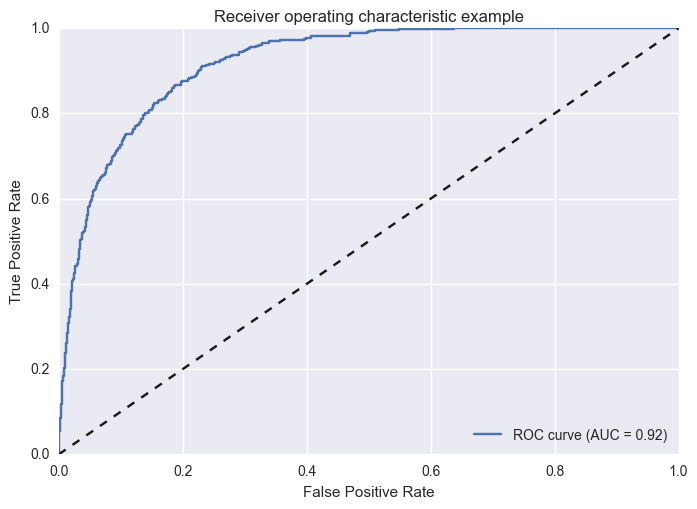

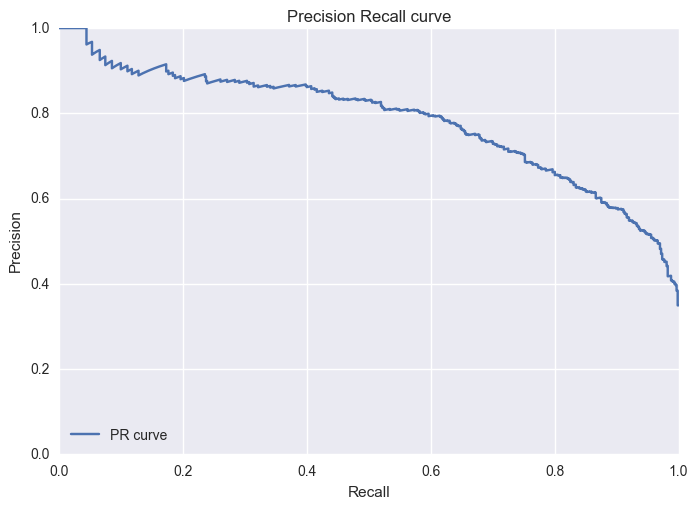

LR binary prediction - BIN_0: validation set auc: 0.918978405316


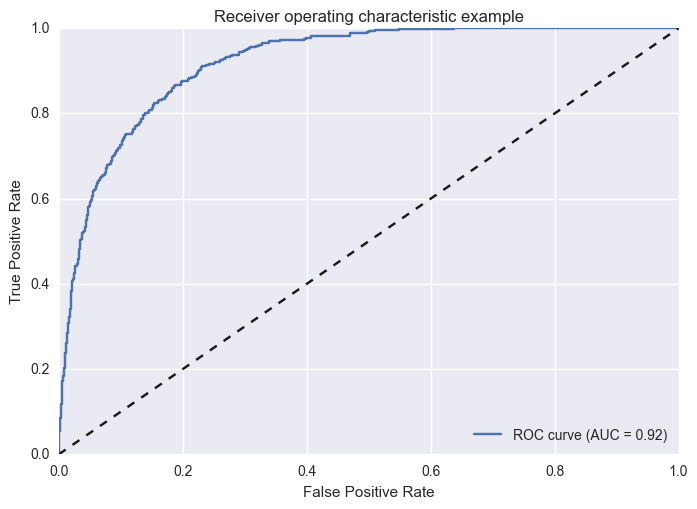


Confusion matrix with 2 bins: 
[[1523  111]
 [ 197  363]]


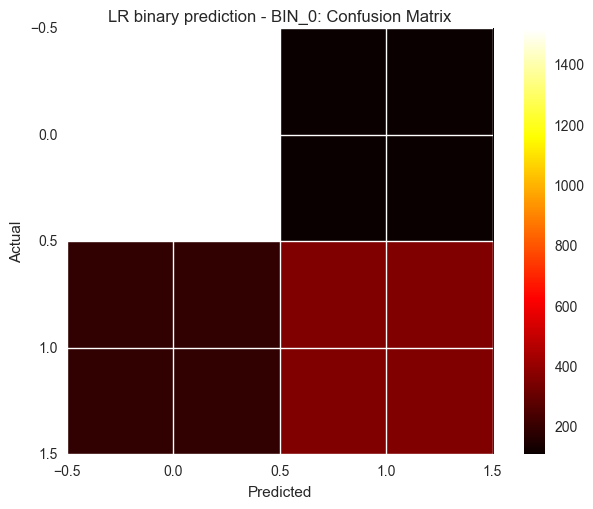


LR binary prediction - BIN_0: validation f1-score:0.859617137648
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.7s finished


Best estimator found by grid search:
LogisticRegression(C=7.7426368268112693, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
training logistic regression
getting logistic regression predictions (bin num 1)
LR BINARY PREDICTION - BIN_1: VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      False       0.84      0.82      0.83      1080
       True       0.83      0.85      0.84      1114

avg / total       0.83      0.83      0.83      2194



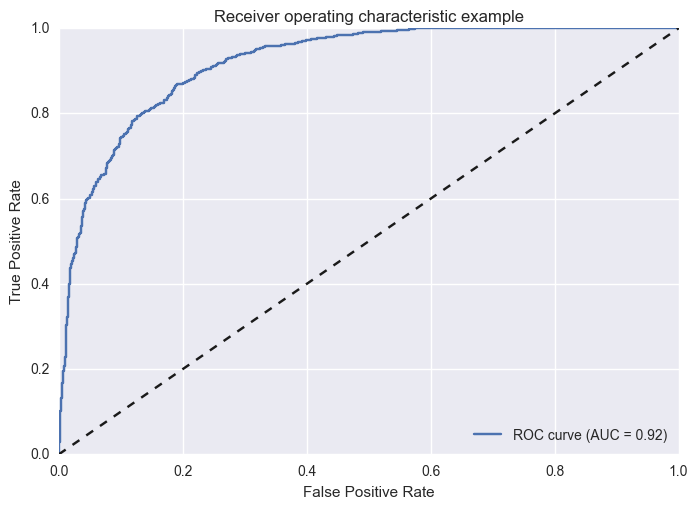

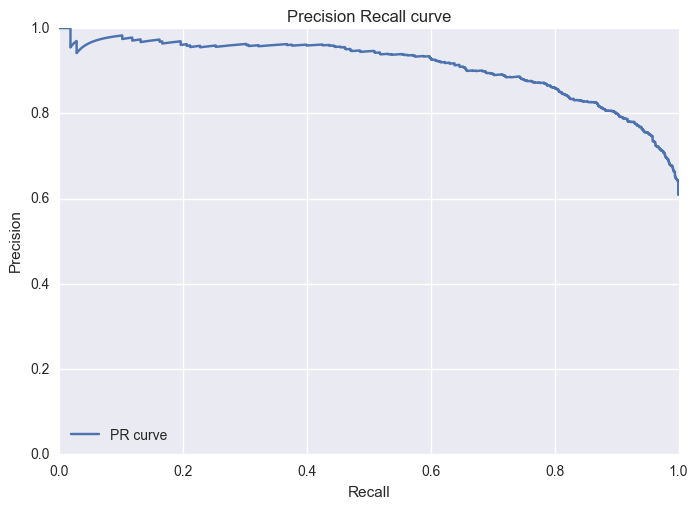

LR binary prediction - BIN_1: validation set auc: 0.919638938759


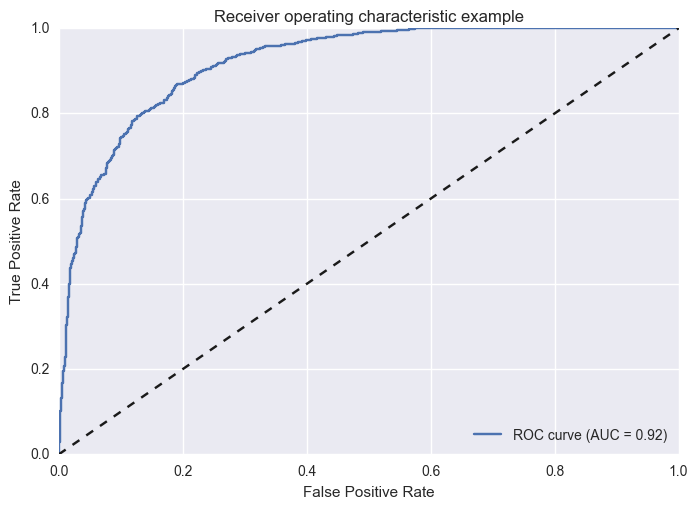


Confusion matrix with 2 bins: 
[[884 196]
 [171 943]]


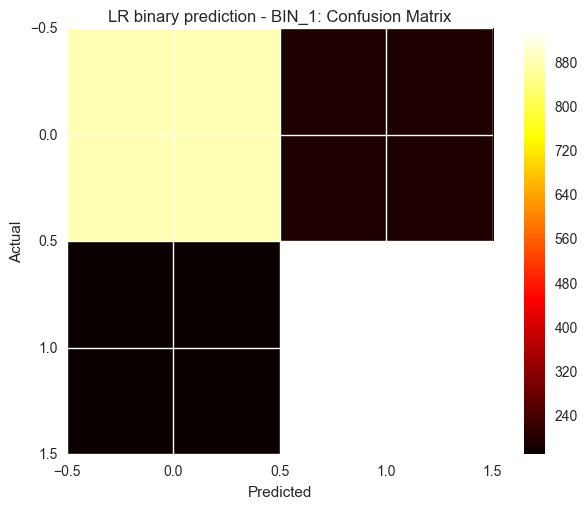


LR binary prediction - BIN_1: validation f1-score:0.832725615314
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   28.1s finished


Best estimator found by grid search:
LogisticRegression(C=0.035938136638046278, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
training logistic regression
getting logistic regression predictions (bin num 2)
LR BINARY PREDICTION - BIN_2: VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      False       0.84      0.72      0.77       514
       True       0.92      0.96      0.94      1680

avg / total       0.90      0.90      0.90      2194



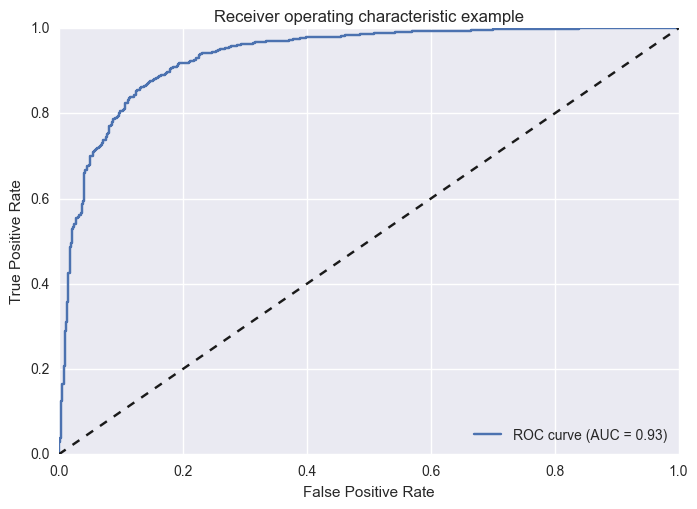

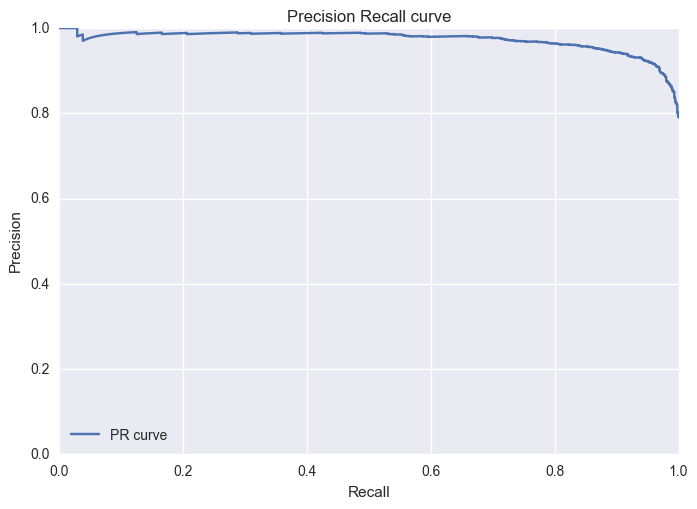

LR binary prediction - BIN_2: validation set auc: 0.93468362053


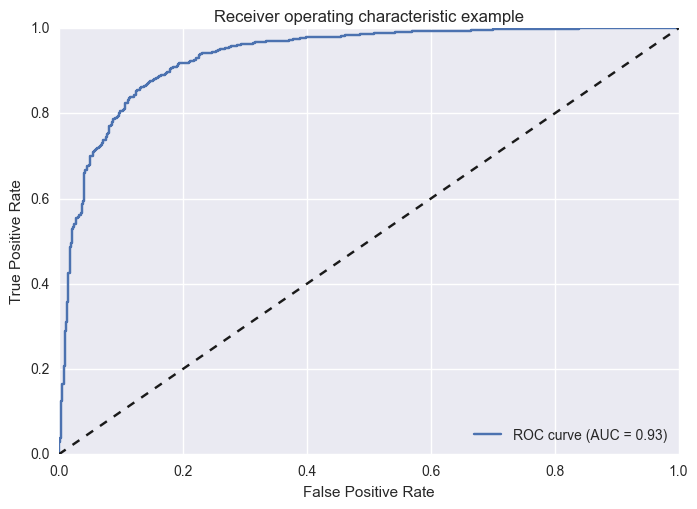


Confusion matrix with 2 bins: 
[[ 368  146]
 [  72 1608]]


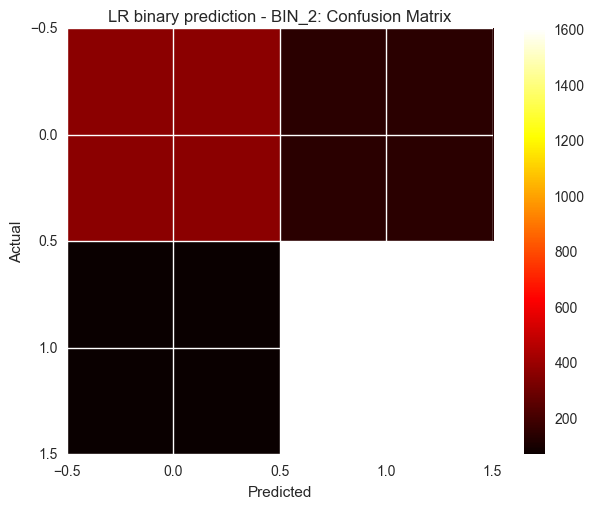


LR binary prediction - BIN_2: validation f1-score:0.90063810392


In [48]:
predictions_ds = pp_data['id'].copy()
test_predictions_ds = test_pp_data['id'].copy()

lr_train_set = train_set.copy()
lr_val_set = val_set.copy()

for seperator in range(3):
    lr_train_labels = bins_to_binary(train_labels['4_bin_labels'], 'BIN_%s' % seperator)
    lr_val_labels = bins_to_binary(val_labels['4_bin_labels'], 'BIN_%s' % seperator)
    
    param_grid = {'C': np.logspace(-3, 4, num=10)}
    clf = GridSearchCV(lm.LogisticRegression(), param_grid, verbose=True)
    clf = clf.fit(lr_train_set, lr_train_labels)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print "training logistic regression"
    lr = clf.best_estimator_
    lr.fit(lr_train_set, lr_train_labels)

    print "getting logistic regression predictions (bin num %s)" % seperator
    lr_predicted_probs = lr.predict_proba(lr_train_set.append(lr_val_set, ignore_index=True))[:, 1]
    lr_predictions = lr.predict(lr_train_set.append(lr_val_set, ignore_index=True))

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_set.shape[0]]
    lr_val_predicted_probs = lr_predicted_probs[lr_train_set.shape[0]:]

    lr_train_predictions = lr_predictions[:lr_train_set.shape[0]]
    lr_val_predictions = lr_predictions[lr_train_set.shape[0]:]
    
    eval_model("LR binary prediction - BIN_%s:" % seperator, lr_val_labels, lr_val_predictions, lr_val_predicted_probs, True, 2)
    
    # attach LR predictions to predictions_ds
    predictions_ds['lr_prediction_proba_%s' % seperator] = preprocessing.minmax_scale(lr_predicted_probs.copy(), feature_range=(-1, 1))
    test_predictions_ds['lr_prediction_proba_%s' % seperator] = preprocessing.minmax_scale(lr.predict_proba(test_data_set)[:, 1], feature_range=(-1, 1))

### Attach new features to data sets

In [49]:
pp_data['lr_predict_0'] = predictions_ds['lr_prediction_proba_0'].copy()
pp_data['lr_predict_1'] = predictions_ds['lr_prediction_proba_1'].copy()
pp_data['lr_predict_2'] = predictions_ds['lr_prediction_proba_2'].copy()

test_pp_data['lr_predict_0'] = test_predictions_ds['lr_prediction_proba_0'].copy()
test_pp_data['lr_predict_1'] = test_predictions_ds['lr_prediction_proba_1'].copy()
test_pp_data['lr_predict_2'] = test_predictions_ds['lr_prediction_proba_2'].copy()

new_feats = ['lr_predict_0', 'lr_predict_1', 'lr_predict_2']
train_set[new_feats] = pp_data[new_feats][:train_len].copy()
val_set[new_feats] = pp_data[new_feats][train_len:].copy()
test_data_set[new_feats] = test_pp_data[new_feats].copy()

## Linear Regression - Numerical prediction

#### Get numerical predictions from Linear Regression to be used as a feature for the multi class models



Mean squared error: 1.01
training variance score: 0.75
test variance score: 0.74


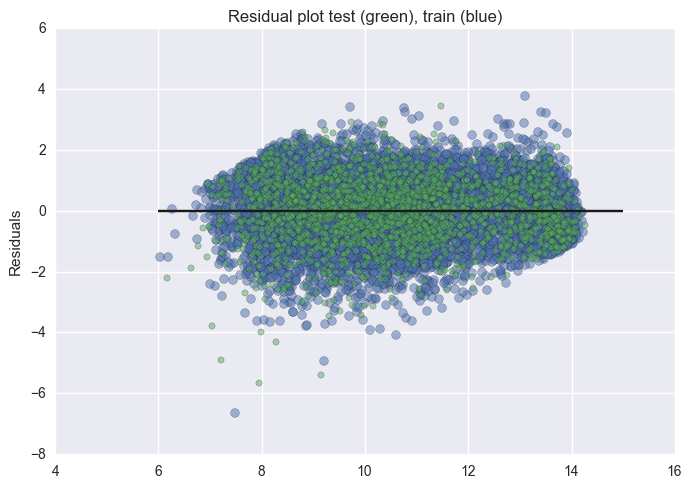

In [50]:
linr_train_set = train_set.copy()
linr_val_set = val_set.copy()

linr_train_labels = train_labels['likes'].apply(_log)
linr_val_labels = val_labels['likes'].apply(_log)

linr = sklearn.linear_model.LinearRegression()
linr.fit(linr_train_set, linr_train_labels)

train_predictions = linr.predict(linr_train_set)
val_predictions = linr.predict(linr_val_set)

predictions_ds['linr_prediction'] = preprocessing.minmax_scale(np.concatenate((train_predictions, val_predictions)), feature_range=(-1, 1))
test_predictions_ds['linr_prediction'] = preprocessing.minmax_scale(linr.predict(test_data_set), feature_range=(-1, 1))

# The mean squared error
print "\n\nMean squared error: %.2f" %(np.mean((linr.predict(linr_train_set) - linr_train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print 'training variance score: %.2f' %(linr.score(linr_train_set, linr_train_labels))
print 'test variance score: %.2f' %(linr.score(linr_val_set, linr_val_labels))
plt.scatter(train_predictions, train_predictions -  linr_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(val_predictions, val_predictions -  linr_val_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=6, xmax=15)
plt.title('Residual plot test (green), train (blue)')
plt.ylabel('Residuals')
plt.show()

### Attach new feature to data sets

In [51]:
pp_data['linr_predict'] = predictions_ds['linr_prediction'].copy()

test_pp_data['linr_predict'] = test_predictions_ds['linr_prediction'].copy()

new_feats.append('linr_predict')
train_set[new_feats] = pp_data[new_feats][:train_len].copy()
val_set[new_feats] = pp_data[new_feats][train_len:].copy()
test_data_set[new_feats] = test_pp_data[new_feats].copy()

## KNN

### Data preparation

In [52]:
knn_train_set = train_set.drop(new_feats, 1)
knn_val_set = val_set.drop(new_feats, 1)

knn_train_labels = train_labels['4_bin_labels'].copy()
knn_val_labels = val_labels['4_bin_labels'].copy()

### Parameter optimization

validation score for k = 2:  0.481312670921
validation score for k = 12:  0.543299908842
validation score for k = 22:  0.55742935278
validation score for k = 32:  0.558340929809
validation score for k = 42:  0.558796718323
validation score for k = 52:  0.56289881495
validation score for k = 62:  0.566545123063
validation score for k = 72:  0.565633546035
validation score for k = 82:  0.563810391978
validation score for k = 92:  0.56289881495
validation score for k = 102:  0.560619872379


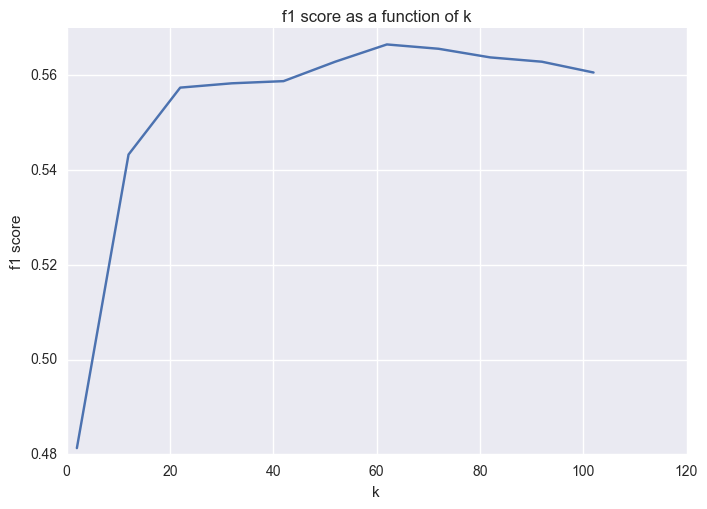

In [53]:
k_range = range(2,103,10)
val_scores = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_train_set, knn_train_labels)
    knn_val_pred = knn.predict(knn_val_set)
    val_f1 = metrics.f1_score(knn_val_labels, knn_val_pred, average='micro')
    print "validation score for k = %s:  %s" %(k, val_f1)
    val_scores.append(val_f1)

best_k = k_range[val_scores.index(max(val_scores))]
plot_results(k_range, val_scores, "f1 score", "k")

### Fit and evaluate by best parameter found

validation score for k = 50:  0.562443
validation score for k = 52:  0.562899
validation score for k = 54:  0.565634
validation score for k = 56:  0.563810
validation score for k = 58:  0.569280
validation score for k = 60:  0.568824
validation score for k = 62:  0.566545
validation score for k = 64:  0.567912
validation score for k = 66:  0.566545
validation score for k = 68:  0.568824


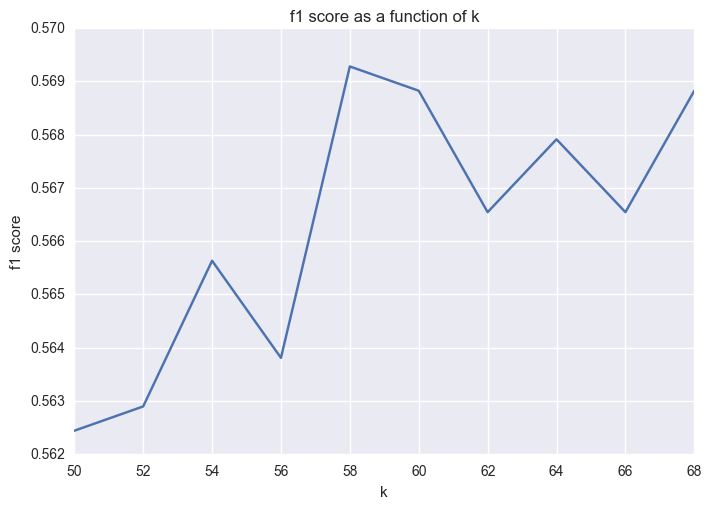

KNN - 4 BINS VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.69      0.62      0.65       560
      BIN_1       0.43      0.51      0.47       554
      BIN_2       0.48      0.53      0.51       566
      BIN_3       0.80      0.62      0.70       514

avg / total       0.59      0.57      0.58      2194


Confusion matrix with 4 bins: 
[[345 187  24   4]
 [110 284 151   9]
 [ 39 158 301  68]
 [  9  37 149 319]]


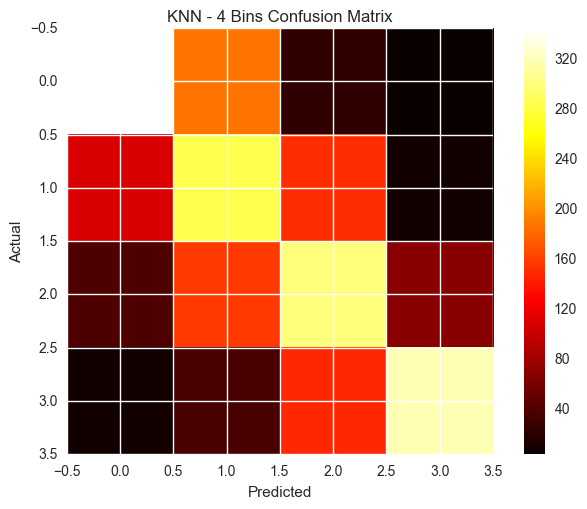


KNN - 4 Bins validation f1-score:0.569279854148


0.56927985414767546

In [54]:
k_range = range(50,70,2)

best_f1 = 0
knn_best_preds = []
val_scores = []
for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_train_set, knn_train_labels)
    knn_val_pred = knn.predict(knn_val_set)
    knn_val_pred_probs = knn.predict_proba(knn_val_set)
    val_f1 = metrics.f1_score(knn_val_labels, knn_val_pred, average='micro')
    if val_f1 > best_f1:
        best_f1 = val_f1
        knn_best_preds = [knn_val_pred, knn_val_pred_probs]
    print "validation score for k = %d:  %f" %(k, val_f1)
    val_scores.append(val_f1)

plot_results(k_range, val_scores, "f1 score", "k")
eval_model("KNN - 4 Bins", knn_val_labels, knn_best_preds[0], knn_best_preds[1], 
           is_val=True, bin_num=4)

### KNN PCA run

validation score for k = 50:  0.561076
validation score for k = 52:  0.561531
validation score for k = 54:  0.564722
validation score for k = 56:  0.567001
validation score for k = 58:  0.566089
validation score for k = 60:  0.567912
validation score for k = 62:  0.574294
validation score for k = 64:  0.566089
validation score for k = 66:  0.564722
validation score for k = 68:  0.568368


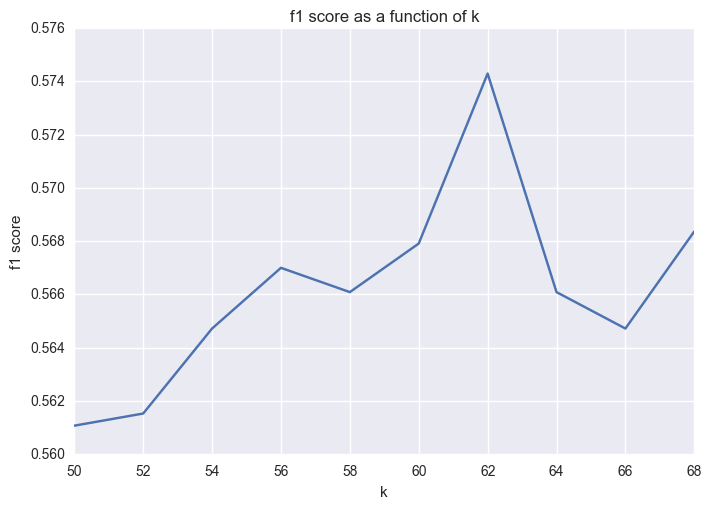

KNN - 4 BINS VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.69      0.63      0.66       560
      BIN_1       0.43      0.51      0.47       554
      BIN_2       0.48      0.54      0.51       566
      BIN_3       0.81      0.63      0.71       514

avg / total       0.60      0.57      0.58      2194


Confusion matrix with 4 bins: 
[[351 180  26   3]
 [110 283 153   8]
 [ 38 158 304  66]
 [  9  34 149 322]]


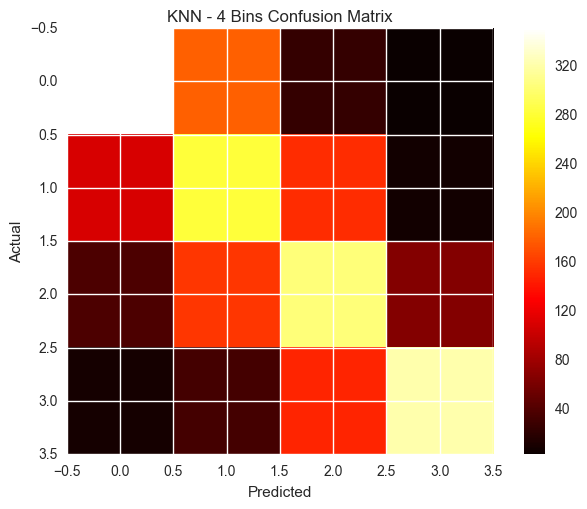


KNN - 4 Bins validation f1-score:0.574293527803


0.57429352780309939

In [55]:
knn_set = knn_train_set.append(knn_val_set, ignore_index=True)

pca = PCA(int(knn_train_set.shape[1] * 0.8))
pca.fit(knn_train_set)
pca_knn_set = pca.transform(knn_set)
pca_knn_train_set = pca_knn_set[:knn_train_set.shape[0]]
pca_knn_val_set = pca_knn_set[knn_train_set.shape[0]:]

k_range = range(50,70,2)
best_f1 = 0
knn_best_preds = []
val_scores = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(pca_knn_train_set, knn_train_labels)
    knn_val_pred = knn.predict(pca_knn_val_set)
    knn_val_pred_probs = knn.predict_proba(pca_knn_val_set)
    val_f1 = metrics.f1_score(knn_val_labels, knn_val_pred, average='micro')
    if val_f1 > best_f1:
        best_f1 = val_f1
        knn_best_preds = [knn_val_pred, knn_val_pred_probs]
    print "validation score for k = %d:  %f" %(k, val_f1)
    val_scores.append(val_f1)

plot_results(k_range, val_scores, "f1 score", "k")
eval_model("KNN - 4 Bins", knn_val_labels, knn_best_preds[0], knn_best_preds[1], 
           is_val=True, bin_num=4)

## Logistic Regression

### Generate feature selection combinations (save/load from disk to save time)

In [56]:
# Getting feature selections from disk

# feat_sel_list = get_feat_sel(train_set, val_set, train_labels['4_bin_labels'], val_labels['4_bin_labels'], lm.LogisticRegression(penalty='l2', C=1), verbose=True)
# with open('data_sets_LR.json', 'w') as lrf:
#     lrf.write(json.dumps(feat_sel_list))

with open('data_sets_LR.json', 'r') as lrf:
    feat_sel_list = json.loads(lrf.read())

### Preprocessing - preparing different data sets and removing outliers (Grubbs) from selected features

In [57]:
lr_train_set = train_set.copy()
lr_val_set = val_set.copy()
lr_train_labels = train_labels.copy()
lr_val_labels = val_labels.copy()

lr_data_sets = [(lr_train_set, lr_val_set, lr_train_labels, lr_val_labels)]

for feat_sel in feat_sel_list[:3]:
    feats_to_remove_by = [feat for feat in feat_sel['selected_feats'] if set(pp_data[feat].unique()) != {-1,1}]
    lr_pp_data = grubbs_outlier_removal(pp_data, feats_to_remove_by, verbose=True)
    lr_train_len = int(lr_pp_data.shape[0] * 0.8)
    
    lr_train_labels = lr_pp_data[['likes', '4_bin_labels', '8_bin_labels']][:lr_train_len].copy()
    lr_val_labels = lr_pp_data[['likes', '4_bin_labels', '8_bin_labels']][lr_train_len:].copy()

    lr_temp_pp_data = lr_pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
    lr_train_set = lr_temp_pp_data[feat_sel['selected_feats']][:lr_train_len].copy()
    lr_val_set = lr_temp_pp_data[feat_sel['selected_feats']][lr_train_len:].copy()
    
    lr_data_sets.append((lr_train_set, lr_val_set, lr_train_labels, lr_val_labels))


grubbs_outlier_removal: Got 39 feats to remove outliers by. STARTING...

grubbs_outlier_removal: feat photo_avg_likes_per_photo - 77 samples removed, 10891 samples left
grubbs_outlier_removal: feat feed_avg_likes_per_comment - 3 samples removed, 10888 samples left
grubbs_outlier_removal: feat feed_min_comments - 90 samples removed, 10798 samples left
grubbs_outlier_removal: feat feed_min_likes - 100 samples removed, 10698 samples left
grubbs_outlier_removal: feat feed_number_of_added_photos_category - 15 samples removed, 10683 samples left
grubbs_outlier_removal: feat feed_number_of_other_categories - 81 samples removed, 10602 samples left


c:\python27\lib\site-packages\outliers\smirnov_grubbs.py:105: RuntimeWarning: invalid value encountered in double_scalars
  g = value / data.std()


grubbs_outlier_removal: feat feed_post_max_with_tagged - 99 samples removed, 10503 samples left
grubbs_outlier_removal: feat feed_avg_shares - 14 samples removed, 10489 samples left
grubbs_outlier_removal: feat feed_max_shares - 8 samples removed, 10481 samples left
grubbs_outlier_removal: feat self_feed_avg_likes_per_comment - 3 samples removed, 10478 samples left
grubbs_outlier_removal: feat self_feed_avg_people_tagged_per_post - 1 samples removed, 10477 samples left
grubbs_outlier_removal: Total of 491 samples removed, 10477 samples left

grubbs_outlier_removal: Got 57 feats to remove outliers by. STARTING...

grubbs_outlier_removal: feat photo_avg_likes_per_photo - 77 samples removed, 10891 samples left
grubbs_outlier_removal: feat photo_count_has_name - 2 samples removed, 10889 samples left
grubbs_outlier_removal: feat photo_max_like - 16 samples removed, 10873 samples left
grubbs_outlier_removal: feat feed_avg_likes_per_comment - 3 samples removed, 10870 samples left
grubbs_outli

### Grid Search for best hyper params - NO NEED TO RUN

In [65]:
estimators = [[],[]]
for bin_num in (4, 8):
    for ds in lr_data_sets:
        lr_train_set, lr_val_set, lr_train_labels, lr_val_labels = ds
        lr_train_labels = lr_train_labels['%s_bin_labels' % bin_num]
        lr_val_labels = lr_val_labels['%s_bin_labels' % bin_num]
        
        print("Fitting the classifier to the training set")
        param_grid = {'C': np.logspace(-1,3, num=8)}
        clf = GridSearchCV(lm.LogisticRegression(max_iter=200, solver='newton-cg', multi_class='multinomial'), param_grid, verbose=True)

        clf.fit(lr_train_set, lr_train_labels)
        print("Best estimator found by grid search (%s bins, %s feats):" % (bin_num, lr_train_set.shape[1]))
        print(clf.best_estimator_)
        estimators[bin_num/4 - 1].append(clf.best_estimator_)

Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\python27\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 18.4min finished


Best estimator found by grid search (4 bins, 115 feats):
LogisticRegression(C=19.306977288832496, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  3.6min finished


Best estimator found by grid search (4 bins, 55 feats):
LogisticRegression(C=1.3894954943731375, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  8.7min finished


Best estimator found by grid search (4 bins, 75 feats):
LogisticRegression(C=71.96856730011514, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   53.4s finished


Best estimator found by grid search (4 bins, 37 feats):
LogisticRegression(C=1.3894954943731375, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 26.9min finished


Best estimator found by grid search (8 bins, 115 feats):
LogisticRegression(C=0.37275937203149401, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  9.6min finished


Best estimator found by grid search (8 bins, 55 feats):
LogisticRegression(C=5.1794746792312099, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 15.0min finished


Best estimator found by grid search (8 bins, 75 feats):
LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.3min finished


Best estimator found by grid search (8 bins, 37 feats):
LogisticRegression(C=0.37275937203149401, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)


### Fit and evaluate by best estimators found - NO NEED TO RUN

training logistic regression (4 bins, 115 feats):
getting logistic regression predictions
LOGISTIC REGRESSION (4 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.65      0.76      0.70       469
      BIN_1       0.52      0.45      0.48       595
      BIN_2       0.50      0.54      0.52       566
      BIN_3       0.79      0.73      0.76       565

avg / total       0.61      0.61      0.61      2195


Confusion matrix with 4 bins: 
[[356  95  18   0]
 [161 269 159   6]
 [ 25 134 305 102]
 [  7  20 124 414]]


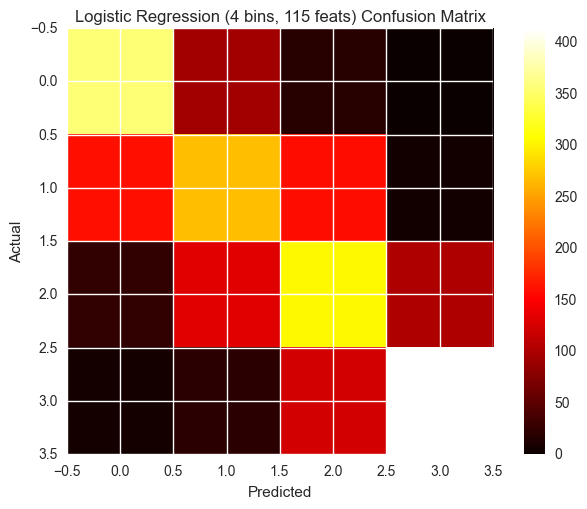


Logistic Regression (4 bins, 115 feats) validation f1-score:0.612300683371
training logistic regression (4 bins, 55 feats):
getting logistic regression predictions
LOGISTIC REGRESSION (4 BINS, 55 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.63      0.69      0.66       448
      BIN_1       0.50      0.42      0.46       582
      BIN_2       0.45      0.51      0.48       552
      BIN_3       0.73      0.72      0.73       556

avg / total       0.58      0.58      0.57      2138


Confusion matrix with 4 bins: 
[[309 109  29   1]
 [136 243 180  23]
 [ 34 115 280 123]
 [ 13  16 127 400]]


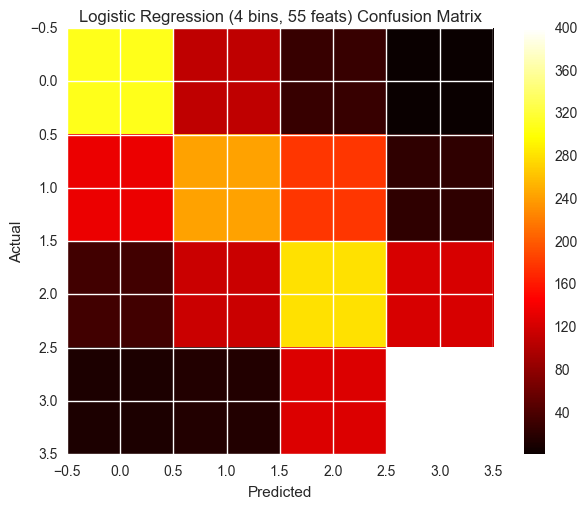


Logistic Regression (4 bins, 55 feats) validation f1-score:0.576239476146
training logistic regression (4 bins, 75 feats):
getting logistic regression predictions
LOGISTIC REGRESSION (4 BINS, 75 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.65      0.72      0.68       446
      BIN_1       0.51      0.43      0.47       580
      BIN_2       0.49      0.53      0.51       552
      BIN_3       0.78      0.76      0.77       553

avg / total       0.60      0.60      0.60      2131


Confusion matrix with 4 bins: 
[[323 109  14   0]
 [138 252 180  10]
 [ 31 118 294 109]
 [  6  15 113 419]]


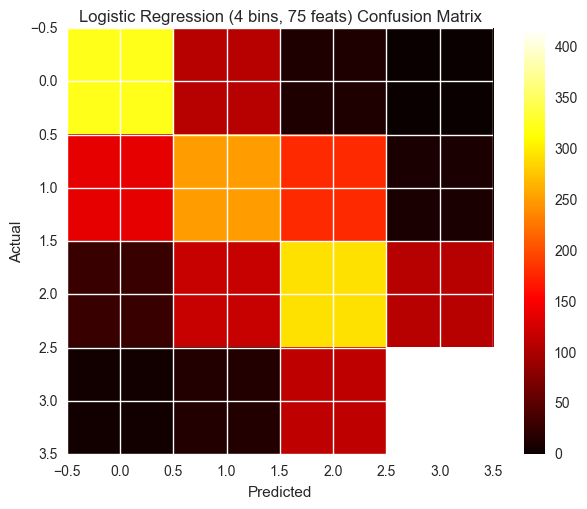


Logistic Regression (4 bins, 75 feats) validation f1-score:0.604411074613
training logistic regression (4 bins, 37 feats):
getting logistic regression predictions
LOGISTIC REGRESSION (4 BINS, 37 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.54      0.63      0.58       449
      BIN_1       0.41      0.30      0.35       579
      BIN_2       0.40      0.45      0.43       553
      BIN_3       0.67      0.70      0.69       558

avg / total       0.51      0.51      0.51      2139


Confusion matrix with 4 bins: 
[[283 119  43   4]
 [169 175 200  35]
 [ 57  96 249 151]
 [ 11  32 123 392]]


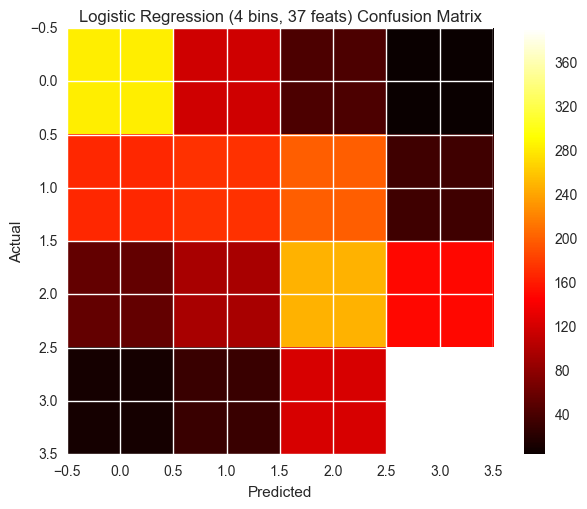


Logistic Regression (4 bins, 37 feats) validation f1-score:0.513791491351
training logistic regression (8 bins, 115 feats):
getting logistic regression predictions
LOGISTIC REGRESSION (8 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.60      0.63      0.61       229
      BIN_1       0.32      0.47      0.38       240
      BIN_2       0.32      0.26      0.29       295
      BIN_3       0.28      0.22      0.24       300
      BIN_4       0.23      0.23      0.23       267
      BIN_5       0.30      0.30      0.30       299
      BIN_6       0.36      0.38      0.37       294
      BIN_7       0.72      0.68      0.70       271

avg / total       0.38      0.38      0.38      2195


Confusion matrix with 8 bins: 
[[144  61  13   9   1   1   0   0]
 [ 51 112  45  15  14   3   0   0]
 [ 27  94  78  50  32  11   3   0]
 [ 10  54  51  65  63  49   8   0]
 [  3  18  30  59  61  65  30   1]
 [  3   8  1

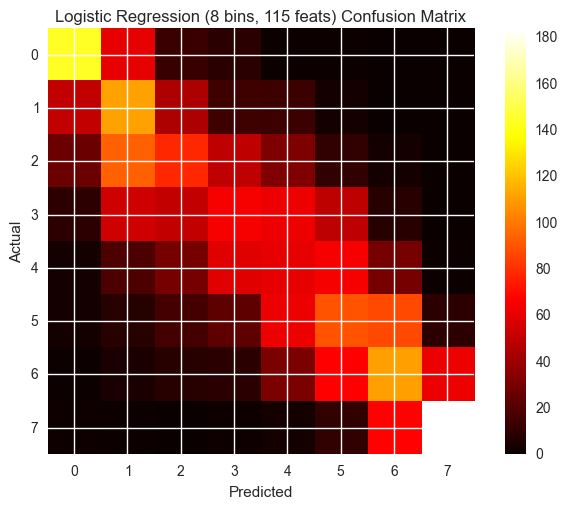


Logistic Regression (8 bins, 115 feats) validation f1-score:0.384965831435

1-Bin-Away scores:
Avg Precision: 0.793687880135
Avg Recall: 0.79905906107
Avg f1-score: 0.790407541197
training logistic regression (8 bins, 55 feats):
getting logistic regression predictions
LOGISTIC REGRESSION (8 BINS, 55 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.53      0.48      0.50       218
      BIN_1       0.26      0.39      0.31       230
      BIN_2       0.28      0.21      0.24       287
      BIN_3       0.27      0.21      0.23       295
      BIN_4       0.24      0.23      0.24       258
      BIN_5       0.27      0.29      0.28       294
      BIN_6       0.32      0.38      0.35       290
      BIN_7       0.68      0.67      0.67       266

avg / total       0.35      0.35      0.35      2138


Confusion matrix with 8 bins: 
[[105  90  11   4   5   2   1   0]
 [ 43  90  47  27  14   9   0   0]
 [ 23  79  61

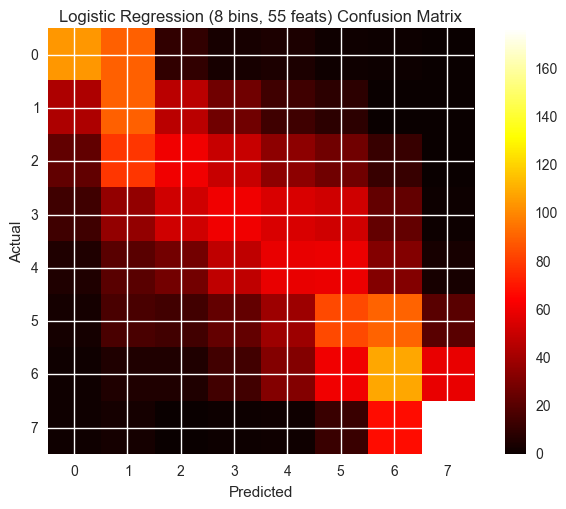


Logistic Regression (8 bins, 55 feats) validation f1-score:0.348924228251

1-Bin-Away scores:
Avg Precision: 0.749312790251
Avg Recall: 0.763453299979
Avg f1-score: 0.749396561024
training logistic regression (8 bins, 75 feats):
getting logistic regression predictions
LOGISTIC REGRESSION (8 BINS, 75 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.55      0.46      0.50       216
      BIN_1       0.29      0.47      0.36       230
      BIN_2       0.27      0.22      0.24       287
      BIN_3       0.27      0.20      0.23       293
      BIN_4       0.24      0.22      0.23       258
      BIN_5       0.25      0.27      0.26       294
      BIN_6       0.36      0.40      0.38       289
      BIN_7       0.71      0.72      0.72       264

avg / total       0.36      0.36      0.36      2131


Confusion matrix with 8 bins: 
[[ 99  91  20   5   0   0   1   0]
 [ 39 107  46  26   7   5   0   0]
 [ 24  89  62

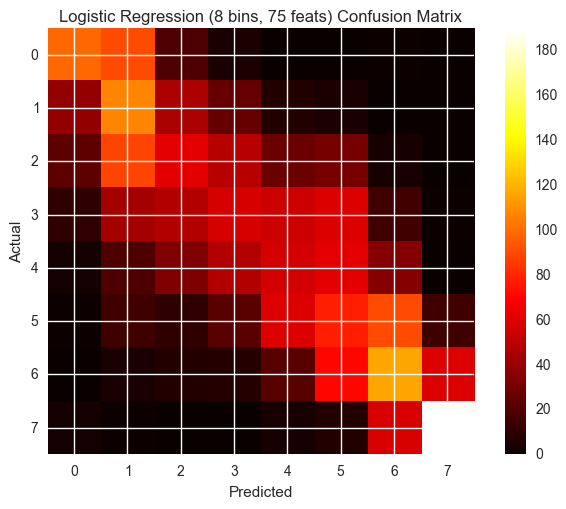


Logistic Regression (8 bins, 75 feats) validation f1-score:0.359924917879

1-Bin-Away scores:
Avg Precision: 0.773101986153
Avg Recall: 0.792985733974
Avg f1-score: 0.773589941522
training logistic regression (8 bins, 37 feats):
getting logistic regression predictions
LOGISTIC REGRESSION (8 BINS, 37 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.41      0.39      0.40       217
      BIN_1       0.23      0.36      0.28       232
      BIN_2       0.17      0.10      0.13       287
      BIN_3       0.22      0.12      0.16       292
      BIN_4       0.21      0.22      0.21       259
      BIN_5       0.21      0.20      0.20       294
      BIN_6       0.28      0.36      0.32       291
      BIN_7       0.59      0.67      0.63       267

avg / total       0.28      0.30      0.29      2139


Confusion matrix with 8 bins: 
[[ 85  84  23  12   8   4   1   0]
 [ 49  83  41  22  23   9   5   0]
 [ 32  80  30

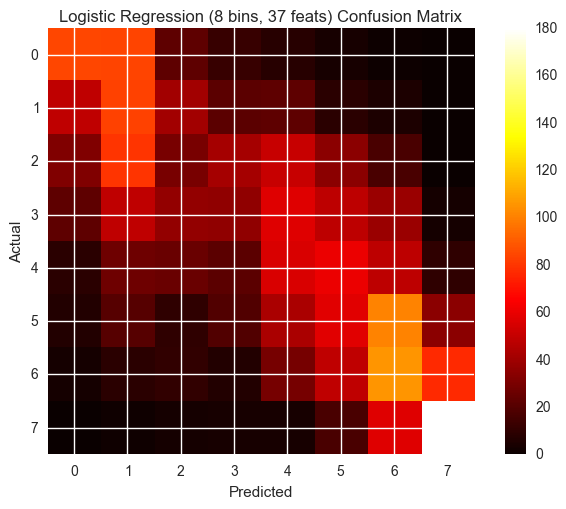


Logistic Regression (8 bins, 37 feats) validation f1-score:0.296400187003

1-Bin-Away scores:
Avg Precision: 0.67599492223
Avg Recall: 0.695179031384
Avg f1-score: 0.669754089044


In [66]:
best_score = [0, 0]
best_score_idx = [0, 0]
for bin_num in (4, 8):
    for i in range(len(lr_data_sets)):
        ds = lr_data_sets[i]
        lr_train_set, lr_val_set, lr_train_labels, lr_val_labels = ds
        lr_train_labels = lr_train_labels['%s_bin_labels' % bin_num]
        lr_val_labels = lr_val_labels['%s_bin_labels' % bin_num]
        
        lr = estimators[bin_num/4 - 1][i]
        print "training logistic regression (%s bins, %s feats):" % (bin_num, lr_train_set.shape[1])
        lr.fit(lr_train_set, lr_train_labels)
        print "getting logistic regression predictions"
        lr_predicted_probs = lr.predict_proba(lr_train_set.append(lr_val_set, ignore_index=True))[:, 1]
        lr_predictions = lr.predict(lr_train_set.append(lr_val_set, ignore_index=True))

        lr_train_predicted_probs = lr_predicted_probs[:lr_train_set.shape[0]]
        lr_val_predicted_probs = lr_predicted_probs[lr_train_set.shape[0]:]

        lr_train_predictions = lr_predictions[:lr_train_set.shape[0]]
        lr_val_predictions = lr_predictions[lr_train_set.shape[0]:]
        
        run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, lr_train_set.shape[1]), lr_val_labels, lr_val_predictions, lr_val_predicted_probs, True, bin_num)
        
        if run_score > best_score[bin_num/4 - 1]:
            best_score[bin_num/4 - 1] = run_score
            best_score_idx[bin_num/4 - 1] = i

### Best model predictions - NO NEED TO RUN

best_score_idx -  [0, 0]
4 Bins Logistic Regression Final Results:

Using best estimator -  LogisticRegression(C=19.306977288832496, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
LOGISTIC REGRESSION (4 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.65      0.76      0.70       469
      BIN_1       0.52      0.45      0.48       595
      BIN_2       0.50      0.54      0.52       566
      BIN_3       0.79      0.73      0.76       565

avg / total       0.61      0.61      0.61      2195


Confusion matrix with 4 bins: 
[[356  95  18   0]
 [161 269 159   6]
 [ 25 134 305 102]
 [  7  20 124 414]]


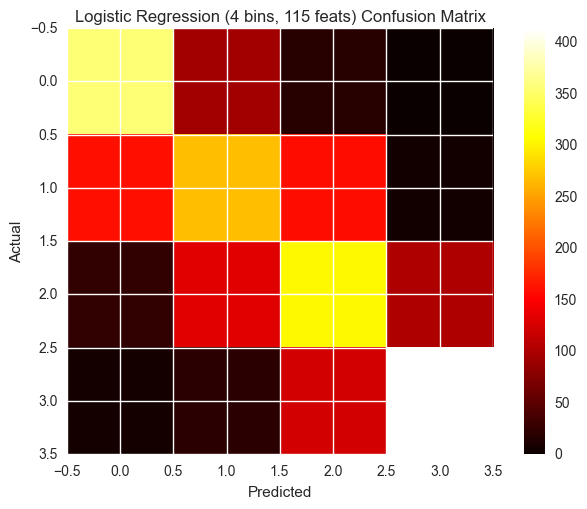


Logistic Regression (4 bins, 115 feats) validation f1-score:0.612300683371
8 Bins Logistic Regression Final Results:

Using best estimator -  LogisticRegression(C=0.37275937203149401, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
LOGISTIC REGRESSION (8 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.60      0.63      0.61       229
      BIN_1       0.32      0.47      0.38       240
      BIN_2       0.32      0.26      0.29       295
      BIN_3       0.28      0.22      0.24       300
      BIN_4       0.23      0.23      0.23       267
      BIN_5       0.30      0.30      0.30       299
      BIN_6       0.36      0.38      0.37       294
      BIN_7       0.72      0.68      0.70       2

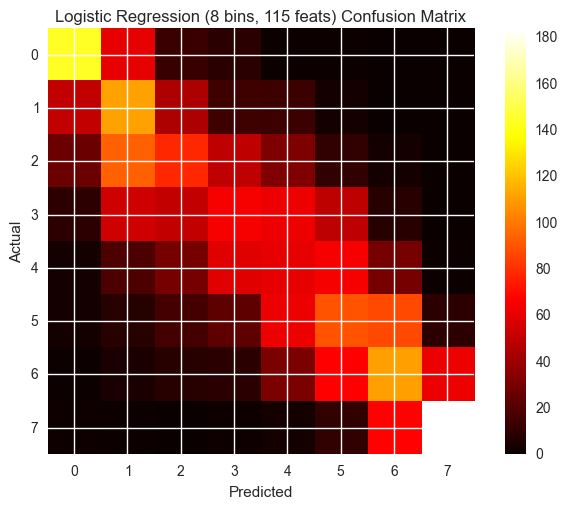


Logistic Regression (8 bins, 115 feats) validation f1-score:0.384965831435

1-Bin-Away scores:
Avg Precision: 0.793687880135
Avg Recall: 0.79905906107
Avg f1-score: 0.790407541197


In [67]:
print "best_score_idx - ", best_score_idx

for bin_num in (4, 8):
    print "%s Bins Logistic Regression Final Results:" % bin_num
    print "=========================================\n"
    best_results_idx = best_score_idx[bin_num/4 - 1]
    lr_train_set, lr_val_set, lr_train_labels, lr_val_labels = lr_data_sets[best_results_idx]
    lr_train_labels = lr_train_labels['%s_bin_labels' % bin_num]
    lr_val_labels = lr_val_labels['%s_bin_labels' % bin_num]
    lr = estimators[bin_num/4 - 1][best_results_idx]
    print "Using best estimator - ", lr
    
    lr_val_predicted_probs = lr.predict_proba(lr_val_set)[:, 1]
    lr_val_predictions = lr.predict(lr_val_set)
    
    if best_results_idx > 0:
        feats = feat_sel_list[best_results_idx - 1]['selected_feats']
        print "Got best results for %s selected features:\n%s" % (len(feats), '\n'.join(feats))
    
    run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, lr_train_set.shape[1]), lr_val_labels, lr_val_predictions, lr_val_predicted_probs, True, bin_num)

### Best model predictions - manual set for best params found

4 Bins Logistic Regression Final Results:

LOGISTIC REGRESSION (4 BINS, 115 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.70      0.74      0.72      2070
      BIN_1       0.53      0.53      0.53      2317
      BIN_2       0.55      0.56      0.56      2300
      BIN_3       0.80      0.74      0.77      2087

avg / total       0.64      0.64      0.64      8774


Confusion matrix with 4 bins: 
[[1537  471   62    0]
 [ 527 1221  532   37]
 [ 117  546 1290  347]
 [  10   83  458 1536]]


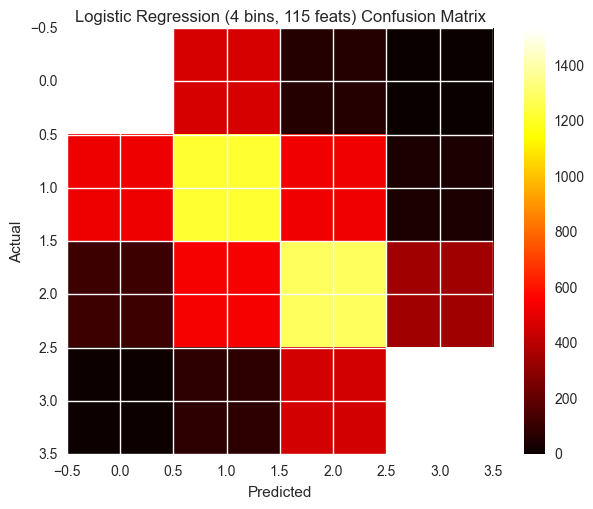


Logistic Regression (4 bins, 115 feats) train f1-score:0.63642580351



LOGISTIC REGRESSION (4 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.70      0.74      0.72       560
      BIN_1       0.46      0.48      0.47       554
      BIN_2       0.54      0.53      0.53       566
      BIN_3       0.81      0.74      0.77       514

avg / total       0.62      0.62      0.62      2194


Confusion matrix with 4 bins: 
[[415 132  13   0]
 [142 265 142   5]
 [ 33 151 300  82]
 [  7  23 105 379]]


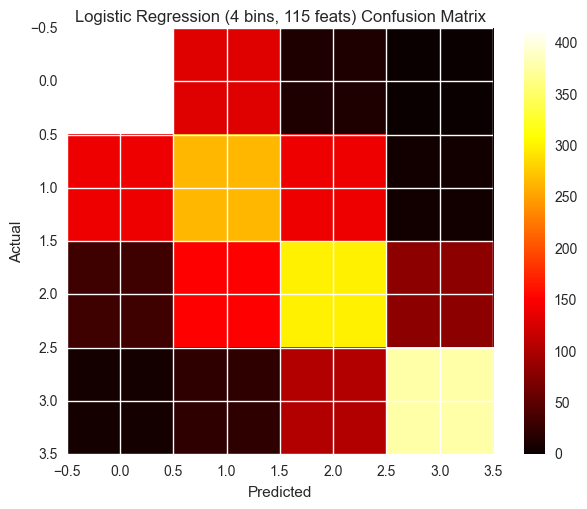


Logistic Regression (4 bins, 115 feats) validation f1-score:0.619416590702
8 Bins Logistic Regression Final Results:

LOGISTIC REGRESSION (8 BINS, 115 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.60      0.69      0.64       931
      BIN_1       0.40      0.45      0.42      1139
      BIN_2       0.35      0.35      0.35      1166
      BIN_3       0.32      0.29      0.30      1151
      BIN_4       0.35      0.32      0.33      1155
      BIN_5       0.36      0.33      0.35      1145
      BIN_6       0.44      0.45      0.44      1151
      BIN_7       0.71      0.73      0.72       936

avg / total       0.43      0.44      0.43      8774


Confusion matrix with 8 bins: 
[[640 205  63  17   4   2   0   0]
 [227 508 241 105  47  10   1   0]
 [121 280 404 205  99  43  12   2]
 [ 50 143 222 330 219 139  47   1]
 [ 21  71 123 197 366 239 130   8]
 [  9  35  83 121 201 383 278  35]
 [  1  13  30  45 110 209 51

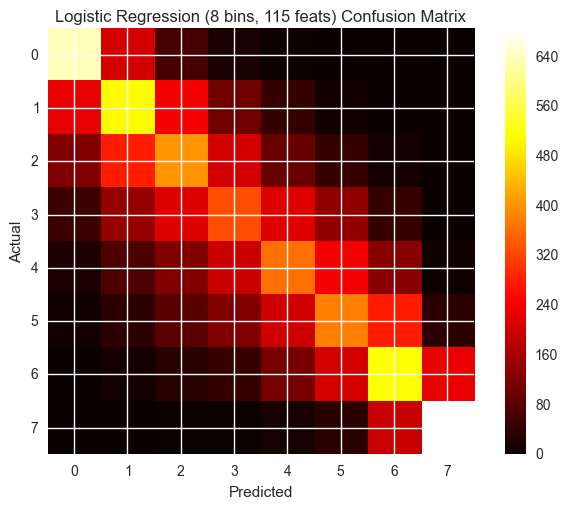


Logistic Regression (8 bins, 115 feats) train f1-score:0.436744928197

1-Bin-Away scores:
Avg Precision: 0.80141184061
Avg Recall: 0.797123191344
Avg f1-score: 0.79785979402



LOGISTIC REGRESSION (8 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.54      0.63      0.59       246
      BIN_1       0.37      0.41      0.39       314
      BIN_2       0.25      0.26      0.25       270
      BIN_3       0.23      0.21      0.22       284
      BIN_4       0.29      0.25      0.27       281
      BIN_5       0.31      0.29      0.30       285
      BIN_6       0.43      0.43      0.43       279
      BIN_7       0.69      0.69      0.69       235

avg / total       0.38      0.39      0.38      2194


Confusion matrix with 8 bins: 
[[156  58  24   6   1   1   0   0]
 [ 81 128  66  27   8   3   1   0]
 [ 24  77  71  53  28  15   2   0]
 [ 13  50  58  59  63  33   7   1]
 [  8  15  38  59  70  64  26   1]

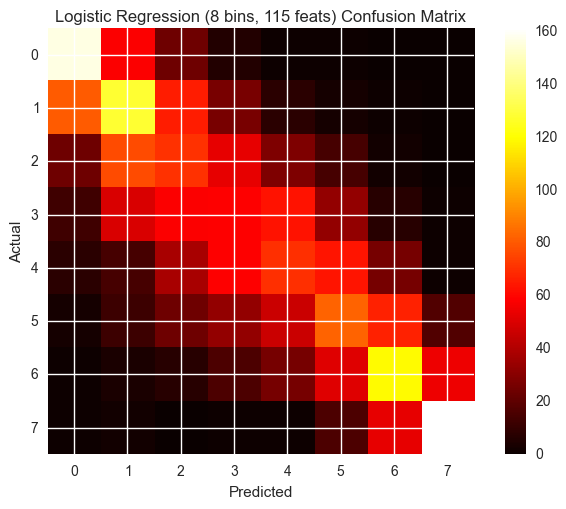


Logistic Regression (8 bins, 115 feats) validation f1-score:0.386052871468

1-Bin-Away scores:
Avg Precision: 0.776950511014
Avg Recall: 0.77586515945
Avg f1-score: 0.774612242841


In [58]:
best_score_idx = [0, 0]
best_estimators = [
    lm.LogisticRegression(C=19.306977288832496, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False),
    lm.LogisticRegression(C=0.37275937203149401, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
]

for bin_num in (4, 8):
    print "%s Bins Logistic Regression Final Results:" % bin_num
    print "=========================================\n"
    best_results_idx = best_score_idx[bin_num/4 - 1]
    lr_train_set, lr_val_set, lr_train_labels, lr_val_labels = lr_data_sets[best_results_idx]
    lr_train_labels = lr_train_labels['%s_bin_labels' % bin_num]
    lr_val_labels = lr_val_labels['%s_bin_labels' % bin_num]
    lr = best_estimators[bin_num/4 - 1]
    lr.fit(lr_train_set, lr_train_labels)
    
    lr_train_predictions = lr.predict(lr_train_set)
    lr_val_predictions = lr.predict(lr_val_set)
    
    if best_results_idx > 0:
        feats = feat_sel_list[best_results_idx - 1]['selected_feats']
        print "Got best results for %s selected features:\n%s" % (len(feats), '\n'.join(feats))
    
    run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, lr_train_set.shape[1]), lr_train_labels, lr_train_predictions, None, False, bin_num)
    print "\n\n"
    run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, lr_train_set.shape[1]), lr_val_labels, lr_val_predictions, None, True, bin_num)

# SVM

### Generate preprocessed data sets (save/load from disk to save time)

In [61]:
# Getting feature selections from disk

# feat_sel_list = get_feat_sel(train_set, val_set, train_labels['4_bin_labels'], val_labels['4_bin_labels'], svm.SVC(class_weight='balanced', C=100, kernel='linear'), verbose=True)
# with open('data_sets_SVM.json', 'w') as svmf:
#     svmf.write(json.dumps(feat_sel_list))

with open('data_sets_SVM.json', 'r') as svmf:
    feat_sel_list = json.loads(svmf.read())

### Preprocessing - preparing different data sets and removing outliers (Grubbs) from selected features

In [62]:
svm_train_set = train_set.copy()
svm_val_set = val_set.copy()
svm_train_labels = train_labels.copy()
svm_val_labels = val_labels.copy()

svm_data_sets = [(svm_train_set, svm_val_set, svm_train_labels, svm_val_labels)]

for feat_sel in feat_sel_list[:2]:
    feats_to_remove_by = [feat for feat in feat_sel['selected_feats'] if set(pp_data[feat].unique()) != {-1,1}]
    svm_pp_data = grubbs_outlier_removal(pp_data, feats_to_remove_by, verbose=True)
    svm_train_len = int(svm_pp_data.shape[0] * 0.8)
    
    svm_train_labels = svm_pp_data[['likes', '4_bin_labels', '8_bin_labels']][:svm_train_len].copy()
    svm_val_labels = svm_pp_data[['likes', '4_bin_labels', '8_bin_labels']][svm_train_len:].copy()

    svm_temp_pp_data = svm_pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
    svm_train_set = svm_temp_pp_data[feat_sel['selected_feats']][:svm_train_len].copy()
    svm_val_set = svm_temp_pp_data[feat_sel['selected_feats']][svm_train_len:].copy()
    
    svm_data_sets.append((svm_train_set, svm_val_set, svm_train_labels, svm_val_labels))


grubbs_outlier_removal: Got 59 feats to remove outliers by. STARTING...

grubbs_outlier_removal: feat photo_avg_likes_per_photo - 77 samples removed, 10891 samples left
grubbs_outlier_removal: feat photo_count_has_name - 2 samples removed, 10889 samples left
grubbs_outlier_removal: feat photo_max_like - 16 samples removed, 10873 samples left
grubbs_outlier_removal: feat feed_avg_likes_per_comment - 3 samples removed, 10870 samples left
grubbs_outlier_removal: feat feed_min_comments - 89 samples removed, 10781 samples left
grubbs_outlier_removal: feat feed_min_likes - 100 samples removed, 10681 samples left
grubbs_outlier_removal: feat feed_number_of_added_photos_category - 15 samples removed, 10666 samples left
grubbs_outlier_removal: feat feed_number_of_other_categories - 81 samples removed, 10585 samples left
grubbs_outlier_removal: feat feed_post_max_with_tagged - 99 samples removed, 10486 samples left
grubbs_outlier_removal: feat feed_avg_shares - 14 samples removed, 10472 samples

### Grid Search for best hyper params - NO NEED TO RUN

In [97]:
import sklearn.svm as svm_lib

estimators = [[],[]]
for bin_num in (4, 8):
    for ds in svm_data_sets:
        svm_train_set, svm_val_set, svm_train_labels, svm_val_labels = ds
        svm_train_labels = svm_train_labels['%s_bin_labels' % bin_num]
        svm_val_labels = svm_val_labels['%s_bin_labels' % bin_num]

        print("Fitting the classifier to the training set")
        param_grid = {'C': np.linspace(7,15,8)}
        clf = GridSearchCV(svm_lib.SVC(class_weight='balanced', kernel='linear'), param_grid, verbose=True, scoring='f1_micro')

        clf.fit(svm_train_set, svm_train_labels)
        print("Best estimator found by grid search (%s bins, %s feats):" % (bin_num, svm_train_set.shape[1]))
        print clf.best_estimator_, clf.best_score_ 
        estimators[bin_num/4 - 1].append(clf.best_estimator_)

Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 33.4min finished


Best estimator found by grid search (4 bins, 115 feats):
SVC(C=10.428571428571429, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.620768266272
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 14.9min finished


Best estimator found by grid search (4 bins, 88 feats):
SVC(C=7.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.599788310008
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  4.1min finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=8.1428571428571423, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.519761029412
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 50.5min finished


Best estimator found by grid search (8 bins, 115 feats):
SVC(C=7.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.386184885444
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 38.8min finished


Best estimator found by grid search (8 bins, 88 feats):
SVC(C=15.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.363165941432
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  4.3min finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=13.857142857142858, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.306181066176


### Fit and evaluate by best estimators found - NO NEED TO RUN

training SVM (4 bins, 115 feats):
SVC(C=10.428571428571429, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
getting SVM predictions
SVM (4 BINS, 115 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.72      0.74      0.73      2085
      BIN_1       0.52      0.52      0.52      2292
      BIN_2       0.54      0.57      0.55      2263
      BIN_3       0.81      0.74      0.78      2133

avg / total       0.64      0.64      0.64      8773


Confusion matrix with 4 bins: 
[[1534  498   53    0]
 [ 477 1194  594   27]
 [ 115  533 1279  336]
 [  17   73  463 1580]]


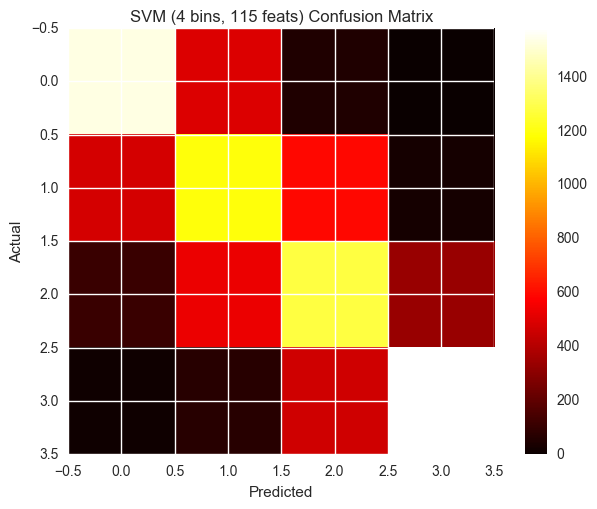


SVM (4 bins, 115 feats) train f1-score:0.636840305483
SVM (4 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.67      0.69      0.68       524
      BIN_1       0.48      0.51      0.50       575
      BIN_2       0.55      0.55      0.55       590
      BIN_3       0.78      0.71      0.75       505

avg / total       0.61      0.61      0.61      2194


Confusion matrix with 4 bins: 
[[361 146  17   0]
 [143 293 132   7]
 [ 30 145 322  93]
 [  6  22 116 361]]


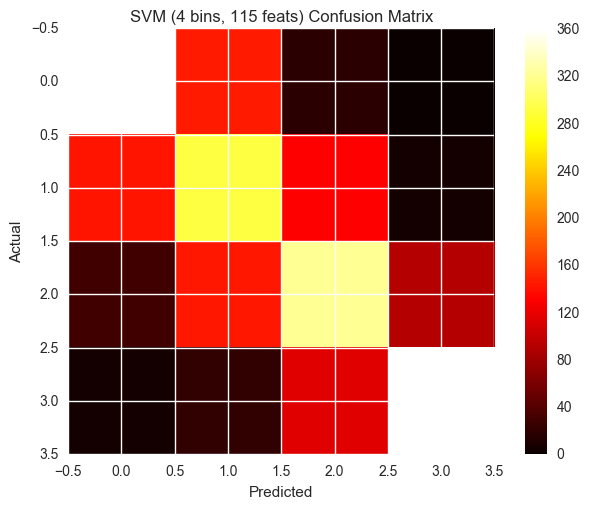


SVM (4 bins, 115 feats) validation f1-score:0.609389243391
training SVM (4 bins, 88 feats):
SVC(C=7.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
getting SVM predictions
SVM (4 BINS, 88 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.68      0.76      0.72      1984
      BIN_1       0.52      0.48      0.50      2233
      BIN_2       0.53      0.54      0.53      2202
      BIN_3       0.79      0.76      0.78      2084

avg / total       0.63      0.63      0.63      8503


Confusion matrix with 4 bins: 
[[1509  405   69    1]
 [ 533 1066  601   33]
 [ 143  494 1186  379]
 [  21   77  398 1588]]


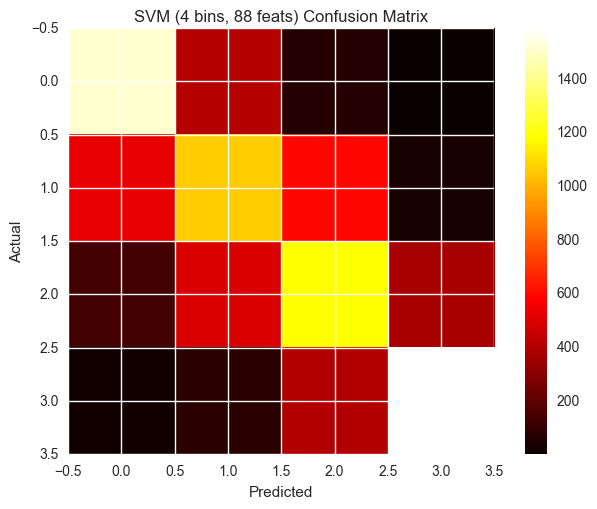


SVM (4 bins, 88 feats) train f1-score:0.629072092203
SVM (4 BINS, 88 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.63      0.71      0.67       494
      BIN_1       0.47      0.46      0.47       555
      BIN_2       0.54      0.52      0.53       576
      BIN_3       0.78      0.74      0.76       501

avg / total       0.60      0.60      0.60      2126


Confusion matrix with 4 bins: 
[[353 123  18   0]
 [155 257 134   9]
 [ 38 146 298  94]
 [ 10  20 101 370]]


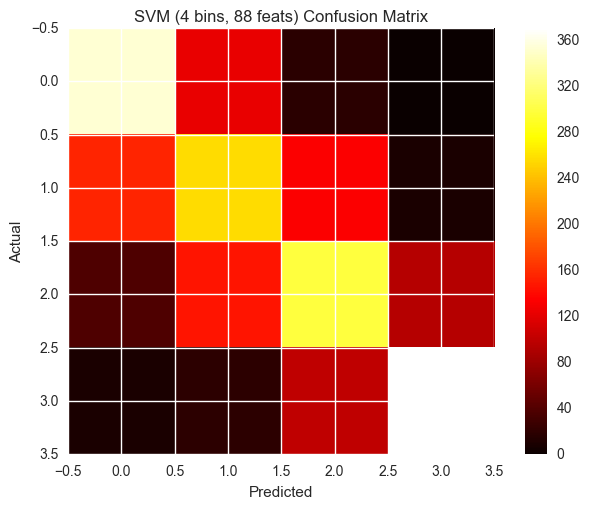


SVM (4 bins, 88 feats) validation f1-score:0.601128880527
training SVM (4 bins, 29 feats):
SVC(C=8.1428571428571423, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
getting SVM predictions
SVM (4 BINS, 29 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.57      0.70      0.63      2046
      BIN_1       0.43      0.35      0.39      2275
      BIN_2       0.43      0.39      0.41      2255
      BIN_3       0.66      0.72      0.68      2128

avg / total       0.52      0.53      0.52      8704


Confusion matrix with 4 bins: 
[[1433  452  141   20]
 [ 695  793  612  175]
 [ 319  448  883  605]
 [  64  131  411 1522]]


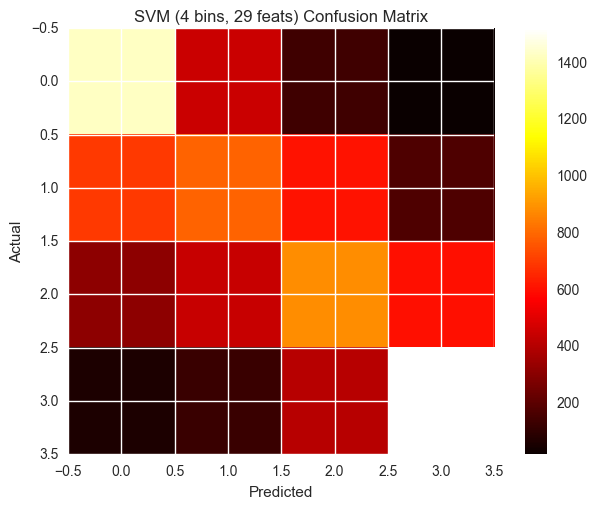


SVM (4 bins, 29 feats) train f1-score:0.532054227941
SVM (4 BINS, 29 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.51      0.62      0.56       504
      BIN_1       0.41      0.37      0.39       573
      BIN_2       0.46      0.38      0.42       591
      BIN_3       0.65      0.72      0.68       509

avg / total       0.50      0.51      0.51      2177


Confusion matrix with 4 bins: 
[[313 141  46   4]
 [185 214 139  35]
 [ 87 122 224 158]
 [ 24  39  79 367]]


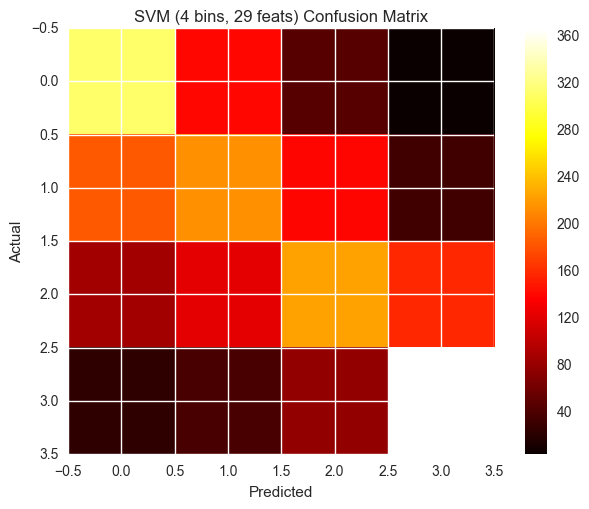


SVM (4 bins, 29 feats) validation f1-score:0.513550757924
training SVM (8 bins, 115 feats):
SVC(C=7.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
getting SVM predictions
SVM (8 BINS, 115 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.56      0.77      0.65       941
      BIN_1       0.43      0.39      0.41      1144
      BIN_2       0.35      0.40      0.37      1142
      BIN_3       0.33      0.25      0.29      1150
      BIN_4       0.33      0.35      0.34      1116
      BIN_5       0.38      0.36      0.37      1147
      BIN_6       0.51      0.42      0.46      1191
      BIN_7       0.69      0.74      0.72       942

avg / total       0.44      0.45      0.44      8773


Confusion matrix with 8 bins: 
[[723 145  60  13   0  

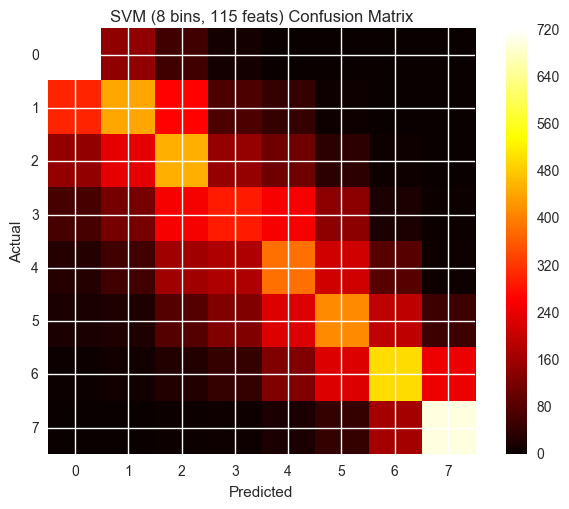


SVM (8 bins, 115 feats) train f1-score:0.445685626354

1-Bin-Away scores:
Avg Precision: 0.80057936021
Avg Recall: 0.810307813624
Avg f1-score: 0.799247833029
SVM (8 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.53      0.72      0.61       236
      BIN_1       0.38      0.35      0.37       288
      BIN_2       0.29      0.34      0.31       292
      BIN_3       0.26      0.21      0.23       283
      BIN_4       0.30      0.31      0.31       299
      BIN_5       0.33      0.29      0.31       291
      BIN_6       0.43      0.35      0.39       268
      BIN_7       0.69      0.73      0.71       237

avg / total       0.39      0.40      0.39      2194


Confusion matrix with 8 bins: 
[[171  40  17   4   3   1   0   0]
 [ 71 102  81  24   9   1   0   0]
 [ 37  64 100  43  31  16   1   0]
 [ 25  34  76  60  60  21   7   0]
 [  9  11  34  60  93  61  23   8]
 [  5  13  24  28  74  83  49  15

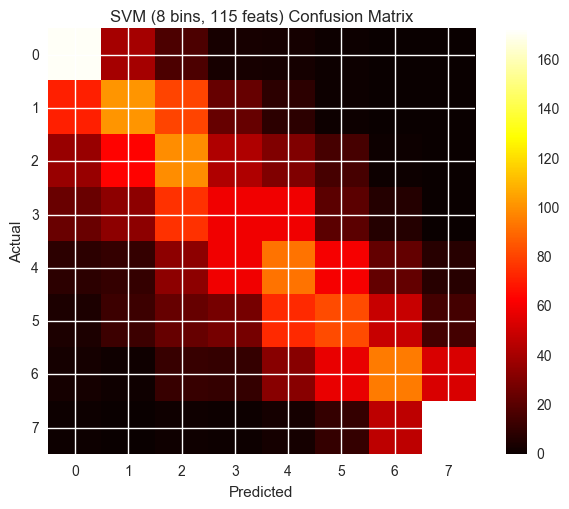


SVM (8 bins, 115 feats) validation f1-score:0.399726526892

1-Bin-Away scores:
Avg Precision: 0.787194674021
Avg Recall: 0.798296971499
Avg f1-score: 0.78712301389
training SVM (8 bins, 88 feats):
SVC(C=15.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
getting SVM predictions
SVM (8 BINS, 88 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.53      0.74      0.62       887
      BIN_1       0.40      0.38      0.39      1097
      BIN_2       0.35      0.33      0.34      1115
      BIN_3       0.34      0.28      0.31      1118
      BIN_4       0.30      0.29      0.29      1082
      BIN_5       0.35      0.34      0.34      1120
      BIN_6       0.46      0.41      0.44      1169
      BIN_7       0.67      0.76      0.71       915

avg 

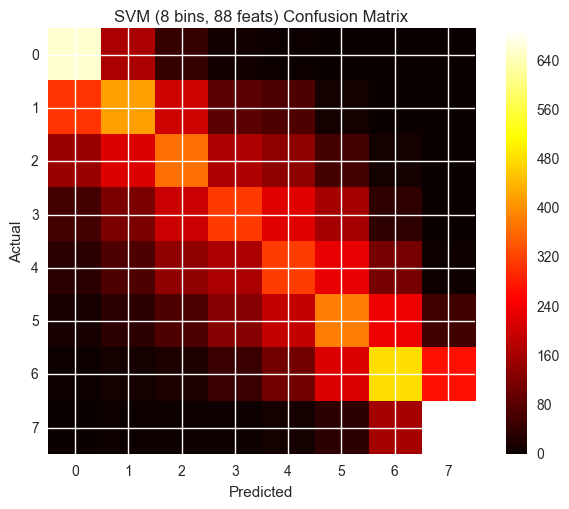


SVM (8 bins, 88 feats) train f1-score:0.427260966718

1-Bin-Away scores:
Avg Precision: 0.78243504457
Avg Recall: 0.778789433521
Avg f1-score: 0.776272027175
SVM (8 BINS, 88 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.50      0.65      0.57       215
      BIN_1       0.35      0.35      0.35       279
      BIN_2       0.29      0.29      0.29       283
      BIN_3       0.25      0.22      0.24       272
      BIN_4       0.28      0.25      0.26       291
      BIN_5       0.33      0.30      0.32       285
      BIN_6       0.39      0.39      0.39       267
      BIN_7       0.67      0.72      0.69       234

avg / total       0.37      0.38      0.38      2126


Confusion matrix with 8 bins: 
[[139  52  17   4   2   1   0   0]
 [ 67  99  67  26  13   7   0   0]
 [ 32  65  83  47  37  17   2   0]
 [ 24  31  61  61  54  29  10   2]
 [  7  18  38  58  72  60  30   8]
 [  3  13  17  32  54  86  68  12]


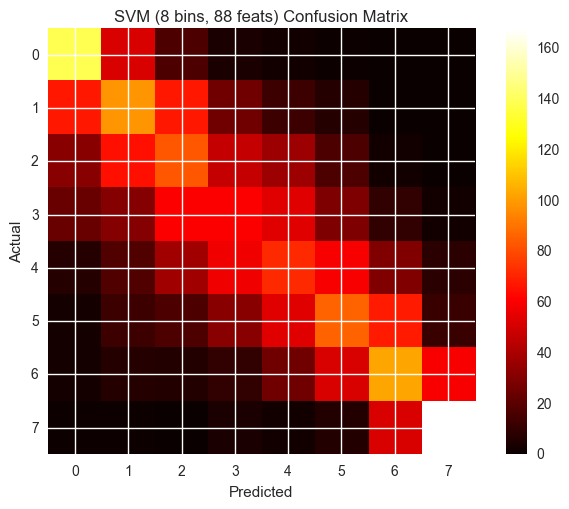


SVM (8 bins, 88 feats) validation f1-score:0.381467544685

1-Bin-Away scores:
Avg Precision: 0.773470276305
Avg Recall: 0.767127380971
Avg f1-score: 0.7678196072
training SVM (8 bins, 29 feats):
SVC(C=13.857142857142858, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
getting SVM predictions
SVM (8 BINS, 29 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.38      0.67      0.48       914
      BIN_1       0.29      0.23      0.26      1132
      BIN_2       0.24      0.22      0.23      1134
      BIN_3       0.25      0.15      0.19      1141
      BIN_4       0.25      0.24      0.24      1109
      BIN_5       0.23      0.19      0.21      1146
      BIN_6       0.33      0.31      0.32      1189
      BIN_7       0.48      0.68      0.56    

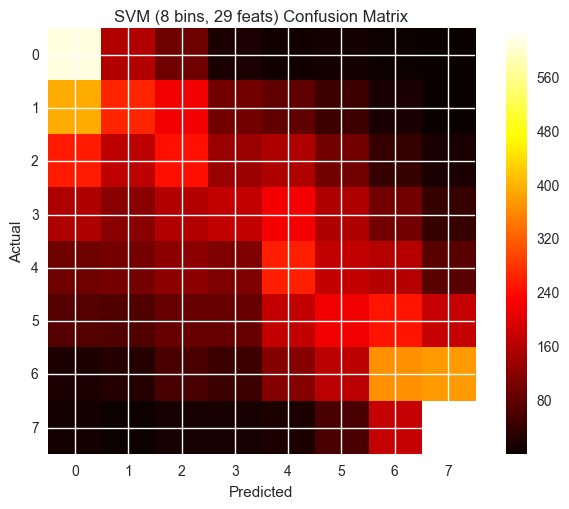


SVM (8 bins, 29 feats) train f1-score:0.320197610294

1-Bin-Away scores:
Avg Precision: 0.662059512395
Avg Recall: 0.676568356481
Avg f1-score: 0.653219304698
SVM (8 BINS, 29 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.35      0.59      0.44       219
      BIN_1       0.24      0.21      0.23       285
      BIN_2       0.24      0.23      0.24       292
      BIN_3       0.22      0.15      0.18       281
      BIN_4       0.29      0.26      0.27       300
      BIN_5       0.26      0.20      0.22       291
      BIN_6       0.28      0.26      0.27       269
      BIN_7       0.52      0.75      0.61       240

avg / total       0.29      0.31      0.30      2177


Confusion matrix with 8 bins: 
[[129  46  28   9   5   2   0   0]
 [ 83  61  56  36  28  14   7   0]
 [ 60  51  67  48  36  19   7   4]
 [ 43  37  37  42  51  39  22  10]
 [ 25  32  34  29  78  43  39  20]
 [ 17  14  26  14  46  57  73  44]

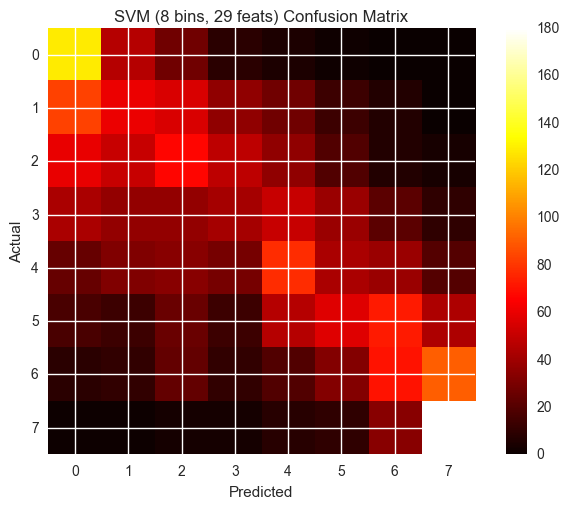


SVM (8 bins, 29 feats) validation f1-score:0.314653192467

1-Bin-Away scores:
Avg Precision: 0.656669059128
Avg Recall: 0.662071214351
Avg f1-score: 0.646009257336


In [98]:
best_score = [0, 0]
best_score_idx = [0, 0]
for bin_num in (4, 8):
    for i in range(len(svm_data_sets)):
        ds = svm_data_sets[i]
        svm_train_set, svm_val_set, svm_train_labels, svm_val_labels = ds
        svm_train_labels = svm_train_labels['%s_bin_labels' % bin_num]
        svm_val_labels = svm_val_labels['%s_bin_labels' % bin_num]

        svm = estimators[bin_num/4 - 1][i]
        print "training SVM (%s bins, %s feats):" % (bin_num, svm_train_set.shape[1])
        print svm

        svm.fit(svm_train_set, svm_train_labels)
        print "getting SVM predictions"

        svm_train_predictions = svm.predict(svm_train_set)
        svm_val_predictions = svm.predict(svm_val_set)
        eval_model("SVM (%s bins, %s feats)" % (bin_num, svm_train_set.shape[1]), svm_train_labels, svm_train_predictions, None, False, bin_num)
        run_score = eval_model("SVM (%s bins, %s feats)" % (bin_num, svm_train_set.shape[1]), svm_val_labels, svm_val_predictions, None, True, bin_num)
        
        if run_score > best_score[bin_num/4 - 1]:
            best_score[bin_num/4 - 1] = run_score
            best_score_idx[bin_num/4 - 1] = i

### Best model predictions - NO NEED TO RUN

best_score_idx -  [0, 0]
4 Bins SVM Final Results:

Using estimator -  SVC(C=10.428571428571429, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
SVM (4 BINS, 115 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.72      0.74      0.73      2085
      BIN_1       0.52      0.52      0.52      2292
      BIN_2       0.54      0.57      0.55      2263
      BIN_3       0.81      0.74      0.78      2133

avg / total       0.64      0.64      0.64      8773


Confusion matrix with 4 bins: 
[[1534  498   53    0]
 [ 477 1194  594   27]
 [ 115  533 1279  336]
 [  17   73  463 1580]]


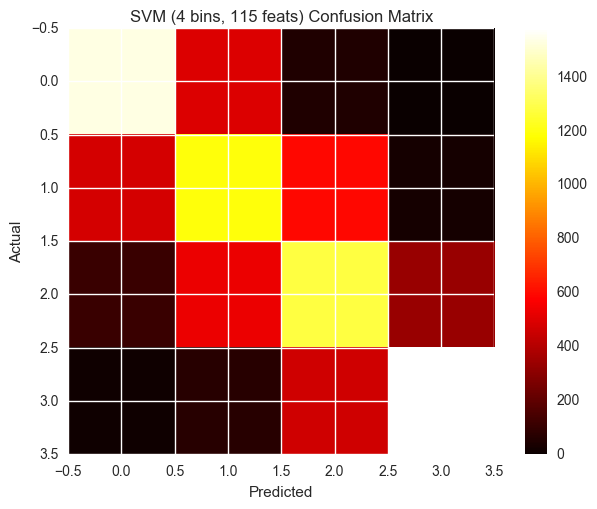


SVM (4 bins, 115 feats) train f1-score:0.636840305483
SVM (4 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.67      0.69      0.68       524
      BIN_1       0.48      0.51      0.50       575
      BIN_2       0.55      0.55      0.55       590
      BIN_3       0.78      0.71      0.75       505

avg / total       0.61      0.61      0.61      2194


Confusion matrix with 4 bins: 
[[361 146  17   0]
 [143 293 132   7]
 [ 30 145 322  93]
 [  6  22 116 361]]


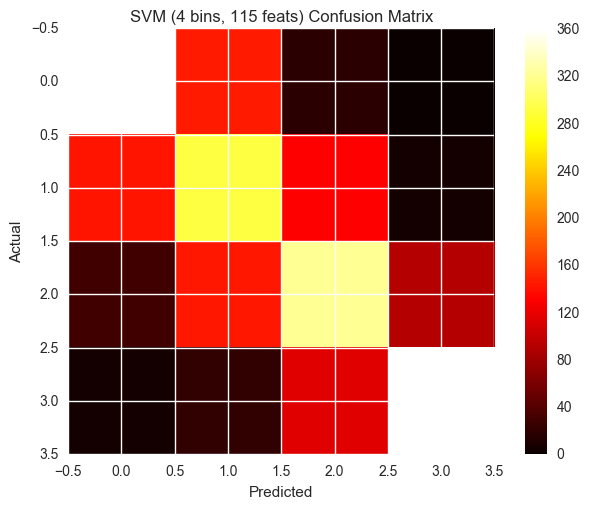


SVM (4 bins, 115 feats) validation f1-score:0.609389243391
8 Bins SVM Final Results:

Using estimator -  SVC(C=7.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
SVM (8 BINS, 115 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.56      0.77      0.65       941
      BIN_1       0.43      0.39      0.41      1144
      BIN_2       0.35      0.40      0.37      1142
      BIN_3       0.33      0.25      0.29      1150
      BIN_4       0.33      0.35      0.34      1116
      BIN_5       0.38      0.36      0.37      1147
      BIN_6       0.51      0.42      0.46      1191
      BIN_7       0.69      0.74      0.72       942

avg / total       0.44      0.45      0.44      8773


Confusion matrix with 8 bins: 
[[723 145  60  13   0   0   0   0]

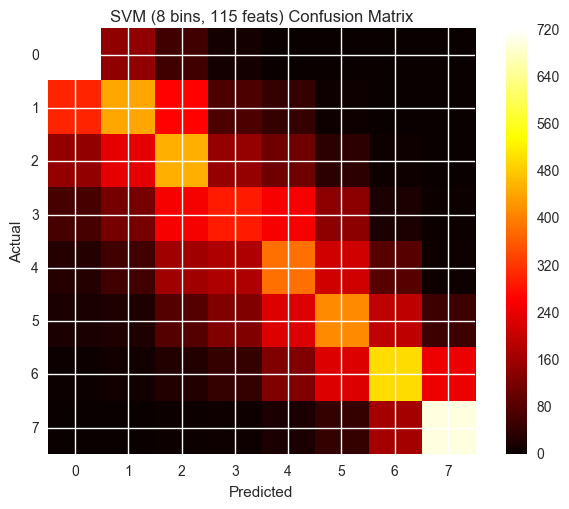


SVM (8 bins, 115 feats) train f1-score:0.445685626354

1-Bin-Away scores:
Avg Precision: 0.80057936021
Avg Recall: 0.810307813624
Avg f1-score: 0.799247833029
SVM (8 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.53      0.72      0.61       236
      BIN_1       0.38      0.35      0.37       288
      BIN_2       0.29      0.34      0.31       292
      BIN_3       0.26      0.21      0.23       283
      BIN_4       0.30      0.31      0.31       299
      BIN_5       0.33      0.29      0.31       291
      BIN_6       0.43      0.35      0.39       268
      BIN_7       0.69      0.73      0.71       237

avg / total       0.39      0.40      0.39      2194


Confusion matrix with 8 bins: 
[[171  40  17   4   3   1   0   0]
 [ 71 102  81  24   9   1   0   0]
 [ 37  64 100  43  31  16   1   0]
 [ 25  34  76  60  60  21   7   0]
 [  9  11  34  60  93  61  23   8]
 [  5  13  24  28  74  83  49  15

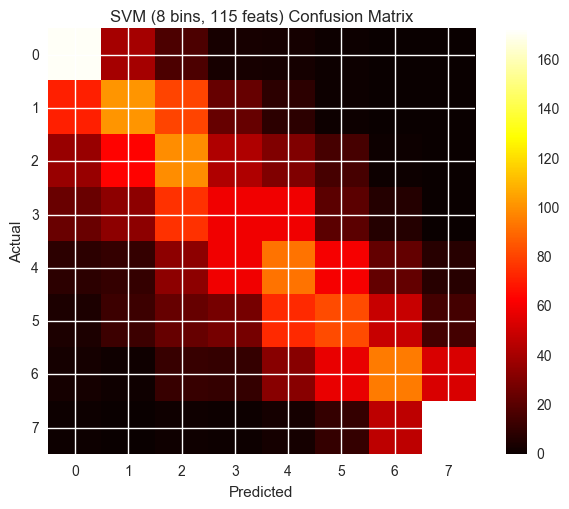


SVM (8 bins, 115 feats) validation f1-score:0.399726526892

1-Bin-Away scores:
Avg Precision: 0.787194674021
Avg Recall: 0.798296971499
Avg f1-score: 0.78712301389


In [99]:
print "best_score_idx - ", best_score_idx

for bin_num in (4, 8):
    print "%s Bins SVM Final Results:" % bin_num
    print "=========================\n"
    best_results_idx = best_score_idx[bin_num/4 - 1]
    svm_train_set, svm_val_set, svm_train_labels, svm_val_labels = svm_data_sets[best_results_idx]
    svm_train_labels = svm_train_labels['%s_bin_labels' % bin_num]
    svm_val_labels = svm_val_labels['%s_bin_labels' % bin_num]
    svm = estimators[bin_num/4 - 1][best_results_idx]
    print "Using estimator - ", svm
    
    svm_val_predictions = svm.predict(svm_val_set)
    
    if best_results_idx > 0:
        feats = feat_sel_list[best_results_idx - 1]['selected_feats']
        print "Got best results for %s selected features:\n%s" % (len(feats), '\n'.join(feats))

    svm_train_predictions = svm.predict(svm_train_set)
    svm_val_predictions = svm.predict(svm_val_set)
    score = eval_model("SVM (%s bins, %s feats)" % (bin_num, svm_train_set.shape[1]), svm_train_labels, svm_train_predictions, None, False, bin_num)
    score = eval_model("SVM (%s bins, %s feats)" % (bin_num, svm_train_set.shape[1]), svm_val_labels, svm_val_predictions, None, True, bin_num)

### Best model predictions - manual set for best params found

4 Bins SVM Final Results:

Using estimator -  SVC(C=10.4285714286, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
SVM (4 BINS, 115 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.71      0.74      0.72      2070
      BIN_1       0.52      0.52      0.52      2317
      BIN_2       0.54      0.57      0.56      2300
      BIN_3       0.81      0.73      0.77      2087

avg / total       0.64      0.63      0.64      8774


Confusion matrix with 4 bins: 
[[1526  487   57    0]
 [ 507 1214  566   30]
 [ 115  542 1311  332]
 [  14   71  484 1518]]


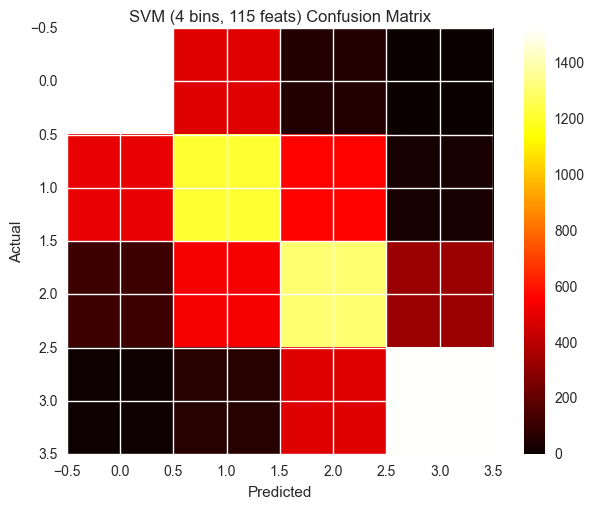


SVM (4 bins, 115 feats) train f1-score:0.634716206975



SVM (4 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.71      0.72      0.72       560
      BIN_1       0.47      0.50      0.48       554
      BIN_2       0.53      0.55      0.54       566
      BIN_3       0.82      0.73      0.77       514

avg / total       0.63      0.62      0.63      2194


Confusion matrix with 4 bins: 
[[406 140  14   0]
 [130 275 145   4]
 [ 28 151 309  78]
 [  6  22 111 375]]


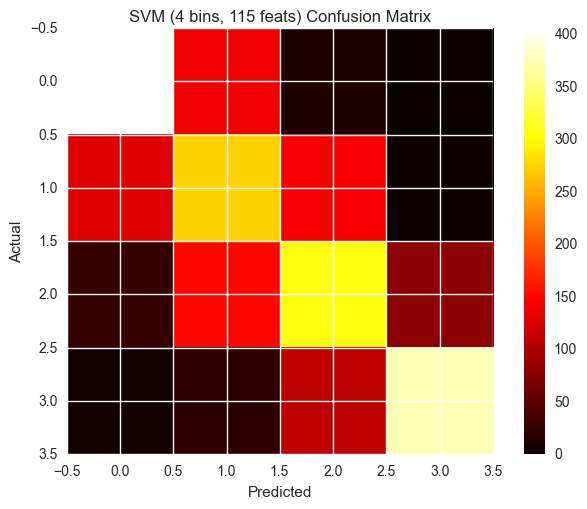


SVM (4 bins, 115 feats) validation f1-score:0.622151321787
8 Bins SVM Final Results:

Using estimator -  SVC(C=7.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
SVM (8 BINS, 115 FEATS) TRAIN RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.56      0.77      0.65       931
      BIN_1       0.42      0.43      0.43      1139
      BIN_2       0.35      0.35      0.35      1166
      BIN_3       0.35      0.29      0.32      1151
      BIN_4       0.34      0.33      0.34      1155
      BIN_5       0.38      0.38      0.38      1145
      BIN_6       0.49      0.36      0.41      1151
      BIN_7       0.68      0.78      0.72       936

avg / total       0.44      0.45      0.44      8774


Confusion matrix with 8 bins: 
[[719 150  44  16   2   0   0   0]

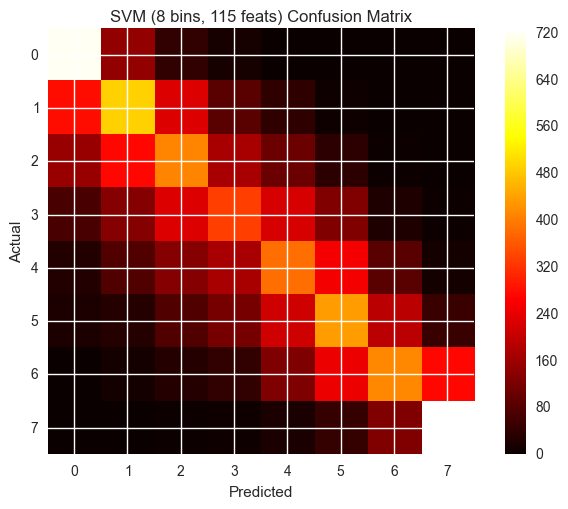


SVM (8 bins, 115 feats) train f1-score:0.447002507408

1-Bin-Away scores:
Avg Precision: 0.800343386112
Avg Recall: 0.805627871096
Avg f1-score: 0.796500291136



SVM (8 BINS, 115 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.51      0.72      0.60       246
      BIN_1       0.36      0.40      0.38       314
      BIN_2       0.28      0.28      0.28       270
      BIN_3       0.23      0.17      0.19       284
      BIN_4       0.28      0.27      0.28       281
      BIN_5       0.32      0.32      0.32       285
      BIN_6       0.47      0.34      0.39       279
      BIN_7       0.66      0.73      0.69       235

avg / total       0.38      0.39      0.38      2194


Confusion matrix with 8 bins: 
[[176  45  19   4   1   1   0   0]
 [ 96 125  59  22   8   4   0   0]
 [ 35  81  76  38  28  12   0   0]
 [ 20  53  59  48  65  35   3   1]
 [  8  22  31  55  77  71  16   1]
 [  4  13  23  28  63  91  45

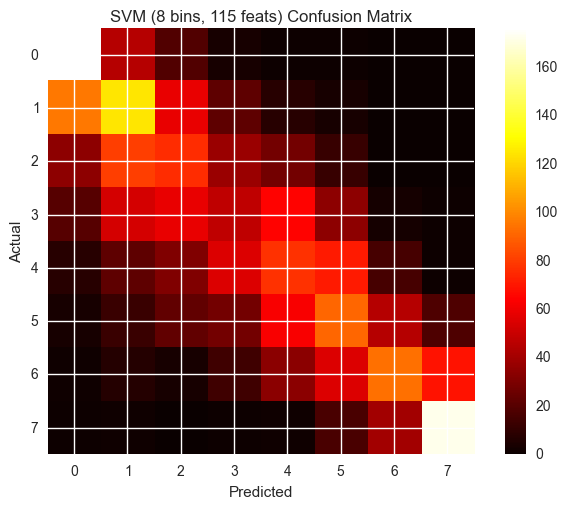


SVM (8 bins, 115 feats) validation f1-score:0.391522333637

1-Bin-Away scores:
Avg Precision: 0.777763120451
Avg Recall: 0.791086500841
Avg f1-score: 0.775883776096


In [66]:
best_score_idx = [0, 0]
best_estimators = [
    svm_lib.SVC(C=10.428571428571429, cache_size=200, class_weight='balanced', coef0=0.0,
          decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
          max_iter=-1, probability=False, random_state=None, shrinking=True,
          tol=0.001, verbose=False),
    svm_lib.SVC(C=7.0, cache_size=200, class_weight='balanced', coef0=0.0,
          decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
          max_iter=-1, probability=False, random_state=None, shrinking=True,
          tol=0.001, verbose=False)
]

for bin_num in (4, 8):
    print "%s Bins SVM Final Results:" % bin_num
    print "=========================\n"
    best_results_idx = best_score_idx[bin_num/4 - 1]
    svm_train_set, svm_val_set, svm_train_labels, svm_val_labels = svm_data_sets[best_results_idx]
    svm_train_labels = svm_train_labels['%s_bin_labels' % bin_num]
    svm_val_labels = svm_val_labels['%s_bin_labels' % bin_num]
    svm = best_estimators[bin_num/4 - 1]
    print "Using estimator - ", svm
    svm.fit(svm_train_set, svm_train_labels)
    svm_val_predictions = svm.predict(svm_val_set)
    
    if best_results_idx > 0:
        feats = feat_sel_list[best_results_idx - 1]['selected_feats']
        print "Got best results for %s selected features:\n%s" % (len(feats), '\n'.join(feats))

    svm_train_predictions = svm.predict(svm_train_set)
    svm_val_predictions = svm.predict(svm_val_set)
    score = eval_model("SVM (%s bins, %s feats)" % (bin_num, svm_train_set.shape[1]), svm_train_labels, svm_train_predictions, None, False, bin_num)
    print "\n\n"
    score = eval_model("SVM (%s bins, %s feats)" % (bin_num, svm_train_set.shape[1]), svm_val_labels, svm_val_predictions, None, True, bin_num)

## Lasso Regression

### Generate preprocessed data sets (save/load from disk to save time)

In [67]:
# Getting feature selections from disk

# feat_sel_list = get_feat_sel(train_set, val_set, train_labels['likes'], val_labels['likes'], lm.Lasso(), verbose=True)
# with open('data_sets_LASSO.json', 'w') as lassof:
#     lassof.write(json.dumps(feat_sel_list))

with open('data_sets_LASSO.json', 'r') as lassof:
    feat_sel_list = json.loads(lassof.read())

### Preprocessing - preparing different data sets and removing outliers (Grubbs) from selected features

In [68]:
lasso_train_set = train_set.copy()
lasso_val_set = val_set.copy()
lasso_train_labels = train_labels.copy()
lasso_val_labels = val_labels.copy()

lasso_data_sets = [(lasso_train_set, lasso_val_set, lasso_train_labels, lasso_val_labels)]

for feat_sel in feat_sel_list[:3]:
    feats_to_remove_by = [feat for feat in feat_sel['selected_feats'] if set(pp_data[feat].unique()) != {-1,1}]
    lasso_pp_data = grubbs_outlier_removal(pp_data, feats_to_remove_by, verbose=True)
    lasso_train_len = int(lasso_pp_data.shape[0] * 0.8)
    
    lasso_train_labels = lasso_pp_data[['likes', '4_bin_labels', '8_bin_labels']][:lasso_train_len].copy()
    lasso_val_labels = lasso_pp_data[['likes', '4_bin_labels', '8_bin_labels']][lasso_train_len:].copy()

    lasso_temp_pp_data = lasso_pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
    lasso_train_set = lasso_temp_pp_data[feat_sel['selected_feats']][:lasso_train_len].copy()
    lasso_val_set = lasso_temp_pp_data[feat_sel['selected_feats']][lasso_train_len:].copy()

    lasso_data_sets.append((lasso_train_set, lasso_val_set, lasso_train_labels, lasso_val_labels))


grubbs_outlier_removal: Got 54 feats to remove outliers by. STARTING...

grubbs_outlier_removal: feat photo_avg_likes_per_photo - 77 samples removed, 10891 samples left
grubbs_outlier_removal: feat photo_max_like - 16 samples removed, 10875 samples left
grubbs_outlier_removal: feat feed_avg_likes_per_comment - 3 samples removed, 10872 samples left
grubbs_outlier_removal: feat feed_number_of_other_categories - 82 samples removed, 10790 samples left
grubbs_outlier_removal: feat feed_avg_shares - 9 samples removed, 10781 samples left
grubbs_outlier_removal: feat feed_max_shares - 6 samples removed, 10775 samples left
grubbs_outlier_removal: feat self_feed_avg_likes_per_comment - 3 samples removed, 10772 samples left
grubbs_outlier_removal: feat self_feed_post_updated_prc - 5 samples removed, 10767 samples left
grubbs_outlier_removal: feat name_num_of_words - 13 samples removed, 10754 samples left
grubbs_outlier_removal: Total of 214 samples removed, 10754 samples left

grubbs_outlier_rem

### Fit and evaluate by best feature combination

Computing regularization path using the coordinate descent lasso... (115 feats)
Mean squared error: 1.01
training variance score: 0.75
validation variance score: 0.74


Computing regularization path using the coordinate descent lasso... (91 feats)
Mean squared error: 1.00
training variance score: 0.75
validation variance score: 0.74


Computing regularization path using the coordinate descent lasso... (75 feats)
Mean squared error: 1.00
training variance score: 0.75
validation variance score: 0.74


Computing regularization path using the coordinate descent lasso... (33 feats)
Mean squared error: 1.01
training variance score: 0.75
validation variance score: 0.74




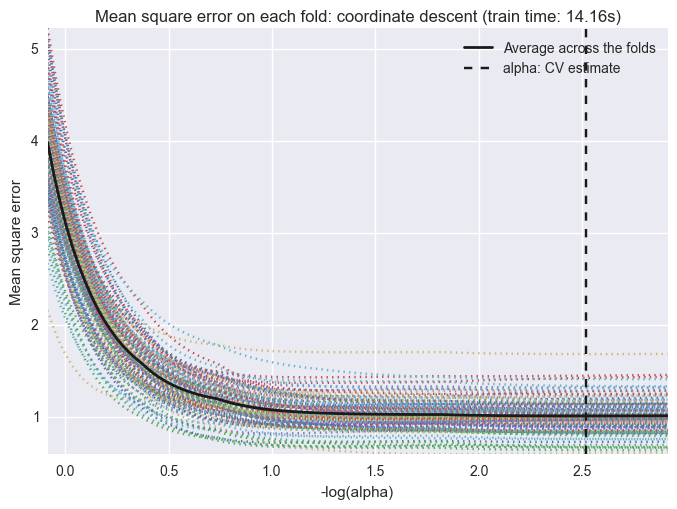

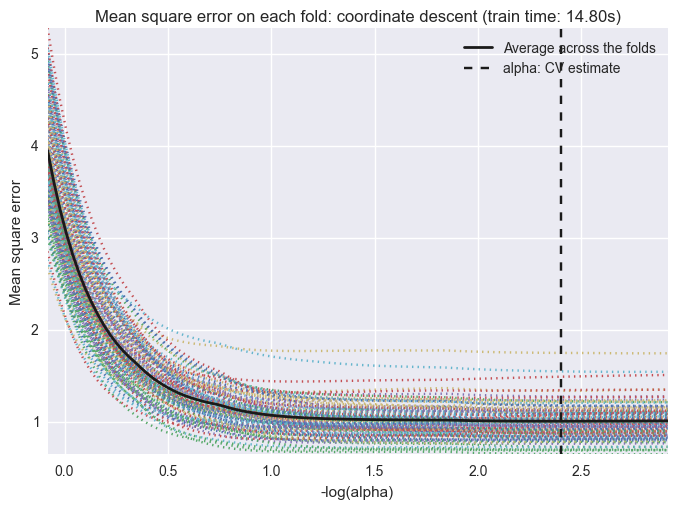

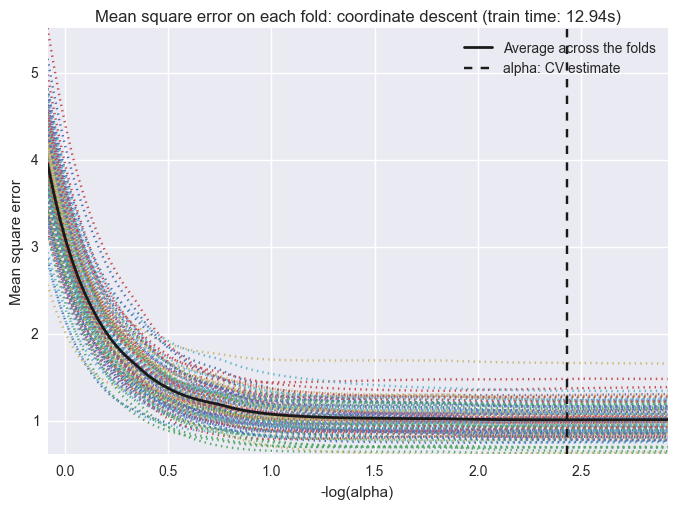

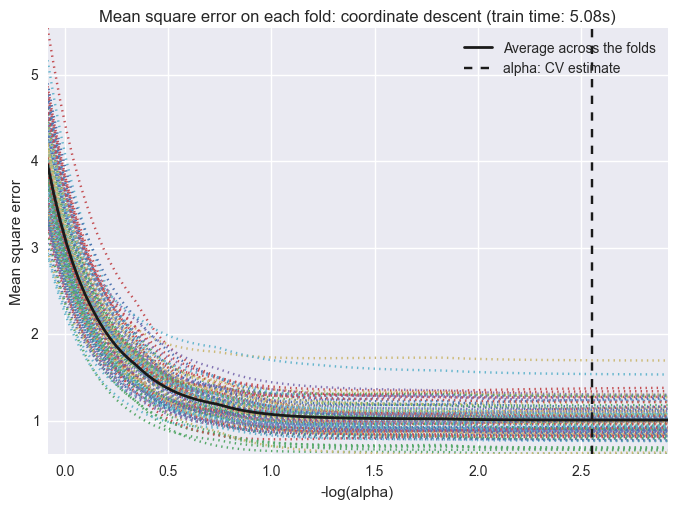

In [69]:
best_score = 0
best_score_idx = 0
best_est = None
for i in range(len(lasso_data_sets)):
    ds = lasso_data_sets[i]
    lasso_train_set, lasso_val_set, lasso_train_labels, lasso_val_labels = ds
    lasso_train_labels = lasso_train_labels['likes'].apply(_log)
    lasso_val_labels = lasso_val_labels['likes'].apply(_log)

    
    # Compute paths
    print("Computing regularization path using the coordinate descent lasso... (%s feats)" % lasso_train_set.shape[1])
    t1 = time.time()
    # Display results
    lasso = lm.LassoCV(cv=120)
    lasso.fit(lasso_train_set, lasso_train_labels)
    m_log_alphas = -np.log10(lasso.alphas_)
    t_lasso_cv = time.time() - t1

    # plot
    plt.figure()
    plt.plot(m_log_alphas, lasso.mse_path_, ':')
    plt.plot(m_log_alphas, lasso.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(lasso.alpha_), linestyle='--', color='k',
                label='alpha: CV estimate')

    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold: coordinate descent '
              '(train time: %.2fs)' % t_lasso_cv)
    plt.axis('tight')

    # The mean squared error
    print "Mean squared error: %.2f" %(np.mean((lasso.predict(lasso_train_set) - lasso_train_labels) ** 2))
    # Explained variance score: 1 is perfect prediction
    print 'training variance score: %.2f' %(lasso.score(lasso_train_set, lasso_train_labels))
    print 'validation variance score: %.2f\n\n' %(lasso.score(lasso_val_set, lasso_val_labels))
    
    if lasso.score(lasso_val_set, lasso_val_labels) > best_score:
        best_score = lasso.score(lasso_val_set, lasso_val_labels)
        best_score_idx = i
        best_est = lasso

### Best model predictions

training Lasso (91 feats):
getting Lasso predictions


Mean squared error: 1.00
training variance score: 0.75
validation variance score: 0.74


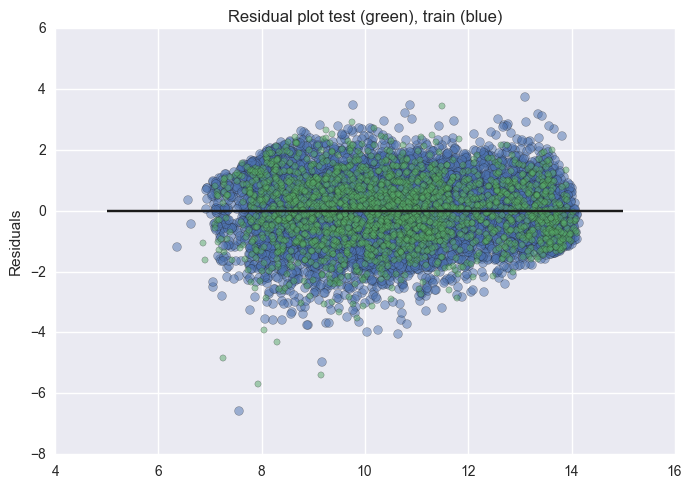

In [70]:
lasso_train_set, lasso_val_set, lasso_train_labels, lasso_val_labels = lasso_data_sets[best_score_idx]

lasso_val_likes = lasso_val_labels['likes'].copy()
lasso_train_labels = lasso_train_labels['likes'].apply(_log)
lasso_val_labels = lasso_val_labels['likes'].apply(_log)

lasso = best_est
print "training Lasso (%s feats):" % (lasso_train_set.shape[1])
lasso.fit(lasso_train_set, lasso_train_labels)
print "getting Lasso predictions"
lasso_predictions = lasso.predict(lasso_train_set.append(lasso_val_set, ignore_index=True))

lasso_train_predictions = lasso_predictions[:lasso_train_set.shape[0]]
lasso_val_predictions = lasso_predictions[lasso_train_set.shape[0]:]

# The mean squared error
print "\n\nMean squared error: %.2f" %(np.mean((lasso.predict(lasso_train_set) - lasso_train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print 'training variance score: %.2f' %(lasso.score(lasso_train_set, lasso_train_labels))
print 'validation variance score: %.2f' %(lasso.score(lasso_val_set, lasso_val_labels))
    
plt.scatter(lasso_train_predictions, lasso_train_predictions - lasso_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(lasso_val_predictions, lasso_val_predictions - lasso_val_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=5, xmax=15)
plt.title('Residual plot test (green), train (blue)')
plt.ylabel('Residuals')
plt.show()

### Model binning predictions and scores

Lasso validation precision for 4 bins: 0.624825662483
LASSO (4 BINS, 91 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.73      0.73      0.73       538
      BIN_1       0.47      0.47      0.47       538
      BIN_2       0.51      0.51      0.51       537
      BIN_3       0.79      0.79      0.79       538

avg / total       0.62      0.62      0.62      2151


Confusion matrix with 4 bins: 
[[392 128  18   0]
 [122 255 155   6]
 [ 19 135 274 109]
 [  5  20  90 423]]


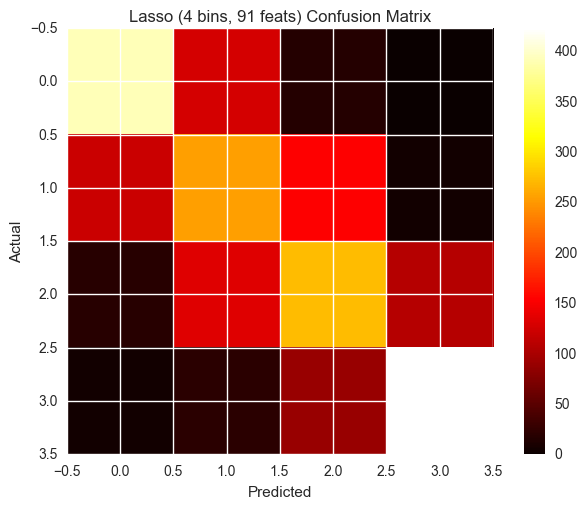


Lasso (4 bins, 91 feats) validation f1-score:0.624825662483
Lasso validation precision for 8 bins: 0.387261738726
LASSO (8 BINS, 91 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.59      0.59      0.59       269
      BIN_1       0.34      0.34      0.34       269
      BIN_2       0.26      0.26      0.26       269
      BIN_3       0.23      0.23      0.23       269
      BIN_4       0.28      0.28      0.28       268
      BIN_5       0.29      0.29      0.29       269
      BIN_6       0.39      0.39      0.39       269
      BIN_7       0.71      0.71      0.71       269

avg / total       0.39      0.39      0.39      2151


Confusion matrix with 8 bins: 
[[159  75  26   8   0   1   0   0]
 [ 67  91  62  32  12   5   0   0]
 [ 25  57  71  66  39  10   1   0]
 [  9  31  56  62  64  42   5   0]
 [  5   7  31  54  76  70  25   0]
 [  1   6  18  32  50  78  70  14]
 [  2   1   5  12  26  54 105  64]
 [  1  

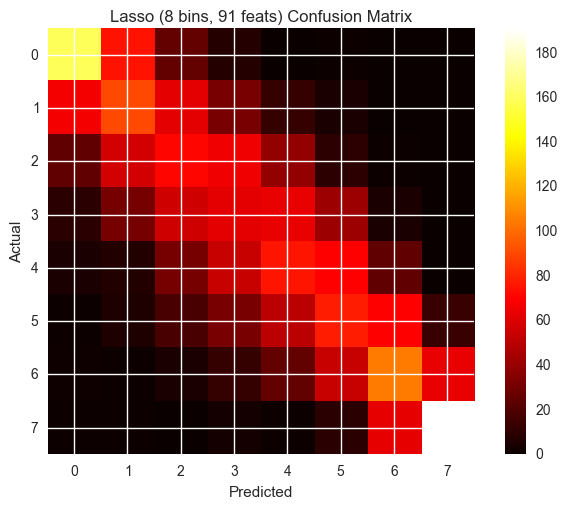


Lasso (8 bins, 91 feats) validation f1-score:0.387261738726

1-Bin-Away scores:
Avg Precision: 0.792633024469
Avg Recall: 0.792633024469
Avg f1-score: 0.792633024469


In [71]:
val_exp_pred = np.exp(lasso_val_predictions)

for bin_num in [4,8]:
    val_pred_bins = binning(val_exp_pred, bin_num)

    lasso_val_set_bin_labels = binning(lasso_val_likes, bin_num)

    score = metrics.f1_score(lasso_val_set_bin_labels.values, val_pred_bins, average='micro')
    print "Lasso validation precision for %s bins: %s" %(bin_num, score)

    run_score = eval_model("Lasso (%s bins, %s feats)" % (bin_num, lasso_train_set.shape[1]), lasso_val_set_bin_labels, val_pred_bins, None, True, bin_num)

## Random Forest - best results model

### Utils

In [72]:
def rf_feature_sel_param_opt(rf_train_set, rf_val_set, rf_train_labels, rf_val_labels):
    forest = RandomForestClassifier(n_estimators=250, max_depth=15)
    forest.fit(rf_train_set.values, rf_train_labels.values)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking - Top 10:")
    for f in range(10):
        print("%d. feature %d (%s)\n   score: %f" % (f + 1, indices[f], list(rf_train_set)[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plot_idxs = indices[:20]
    plt.figure()
    plt.title("Feature importances (Top 20)")
    plt.bar(range(20), importances[plot_idxs],
           color="r", yerr=std[plot_idxs], align="center")
    plt.xticks(range(20), plot_idxs)
    plt.xlim([-1, 21])
    plt.show()
    
    importances_thresholds = [0, 0.005, 0.01, 0.015, 0.02]
    max_depths = [10, 20, 30, None] 
    min_samples_leaf = [1, 3, 5]

    filtered_by_thresholds = []
    for t in importances_thresholds:
        columns = []
        for f in range(rf_train_set.shape[1]):
            if importances[indices[f]] >= t:
                columns.append(list(rf_train_set)[indices[f]])
        filtered_by_thresholds.append(columns)

    params = []
    score_summary = []
    oobs = []
    print "(threshold, depth, min_samples) -> average f1 score, oob error"
    for i in range(len(filtered_by_thresholds)):
        for d in max_depths:
            for l in min_samples_leaf:
                cols = filtered_by_thresholds[i]
                forest = RandomForestClassifier(n_estimators=250, random_state=0, oob_score=True, max_depth=d, min_samples_leaf=l)
                forest.fit(rf_train_set[cols], rf_train_labels)
                temp_predictions = forest.predict(rf_val_set[cols])
                res = metrics.f1_score(rf_val_labels, temp_predictions, average='micro')
                oob_error = 1 - forest.oob_score_
                score_summary.append(res)
                oobs.append(oob_error)
                params.append((importances_thresholds[i], d, l))
                print "params: %s -> f1: %s, oob error: %s" % (params[-1], score_summary[-1], oobs[-1])

    max_idx = np.argmax(score_summary)
    best_threshold = params[max_idx][0]
    best_max_depth = params[max_idx][1]
    best_min_leaf = params[max_idx][2]

    # Print best hyper parameters
    print "RF best parameters:"
    print "max_depth = ", best_max_depth
    print "importance_threshold = ", best_threshold
    print "min_samples_leaf = ", best_min_leaf

    fc = filtered_by_thresholds[importances_thresholds.index(best_threshold)]
    return fc, best_max_depth, best_min_leaf

### Data preparation - 4 bins

In [73]:
rf_train_set = train_set.copy()
rf_val_set = val_set.copy()
rf_train_labels = train_labels['4_bin_labels'].copy()
rf_val_labels = val_labels['4_bin_labels'].copy()

### Feature selection and parameter optimization - 4 bins - NO NEED TO RUN

Feature ranking - Top 10:
1. feature 112 (lr_predict_1)
   score: 0.084140
2. feature 114 (linr_predict)
   score: 0.081321
3. feature 113 (lr_predict_2)
   score: 0.067786
4. feature 111 (lr_predict_0)
   score: 0.065368
5. feature 81 (talking_about_count)
   score: 0.044839
6. feature 53 (self_feed_avg_likes)
   score: 0.031613
7. feature 16 (photo_max_like)
   score: 0.027572
8. feature 74 (self_feed_std_likes)
   score: 0.026412
9. feature 26 (total_photos)
   score: 0.024663
10. feature 62 (self_feed_max_likes)
   score: 0.024294


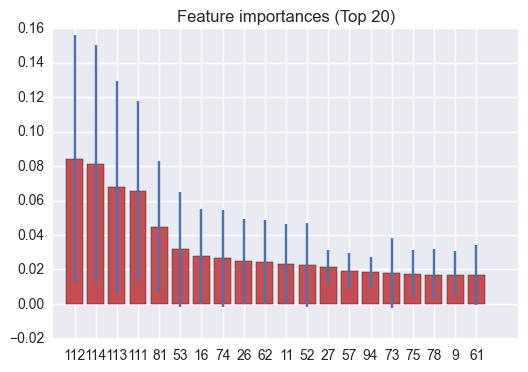

(threshold, depth, min_samples) -> average f1 score, oob error
params: (0, 10, 1) -> f1: 0.616226071103, oob error: 0.355287146764
params: (0, 10, 3) -> f1: 0.611212397448, oob error: 0.355856882407
params: (0, 10, 5) -> f1: 0.617593436645, oob error: 0.357680036463
params: (0, 20, 1) -> f1: 0.619416590702, oob error: 0.352780309936
params: (0, 20, 3) -> f1: 0.613947128532, oob error: 0.348906107566
params: (0, 20, 5) -> f1: 0.617593436645, oob error: 0.352666362808
params: (0, 30, 1) -> f1: 0.622607110301, oob error: 0.35403372835
params: (0, 30, 3) -> f1: 0.621695533273, oob error: 0.346741112124
params: (0, 30, 5) -> f1: 0.618960802188, oob error: 0.352210574294
params: (0, None, 1) -> f1: 0.625341841386, oob error: 0.351412944394
params: (0, None, 3) -> f1: 0.62032816773, oob error: 0.347424794895
params: (0, None, 5) -> f1: 0.618960802188, oob error: 0.352210574294
params: (0.005, 10, 1) -> f1: 0.62032816773, oob error: 0.351412944394
params: (0.005, 10, 3) -> f1: 0.617137648131, 

In [129]:
fc, best_max_depth, best_min_leaf = rf_feature_sel_param_opt(rf_train_set, rf_val_set, rf_train_labels, rf_val_labels)
print fc

### Model evaluation - 4 bins

RF Estimator -  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=True, random_state=0,
            verbose=0, warm_start=False)
RANDOM FOREST VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.74      0.77      0.75       560
      BIN_1       0.50      0.55      0.52       554
      BIN_2       0.55      0.55      0.55       566
      BIN_3       0.83      0.74      0.78       514

avg / total       0.65      0.65      0.65      2194


Confusion matrix with 4 bins: 
[[430 120  10   0]
 [121 303 130   0]
 [ 24 157 309  76]
 [  5  22 109 378]]


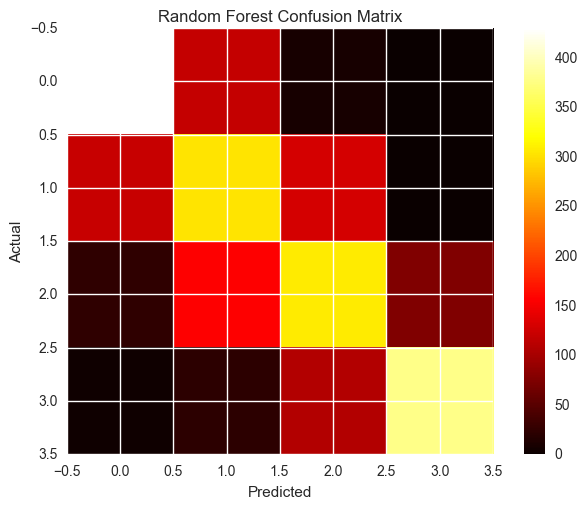


Random Forest validation f1-score:0.647219690064


In [74]:
best_max_depth =  None
best_min_leaf =  1
fc = ['lr_predict_1', 'linr_predict', 'lr_predict_2', 'lr_predict_0', 'talking_about_count', u'self_feed_avg_likes', u'photo_max_like', u'self_feed_std_likes', u'total_photos', u'self_feed_max_likes', u'photo_avg_likes_per_photo', u'self_feed_avg_comments', u'photo_number_of_days_between_first_and_last_photos', u'self_feed_number_of_days_between_first_and_last_posts', 'posting_freq', u'self_feed_std_comments', u'self_feed_avg_shares', u'self_feed_std_shares', u'photo_avg_comments_per_photo', u'self_feed_max_comments', u'self_feed_min_likes', u'photo_avg_likes_per_comments', u'self_feed_avg_likes_per_comment', u'self_feed_max_shares', u'checkins', 'photo_upload_freq', u'self_feed_post_updated_prc', u'self_post_count', 'were_here_count', u'photo_number_of_different_months_for_photos']

forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
print "RF Estimator - ", forest
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_train_predictions = forest.predict(rf_train_set[fc])
rf_val_predicted_probs = forest.predict_proba(rf_val_set[fc])
rf_val_predictions = forest.predict(rf_val_set[fc])

f1_score = eval_model("Random Forest", rf_val_labels, rf_val_predictions, rf_val_predicted_probs, 
           is_val=True, bin_num=4)

### Data preparation - 8 bins

In [75]:
rf_train_set = train_set.copy()
rf_val_set = val_set.copy()
rf_train_labels = train_labels['8_bin_labels'].copy()
rf_val_labels = val_labels['8_bin_labels'].copy()

### Feature selection and parameter optimization - 8 bins - NO NEED TO RUN

Feature ranking - Top 10:
1. feature 114 (linr_predict)
   score: 0.067459
2. feature 112 (lr_predict_1)
   score: 0.055654
3. feature 113 (lr_predict_2)
   score: 0.052061
4. feature 111 (lr_predict_0)
   score: 0.050504
5. feature 81 (talking_about_count)
   score: 0.040743
6. feature 53 (self_feed_avg_likes)
   score: 0.027251
7. feature 62 (self_feed_max_likes)
   score: 0.026650
8. feature 74 (self_feed_std_likes)
   score: 0.024312
9. feature 16 (photo_max_like)
   score: 0.024251
10. feature 27 (photo_number_of_days_between_first_and_last_photos)
   score: 0.022969


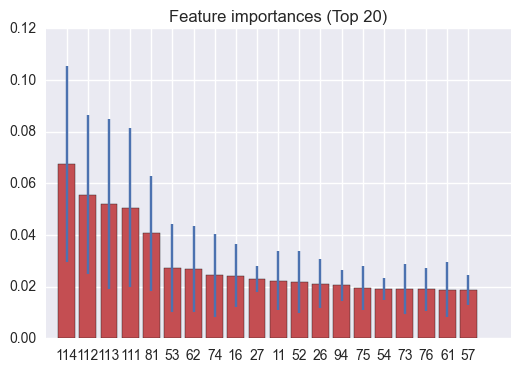

(threshold, depth, min_samples) -> average f1 score, oob error
params: (0, 10, 1) -> f1: 0.405195989061, oob error: 0.586485870556
params: (0, 10, 3) -> f1: 0.39516864175, oob error: 0.580674567001
params: (0, 10, 5) -> f1: 0.399726526892, oob error: 0.587055606199
params: (0, 20, 1) -> f1: 0.405195989061, oob error: 0.585346399271
params: (0, 20, 3) -> f1: 0.408842297174, oob error: 0.583295350957
params: (0, 20, 5) -> f1: 0.399726526892, oob error: 0.582155879672
params: (0, 30, 1) -> f1: 0.395624430264, oob error: 0.583751139471
params: (0, 30, 3) -> f1: 0.397447584321, oob error: 0.578053783045
params: (0, 30, 5) -> f1: 0.402461257976, oob error: 0.580332725615
params: (0, None, 1) -> f1: 0.39288969918, oob error: 0.586599817685
params: (0, None, 3) -> f1: 0.396991795807, oob error: 0.579307201459
params: (0, None, 5) -> f1: 0.405651777575, oob error: 0.580560619872
params: (0.005, 10, 1) -> f1: 0.397903372835, oob error: 0.581130355515
params: (0.005, 10, 3) -> f1: 0.396991795807,

In [125]:
fc, best_max_depth, best_min_leaf = rf_feature_sel_param_opt(rf_train_set, rf_val_set, rf_train_labels, rf_val_labels)
print fc

### Model evaluation - 8 bins

RF Estimator -  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=True, random_state=0,
            verbose=0, warm_start=False)
RANDOM FOREST VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.54      0.68      0.60       246
      BIN_1       0.39      0.42      0.41       314
      BIN_2       0.30      0.29      0.29       270
      BIN_3       0.24      0.24      0.24       284
      BIN_4       0.29      0.27      0.28       281
      BIN_5       0.33      0.30      0.31       285
      BIN_6       0.45      0.42      0.44       279
      BIN_7       0.73      0.67      0.70       235

avg / total       0.40      0.40      0.40      2194


Confusion matri

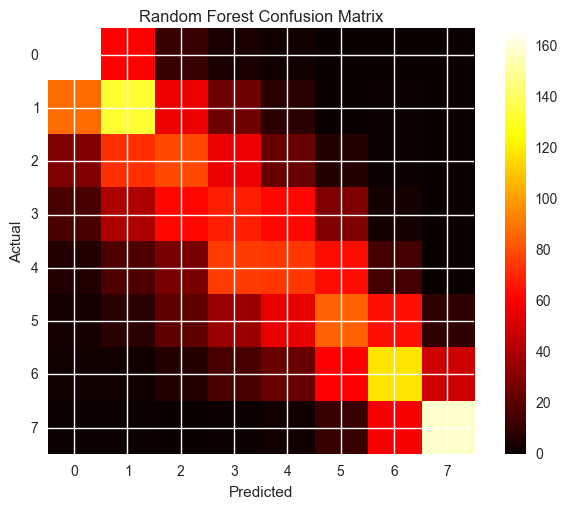


Random Forest validation f1-score:0.40291704649

1-Bin-Away scores:
Avg Precision: 0.813208603424
Avg Recall: 0.816974052877
Avg f1-score: 0.812750395532


In [76]:
best_max_depth =  30
best_min_leaf =  3
fc = ['linr_predict', 'lr_predict_1', 'lr_predict_2', 'lr_predict_0', 'talking_about_count', u'self_feed_avg_likes', u'self_feed_max_likes', u'self_feed_std_likes', u'photo_max_like', u'photo_number_of_days_between_first_and_last_photos', u'photo_avg_likes_per_photo', u'self_feed_avg_comments', u'total_photos', 'posting_freq', u'self_feed_avg_shares', u'self_feed_avg_likes_per_comment', u'self_feed_std_comments', u'self_feed_max_shares', u'self_feed_max_comments', u'self_feed_number_of_days_between_first_and_last_posts', u'photo_avg_comments_per_photo', u'photo_avg_likes_per_comments', u'self_feed_std_shares', u'checkins', 'photo_upload_freq', u'self_feed_min_likes', 'were_here_count', u'self_feed_post_updated_prc', u'photo_number_of_different_months_for_photos', u'self_post_count', 'name_num_of_words', u'photo_min_like']

forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
print "RF Estimator - ", forest
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_train_predictions = forest.predict(rf_train_set[fc])
rf_val_predicted_probs = forest.predict_proba(rf_val_set[fc])
rf_val_predictions = forest.predict(rf_val_set[fc])

f1_score = eval_model("Random Forest", rf_val_labels, rf_val_predictions, rf_val_predicted_probs, 
           is_val=True, bin_num=8)

# Random Forest Evaluation - Test Set

RANDOM FOREST TEST RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.69      0.81      0.74       298
      BIN_1       0.50      0.53      0.51       320
      BIN_2       0.50      0.47      0.48       325
      BIN_3       0.84      0.72      0.77       333

avg / total       0.63      0.63      0.63      1276


Confusion matrix with 4 bins: 
[[240  51   6   1]
 [ 86 169  65   0]
 [ 17 110 152  46]
 [  4   8  82 239]]


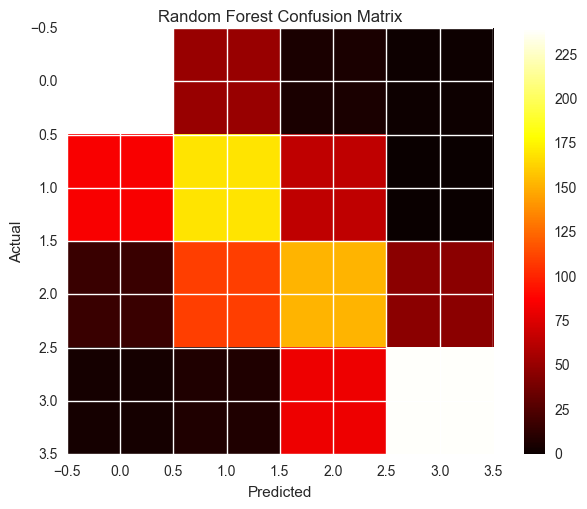


Random Forest test f1-score:0.626959247649



RANDOM FOREST TEST RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.61      0.86      0.71       156
      BIN_1       0.32      0.35      0.33       142
      BIN_2       0.29      0.31      0.30       160
      BIN_3       0.23      0.21      0.22       160
      BIN_4       0.22      0.20      0.21       159
      BIN_5       0.36      0.28      0.32       166
      BIN_6       0.44      0.42      0.43       165
      BIN_7       0.83      0.71      0.77       168

avg / total       0.41      0.42      0.41      1276


Confusion matrix with 8 bins: 
[[134  17   4   0   0   0   1   0]
 [ 44  49  29  13   5   2   0   0]
 [ 24  40  50  27  15   4   0   0]
 [ 11  26  43  34  36   8   2   0]
 [  6  16  28  46  32  21  10   0]
 [  0   1  14  23  37  47  38   6]
 [  0   4   3   6  19  44  70  19]
 [  1   0   1   0   2   6  38 120]]


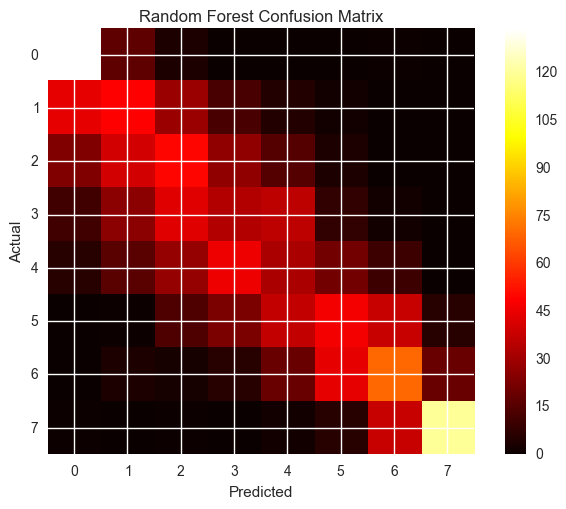


Random Forest test f1-score:0.420062695925

1-Bin-Away scores:
Avg Precision: 0.796090214067
Avg Recall: 0.806353606628
Avg f1-score: 0.795633198667





In [77]:
rf_estimators = [
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=None, max_features='auto', max_leaf_nodes=None,
                min_impurity_split=1e-07, min_samples_leaf=1,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=250, n_jobs=1, oob_score=True, random_state=0,
                verbose=0, warm_start=False),
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=30, max_features='auto', max_leaf_nodes=None,
                min_impurity_split=1e-07, min_samples_leaf=3,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=250, n_jobs=1, oob_score=True, random_state=0,
                verbose=0, warm_start=False)
]
fcs = [
    ['lr_predict_1', 'linr_predict', 'lr_predict_2', 'lr_predict_0', 'talking_about_count', u'self_feed_avg_likes', u'photo_max_like', u'self_feed_std_likes', u'total_photos', u'self_feed_max_likes', u'photo_avg_likes_per_photo', u'self_feed_avg_comments', u'photo_number_of_days_between_first_and_last_photos', u'self_feed_number_of_days_between_first_and_last_posts', 'posting_freq', u'self_feed_std_comments', u'self_feed_avg_shares', u'self_feed_std_shares', u'photo_avg_comments_per_photo', u'self_feed_max_comments', u'self_feed_min_likes', u'photo_avg_likes_per_comments', u'self_feed_avg_likes_per_comment', u'self_feed_max_shares', u'checkins', 'photo_upload_freq', u'self_feed_post_updated_prc', u'self_post_count', 'were_here_count', u'photo_number_of_different_months_for_photos'],
    ['linr_predict', 'lr_predict_1', 'lr_predict_2', 'lr_predict_0', 'talking_about_count', u'self_feed_avg_likes', u'self_feed_max_likes', u'self_feed_std_likes', u'photo_max_like', u'photo_number_of_days_between_first_and_last_photos', u'photo_avg_likes_per_photo', u'self_feed_avg_comments', u'total_photos', 'posting_freq', u'self_feed_avg_shares', u'self_feed_avg_likes_per_comment', u'self_feed_std_comments', u'self_feed_max_shares', u'self_feed_max_comments', u'self_feed_number_of_days_between_first_and_last_posts', u'photo_avg_comments_per_photo', u'photo_avg_likes_per_comments', u'self_feed_std_shares', u'checkins', 'photo_upload_freq', u'self_feed_min_likes', 'were_here_count', u'self_feed_post_updated_prc', u'photo_number_of_different_months_for_photos', u'self_post_count', 'name_num_of_words', u'photo_min_like']
]
rf_train_set = train_set.copy()
rf_train_labels = train_labels.copy()

for bin_num in (4,8):
    forest = rf_estimators[bin_num/4 - 1]
    fc = fcs[bin_num/4 - 1]
    forest.fit(rf_train_set[fc].values, rf_train_labels['%s_bin_labels' % bin_num])

    rf_test_predicted_probs = forest.predict_proba(test_data_set[fc])
    rf_test_predictions = forest.predict(test_data_set[fc])
    
    f1_score = eval_model("Random Forest", test_data_labels['%s_bin_labels' % bin_num], rf_test_predictions, rf_test_predicted_probs, 
               is_test=True, bin_num=bin_num)
    print "\n\n"